##**Short Analytical Report**

The National Pollutant Release Inventory (NPRI) is Canada’s legislated, publicly accessible database of pollutant releases to air, water, and land, as well as disposals and off-site transfers from industrial and other facilities (Environment and Climate Change Canada [ECCC], 2025). The NPRI is administered by Environment and Climate Change Canada under the Canadian Environmental Protection Act, 1999 (CEPA 1999), which legally requires certain facilities to report if they meet defined substance and quantity thresholds (Government of Canada, 1999; ECCC, 2025).

Facilities that meet NPRI reporting thresholds must submit annual quantities for each listed pollutant. They must report:
- how much was released to air, water, and land,
- how much was disposed of on-site (e.g., landfill, underground injection), and
- how much was transferred off-site for treatment, recycling, or disposal (ECCC, 2025).

These facility-level reports are then published by the federal government to support transparency, research, and policy evaluation (ECCC, 2025). The datasets we are using are built from those reports.

**NPRI_2000–2022 Core Files (What They Contain):**
- **Releases 2000–2020.csv**  
  Annual quantities released by each facility to air, water, and land, broken down by pollutant and year.
- **Disposals and Transfers 2000–2020.csv**  
  Amounts disposed on-site or transferred off-site (for example, to recyclers, treatment facilities, or landfills).
- **Comments.csv**  
  Notes, clarifications, or corrections provided by facilities or by ECCC to explain anomalies in the reported data.

Together, these files tell us:  
1. What went directly into the environment (releases),  
2. What was handled as waste and moved/stored (disposals/transfers), and  
3. Why certain numbers might look unusual (comments/notes).

### NPRI rules (CO and NOₓ)

For this analysis we focus on two combustion-related air pollutants:
- Nitrogen Oxides (NOₓ, expressed as NO₂-equivalent)
- Carbon Monoxide (CO)

Under NPRI reporting rules for combustion air releases (Part 4 substances), a facility generally must report if it emits ≥20 tonnes per year of NOₓ (as NO₂) or CO at the facility level (ECCC, 2022). In some cases, stack-level or flare-level reporting is also required, but that applies only if:
1. the facility is already above the facility-wide threshold, and  
2. the specific stack/flare also exceeds a more strict stack-specific threshold.

For CO, for example, there is a 10 tonne/year stack threshold along with physical criteria such as stack height and exhaust conditions (ECCC, 2022). The NPRI guide also defines the equivalent rule for NOₓ stacks.

Important detail: in NPRI reporting, “nitrogen oxides (expressed as NO₂)” means NO and NO₂ reported as NO₂-equivalent mass. Nitrous oxide (N₂O) is not included in that number (ECCC, 2022). So “NOₓ” in this dataset is not “all nitrogen oxides of any kind,” it is a specific regulated definition.

Units: NPRI emissions to air are typically reported in kilograms per year. When facilities report in tonnes, 1 tonne (t) = 1,000 kilograms (kg) (ECCC, 2022). In our working dataset, the CO and NOₓ values we care about are reported in tonnes, so throughout this notebook we interpret these fields as tonnes.

---

## Problem Statement

Question we’re asking:
> Did the introduction of federal carbon pricing in 2019 (as a national backstop price on carbon pollution) correspond to measurable changes in reported industrial emissions of NOₓ (as NO₂) and CO?

We break that into two objectives:

1. **Descriptive analysis**  
   Measure how reported NOₓ and CO releases to air changed after 2019.  
   We do this in two ways:
   - Total emissions per year (national view).
   - Average emissions per facility per year (per-facility view).

   The per-facility view matters, because totals alone can drop just because fewer facilities are reporting. If the “typical” facility is emitting less after 2019, that’s a stronger signal.

2. **Predictive framing**  
   Use those post-2019 trends to reason about what might happen next as the carbon price continues to rise.  
   This is NOT a trained ML forecast yet. It’s a logic-based forecast:
   - “If average NOₓ per facility in Province X has been dropping year-over-year since 2019 with no rebound, we expect that slope to continue under ongoing pricing pressure.”

Important scope note:  
The NPRI mostly captures larger, stationary industrial sources that pass reporting thresholds. It does not include every small or mobile source (like individual vehicles or small boilers). So when we talk about “emissions going down,” we are talking about large industrial facilities that report to NPRI, not Canada-wide combustion in general (ECCC, 2025).

---

## Metadata (what’s in the raw files)

Before cleaning anything, we mapped out what each dataset contains and how the columns are supposed to be interpreted. This prevents us from misusing a field in modeling. Please look to Appendix A for more detailed feature metadata.

**Releases (2000–2020)**
- `FacilityID`: unique facility identifier.
- `FacilityName`: facility name as reported.
- `City`, `Province`, `PostalCode`: location information.
- `NAICSCode`: industrial classification (North American Industry Classification System; Statistics Canada, 2024).
- `SubstanceName`: pollutant name (e.g. “Carbon monoxide”, “Nitrogen oxides (expressed as nitrogen dioxide)”).
- `CASNumber`: chemical identifier.
- `ReportingYear`: reporting year.
- `Unit`: mass unit (often kilograms or tonnes).
- `Air`, `Water`, `Land`: quantity released to each environmental medium that year.
- `TotalReleases`: total combined reported releases for that facility+substance+year.

**Disposals and Transfers (2000–2020)**
- `FacilityID`: links to the same facility as in Releases.
- `SubstanceName`, `CASNumber`: pollutant identifiers.
- `ReportingYear`: reporting year.
- `OnSiteDisposal`: amount disposed/contained on the facility’s site (e.g. landfill cell, underground injection).
- `OffSiteTransfer` and `OffSiteTransferType`: amount and type of material sent off-site for treatment, recycling, or final disposal.
- `Unit`: again typically kilograms or tonnes.
- `TotalDisposalsTransfers`: total disposed + transferred.

**Comments**
- `FacilityID`, `ReportingYear`: reference back to a specific record.
- `SubstanceName`: pollutant the note is about, if specified.
- `CommentText`, `CommentType`: explanations, corrections, shutdown notes, process upsets, etc.
- `LastUpdated`: most recent edit timestamp.

---

## Pre-cleaning Observations Summary

Before doing any trend analysis, we inspected and cleaned the raw data. Key steps:

1. **Column naming / consistency**  
   Original columns were messy (bilingual labels, punctuation, trailing spaces like `"Release to Air - Stack / Point  "`).  
   We standardized all column names to lowercase, ASCII, and snake_case (underscores).  
   Example: `"Release to Air - Stack / Point  "` → `release_to_air_stack_point`,  
   `"Reporting_Year / Année"` → `reporting_year_annee`.  
   This avoids bugs when grouping or merging.

2. **Geographic validity**  
   Each row includes latitude and longitude. Some rows reported `0` for latitude or longitude, or coordinates that are clearly outside Canada.  
   We flagged those as invalid and plan to replace missing/invalid coordinates using the median latitude/longitude for that province.  
   Why? We care about comparing provinces over time (policy signal), so we preserve provincial information instead of dropping “bad location” rows entirely.

   We do **not** drop rows just because the coordinates are missing. Dropping those rows would bias the dataset (for example, under-counting certain industries or regions that report less precise coordinates).

3. **Missing / placeholder values**  
   Text fields sometimes contain `"N/A"`, `"blank"`, `"Unknown"`, etc. We treat those as missing.  
   For emissions amounts, we do **not** automatically convert missing to 0. “Not reported” is not always the same as “zero emissions.” Leaving missing values as `NaN` avoids faking a drop in emissions.



4. **Unit handling**  
   NPRI air releases are often recorded in kilograms, but in our working dataset the CO and NOₓ values we care about are reported in tonnes.  
   We keep them as tonnes and note that assumption (ECCC, 2022).  
   This prevents silent unit mix-ups in plots and summaries.

5. **Duplicates**  
   After filtering down to only CO and NOₓ, we checked for duplicate rows (same facility, same pollutant, same year).  
   We found a small number, dropped them, and reset the index so each row is a unique facility–pollutant–year record.

6. **Scope narrowing**  
   After cleaning, we built our main analysis dataset by keeping **only two pollutants**:
   - Carbon monoxide (CO)
   - Nitrogen oxides (NOₓ, expressed as NO₂-equivalent)

   We focus on these because both are directly tied to combustion. If carbon pricing is successfully pushing facilities toward cleaner combustion or reduced fossil fuel use, these two pollutants should be among the first to show a decline (ECCC, 2025).

Bottom line: after pre-cleaning, the dataset is (a) column-consistent, (b) spatially usable at the province level, and (c) tightly focused on combustion pollutants that are relevant to carbon pricing.

---

## Findings and Visualizations

After cleaning and filtering to CO and NOₓ, we ran exploratory data analysis (EDA). We looked at four things:

1. **Time trends after 2019**  
   We calculated:
   - Total reported CO and NOₓ released to air per year, and  
   - Average emissions per facility per year.

   The per-facility average is very important. Total emissions can fall just because fewer facilities reported. But if the *typical facility* is reporting less NOₓ or CO after 2019, that supports the idea that facility-level combustion emissions are actually going down in the carbon pricing era.

   If both (a) total emissions and (b) average-per-facility emissions trend downward in the post-2019 period, that pattern is **consistent** with pricing pressure.  
   Note: this is correlation, not proof. Other factors (new tech, process changes, fuel switching, economic slowdowns, shutdowns, etc.) can also drive declines.

2. **Provincial differences**  
   We grouped by province and reporting year to compare average NOₓ and CO emissions per facility across provinces.

   Why this matters:  
   Canada’s carbon pricing system has a federal backstop, but some provinces run their own approved systems. If Province A shows a sharper drop in per-facility NOₓ or CO starting in 2019 compared to Province B, that might reflect different pricing strength, compliance strategies, or parallel provincial regulations.

   Because we preserved province information (and didn’t just drop “bad coordinate” rows), we can actually make these province-to-province comparisons.

3. **Distribution and outliers**  
   We plotted facility-level emissions vs. reporting year for CO and NOₓ.  
   Result: emissions are highly skewed. A few very large emitters can dominate national totals.

   That means a big “downward jump” in total national NOₓ might just be one or two large facilities changing operations, not a nationwide shift.  
   This is why we always interpret per-facility averages alongside totals. If the median or mean per facility is drifting down, that suggests broader behavioral change.

 **Conclusion & Next Steps**

We prepared a clean, policy-relevant subset of NPRI records focused on two combustion-linked air pollutants: carbon monoxide (CO) and nitrogen oxides (NOₓ, expressed as NO₂). We standardized column names and units (tonnes), validated and repaired invalid or missing coordinates using province-level rules, removed duplicates, and limited the dataset to variables required for analysis.

Our EDA covered national totals and per-facility averages by year across 2000–2022, with special attention to post-2019 dynamics that align with the start of federal carbon pricing. We compared provinces to account for different policy regimes and inspected distributional skew to ensure results are not dominated by a small number of very large emitters.

We also explored relationships between NPRI outcomes and external indicators preparing us for the next steps, including GDP, population, and energy consumption. These indicators help situate facility-level emissions within a broader economic and energy context. For example, GDP growth, population size, and sectoral energy intensity can shape levels of NOₓ and CO released to the atmosphere. These external sources will be merged into the NPRI panel in the next phase.

**Next steps**

- Merge GDP, population, and energy data to create province-year features aligned to NPRI reporting years.

- Re-check missingness and outliers after the merge and finalize imputation choices documented by mechanism (MCAR, MAR, MNAR).

- Build baseline time-series summaries and simple rule-based forecasts to extend the manual-prediction work.

- Document assumptions, unit conventions, and data-quality checks to support reproducibility.


## References

Environment and Climate Change Canada. (2022). *Guide for reporting to the National Pollutant Release Inventory (NPRI).* Government of Canada.

Environment and Climate Change Canada. (2025). *National Pollutant Release Inventory (NPRI): Reporting requirements and program overview.* Government of Canada.

Government of Canada. (1999). *Canadian Environmental Protection Act, 1999 (CEPA 1999).* Justice Laws Website.

Statistics Canada. (2024). *North American Industry Classification System (NAICS) Canada 2022.* Government of Canada.

Statistics Canada. (n.d.-a). *Table 25-10-0029-01: Supply and demand of primary and secondary energy in terajoules, annual.*

Statistics Canada. (n.d.-b). *Table 17-10-0005-01: Population estimates on July 1, by age and sex.*

Statistics Canada. (n.d.-c). *Table 36-10-0402-01: Gross domestic product (GDP) at basic prices, by industry, provinces and territories.*



# Appendix A - Tables

NPRI Dataset MetaData :

| Feature (verbatim)                                            | Definition                                                      | Notes / reference                                   |
| ------------------------------------------------------------- | --------------------------------------------------------------- | --------------------------------------------------- |
| `Reporting_Year / Année`                                      | Calendar year of reported releases                              | NPRI annual cycle (ECCC, 2025)                      |
| `NPRI_ID / No_INRP`                                           | Unique facility identifier                                      | Join key across NPRI files (ECCC, 2025)             |
| `Company_Name / Dénomination_sociale_de_l'entreprise`         | Legal company name                                              | May be bilingual (ECCC, 2025)                       |
| `Facility_Name / Installation`                                | Reporting site name                                             | May differ from company (ECCC, 2025)                |
| `NAICS / Code_SCIAN; NAICS Title`                             | Industry code and title                                         | NAICS Canada (Statistics Canada, 2024)              |
| `PROVINCE; City`                                              | Province/territory; municipality                                | Regional grouping (ECCC, 2025)                      |
| `Latitude; Longitude`                                         | Facility coordinates (WGS84)                                    | Mapping and spatial checks (ECCC, 2025)             |
| `CAS_Number / No_CAS`                                         | CAS Registry Number (if applicable)                             | May be blank for substance groups (ECCC, 2025)      |
| `Substance Name (English) / Nom de substance (Anglais)`       | NPRI-listed substance name                                      | Substance list (ECCC, 2025)                         |
| `Units / Unités`                                              | Measurement unit recorded for quantities                        | See NPRI guide for conventions (ECCC, 2022)         |
| `Estimation_Method / Méthode d’estimation`                    | Method (CEMS, emission factor, mass balance, engineering calc.) | NPRI guide (ECCC, 2022)                             |
| `Release to Air – Stack / Point`                              | Emissions via defined outlets (stack/vent/flaring)              | Often CEMS/stack tests (ECCC, 2022)                 |
| `Release to Air – Fugitive`                                   | Diffuse/unintended emissions                                    | Typically estimated (ECCC, 2022)                    |
| `Release to Air – Other Non-Point`                            | Area-source emissions not routed via a single outlet            | Non-stack air (ECCC, 2022)                          |
| `Release to Air – Road dust; Spills; Storage / Handling`      | Sub-categories of air pathway                                   | See NPRI guide (ECCC, 2022)                         |
| `Releases to Water Bodies – Direct Discharges; Leaks; Spills` | Water release pathways                                          | Direct vs incident-based (ECCC, 2022)               |
| `Releases to Land – Leaks; Other; Spills`                     | Land release pathways                                           | Incident vs non-incident (ECCC, 2022)               |
| `Sum of release to all media (<1 tonne)`                      | Aggregate across media when total is under one tonne            | Threshold context; interpret with care (ECCC, 2022) |


# Appendix B : Code

## Section 1.1 - Imports/Environment and Datasets used

CSVs and raw data stored in the [onedrive here](https://norquest-my.sharepoint.com/:f:/r/personal/nranatunga_norquest_ca/Documents/MLAD%20(2024%20-%202026)/CMPT%202400/CMPT%202400%20ML%20and%20EDA%20Group%20Project/Raw%20Data?csf=1&web=1&e=XpjpSH)

Please upload all CSV's for the code below to work.

- releases = Releases 2000-2020.csv
- disposals = Disposals and Transfers 00-20.csv
- comments = Comments.csv
- energy consumption by industry adjusted.xlsx
- Population: pop.csv
- GDP: gdp.csv


Processed Datasets (outputs):

- nrpi_processed_naics.csv
- merged_externals.csv
- energy_usage_cleaned.csv


Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re  # Regular expressions: find/replace patterns in text (e.g., swap bad characters in column names)
import unicodedata # Unicode utilities: normalize text to strip accents and harmonize dashes before cleaning
import geopandas as gpd
import plotly.express as px

Upload the datasets

In [ ]:
# @title


"""
Error Log 1:

Tried to load csvs but this error showed up : UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 20: invalid continuation byte

Found why:

That UnicodeDecodeError means your CSV files contain special characters (like é, è, or accented French words — common in Canadian datasets).
By default, pandas tries to read with UTF-8, but NPRI files from the Government of Canada often use Latin-1 encoding instead.

Error 1.1 (Mixed dtype warninig):

That DtypeWarning just means that one or more columns in your CSV contain mixed data types (for example, some rows have numbers and others have text in the same column).

It’s not an error — but pandas warns you because it can cause issues later if you expect consistent numeric types.

low_memory=False → tells pandas to scan the whole file before deciding column data types (so it won’t warn you about mixed types).

This may use a bit more memory but gives accurate dtypes.
"""


# Read CSVs safely — handle encoding + mixed data types
releases = pd.read_csv("Releases 2000-2020.csv", encoding='latin1', low_memory=False) #
disposals = pd.read_csv("Disposals and Transfers 00-20.csv", encoding='latin1', low_memory=False)
comments = pd.read_csv("Comments.csv", encoding='latin1', low_memory=False)

# Confirm load
for name, df in {
    "Releases": releases,
    "Disposals & Transfers": disposals,
    "Comments": comments
}.items():
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape}")
    print("Columns:", df.columns.tolist())
    display(df.head(3))


=== Releases ===
Shape: (737516, 28)
Columns: ['Reporting_Year / Année', 'NPRI_ID / No_INRP', 'Number of employees', "Company_Name / Dénomination_sociale_de_l'entreprise", 'Facility_Name / Installation', 'NAICS / Code_SCIAN', 'NAICS Title / Titre Code_SCIAN', 'PROVINCE', 'City', 'Latitude', 'Longitude', 'CAS_Number / No_CAS', 'Substance Name (English) / Nom de substance (Anglais)', 'Units / Unités', 'Estimation_Method / Méthode_d\x92estimation', 'Release to Air - Fugitive', 'Release to Air - Other Non-Point ', 'Release to Air - Road dust  ', 'Release to Air - Spills ', 'Release to Air - Stack / Point  ', 'Release to Air - Storage / Handling ', 'Releases to Land - Leaks', 'Releases to Land - Other ', 'Releases to Land - Spills ', 'Releases to Water Bodies - Direct Discharges ', 'Releases to Water Bodies - Leaks', 'Releases to Water Bodies - Spills ', 'Sum of release to all media (<1tonne)']


,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Release to Air - Spills,Release to Air - Stack / Point,Release to Air - Storage / Handling,Releases to Land - Leaks,Releases to Land - Other,Releases to Land - Spills,Releases to Water Bodies - Direct Discharges,Releases to Water Bodies - Leaks,Releases to Water Bodies - Spills,Sum of release to all media (<1tonne)
0,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN



=== Disposals & Transfers ===
Shape: (191645, 41)
Columns: ['Reporting_Year / Année', 'NPRI_ID / No_INRP', 'Number of employees', "Company_Name / Dénomination_sociale_de_l'entreprise", 'Facility_Name / Installation', 'NAICS / Code_SCIAN', 'NAICS Title / Titre Code_SCIAN', 'PROVINCE', 'City', 'Latitude', 'Longitude', 'CAS_Number / No_CAS', 'Substance Name (English) / Nom de substance (Anglais)', 'Units / Unités', 'Estimation_Method / Méthode_d\x92estimation', 'Off-site Disposal - Land Treatment', 'Off-site Disposal - Landfill', 'Off-site Disposal - Storage', 'Off-site Disposal - Tailings Management', 'Off-site Disposal - Underground Injection', 'Off-site Disposal - Waste Rock management', 'Off-site Transfers for Recycling - Energy Recovery', 'Off-site Transfers for Recycling - Other', 'Off-site Transfers for Recycling - Recovery of Acids and Bases', 'Off-site Transfers for Recycling - Recovery of Catalysts', 'Off-site Transfers for Recycling - Recovery of Inorganic Materials (not metal

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Off-site Transfers for Treatment Prior to Final Disposal - Biological Treatment,Off-site Transfers for Treatment Prior to Final Disposal - Chemical Treatment,Off-site Transfers for Treatment Prior to Final Disposal - Incineration / Thermal,Off-site Transfers for Treatment Prior to Final Disposal - Municipal Sewage Treatment Plant,Off-site Transfers for Treatment Prior to Final Disposal - Physical Treatment,On-site Disposal - Land Treatment,On-site Disposal - Landfill,On-site Disposal - Tailings Management,On-site Disposal - Underground Injection,On-site Disposal - Waste Rock management
0,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,9.07,NaN,NaN,NaN,NaN
1,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,27.38,NaN,NaN,NaN,NaN
2,2000,4,500,Pine Falls Paper Company,Pine Falls,322122,Newsprint mills,MB,PINE FALLS,50.568600,...,NaN,NaN,NaN,NaN,NaN,0.09,2.64,NaN,NaN,NaN



=== Comments ===
Shape: (363310, 14)
Columns: ['Reporting_Year / Année', 'NPRI_ID / No_INRP', "Company_Name / Dénomination_sociale_de_l'entreprise", 'Facility_Name / Installation', 'NAICS / Code_SCIAN', 'NAICS Title EN / Titre Code SCIAN EN', 'NAICS Title FR / Titre Code SCIAN FR', 'PROVINCE', 'CAS_Number / No_CAS', 'Substance Name (English) / Nom de substance (Anglais)', 'Substance Name (French) / Nom de substance (Français)', 'Comment_Type_Name (English) Type_de_commentaire (Anglais)', 'Comment_Type_Name (French) Type_de_commentaire (Français)', 'Comment / Commentaires']


,Reporting_Year / Année,NPRI_ID / No_INRP,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title EN / Titre Code SCIAN EN,NAICS Title FR / Titre Code SCIAN FR,PROVINCE,CAS_Number / No_CAS,Substance Name (English) / Nom de substance (Anglais),Substance Name (French) / Nom de substance (Français),Comment_Type_Name (English) Type_de_commentaire (Anglais),Comment_Type_Name (French) Type_de_commentaire (Français),Comment / Commentaires
0,2022,1,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,Usines de pâte chimique,AB,100-42-5,Styrene,Styrène,On-site releases comment,Commentaire sur les rejets sur le site,In 2022 less wood waste (hog fuel) was combust...
1,2022,1,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,Usines de pâte chimique,AB,108-10-1,Methyl isobutyl ketone,Méthylisobutylcétone,On-site releases comment,Commentaire sur les rejets sur le site,In 2022 less wood waste (hog fuel) was combust...
2,2022,1,Alberta-Pacific Forest Industries Inc.,Alberta-Pacific Forest Industries Inc.,322112,Chemical pulp mills,Usines de pâte chimique,AB,108-95-2,Phenol (and its salts),Phénol (et ses sels),On-site releases comment,Commentaire sur les rejets sur le site,Reduction in (bleached pulp) production rates ...




##Section 1.2 - ( NPRI Dataset) Data Understanding,Preprocessing, and Visualizations
Strategy:

 We were able to identify that the main dataset we will be working with is the  Releases 2000-2020 to answer our problem statement. We then decided to filter the releases dataset to contain values only from CO and NO.


### Section 1.2.1 - (Full NPRI Dataset)

**Detailed Data Profile and Schema Exploration (Pre Cleaning)**

Below is a snapshot summary of:

*   Datasets Shape ( rows, colomns),Duplicate Rows, Memory usage
*   Datasets features and associated : Datatypes, first pass of missing counts, few descriptive stats and # of unique value.


This exporation was used to identify possible deeper data understadning steps and the cardinality of each feature.


In [ ]:
# @title
#Refrence : The concept of a data profiler was researched using chatGPT. Helper functions were created with the assistance of ChatGPT

# =======================================
# HELPER: MISSING VALUE STATS
# =======================================
def compute_missing_stats(series):
    # Count explicit NaN/None values
    na_count = series.isna().sum()
    # Count empty strings (after casting to str and trimming spaces)
    blank_count = (series.astype(str).str.strip() == "").sum()
    # Count string tokens that mean "unknown" (case-insensitive)
    unknown_count = series.astype(str).str.lower().isin(
        ["unknown", "n/a", "na", "none", "not applicable"]
    ).sum()
    # Total "missing-like" values = NaN + blanks + unknown tokens
    total_missing = na_count + blank_count + unknown_count
    # Percent of missing-like values relative to series length (rounded to 2 decimals)
    missing_pct = round((total_missing / len(series)) * 100, 2)
    # Return a small Series so it’s easy to concatenate across columns later
    return pd.Series({
        "NaN Count": na_count,
        "Blank Count": blank_count,
        "Unknown Count": unknown_count,
        "Total Missing": total_missing,
        "Missing %": missing_pct
    })

# =======================================
# HELPER: FEATURE STATISTICS
# =======================================
def compute_feature_stats(df):
    # Collect per-column stats here
    stats = []
    # Iterate through all columns in the DataFrame
    for col in df.columns:
        # Get the pandas dtype for branching logic
        dtype = df[col].dtype
        # If column is numeric, compute numeric summary statistics
        if pd.api.types.is_numeric_dtype(dtype):
            stats.append({
                "Feature": col,
                "Type": "Numeric",
                "Mean": df[col].mean(skipna=True),
                "Median": df[col].median(skipna=True),
                "Min": df[col].min(skipna=True),
                "Max": df[col].max(skipna=True),
                "Std": df[col].std(skipna=True),
                "Unique": df[col].nunique(dropna=True)
            })
        else:
            # For non-numeric, find the most frequent value (mode) and its count
            top = df[col].value_counts(dropna=True).head(1)
            stats.append({
                "Feature": col,
                "Type": "Categorical",
                # Numeric fields not applicable for categoricals
                "Mean": None, "Median": None, "Min": None, "Max": None, "Std": None,
                # Count of distinct non-null values
                "Unique": df[col].nunique(dropna=True),
                # Most frequent category (or None if column is empty)
                "Top Value": top.index[0] if not top.empty else None,
                # Frequency of the most frequent category (0 if empty)
                "Top Freq": int(top.values[0]) if not top.empty else 0
            })
    # Return a tidy DataFrame of per-feature stats
    return pd.DataFrame(stats)

# =======================================
# MAIN: COMPREHENSIVE PROFILER
# =======================================
def npri_data_profiler(df, dataset_name):
    # Total number of rows in the dataset
    total_rows = len(df)
    # Count duplicate rows (True=duplicate) and sum them
    duplicate_count = df.duplicated().sum()
    # Share of duplicated rows as a percentage
    duplicate_pct = round((duplicate_count / total_rows) * 100, 2)
    # Total  memory footprint (in MB) across all columns
    mem_usage = round(df.memory_usage(deep=True).sum() / (1024 ** 2), 2)

    # Pretty print a quick header with core dataset stats
    print(f"\n DATA PROFILER — {dataset_name}")
    print(f" Total rows: {total_rows:,}")
    print(f" Duplicate rows: {duplicate_count:,} ({duplicate_pct}%)")
    print(f" Memory usage: {mem_usage} MB\n")

    # --- Missing value audit ---
    # Apply compute_missing_stats to every column; result is a DataFrame indexed by metric
    missing_stats = df.apply(compute_missing_stats)

    # --- Build dictionary summary ---
    # Assemble per-column overview: name, dtype, example value, and missingness metrics
    summary = pd.DataFrame({
        "Feature": df.columns,
        # Store dtype as string for readability
        "Data Type": [str(df[col].dtype) for col in df.columns],
        # First non-null example value (or "N/A" if column is entirely null)
        "Example Value": [df[col].dropna().iloc[0] if not df[col].dropna().empty else "N/A"
                          for col in df.columns],
        # Pull the computed missing stats for each metric in column order
        "NaN Count": missing_stats.loc["NaN Count"].values,
        "Blank Count": missing_stats.loc["Blank Count"].values,
        "Unknown Count": missing_stats.loc["Unknown Count"].values,
        "Total Missing": missing_stats.loc["Total Missing"].values,
        "Missing %": missing_stats.loc["Missing %"].values

    })

    # Start the index at 1 to read like a dictionary page
    summary.index += 1

    # Compute numeric vs categorical stats to enrich the dictionary
    feature_stats = compute_feature_stats(df)

    # Merge both tables on Feature to produce a single, richer summary
    final_summary = summary.merge(feature_stats, on="Feature", how="left")

    # Display nicely in notebooks (IPython.display.display)
    display(final_summary)

    # Return the combined summary DataFrame to the caller
    return final_summary

# =======================================
# RUN PROFILER ON EACH DATASET
# =======================================
# Profile the releases dataset and store the resulting summary table
releases_dict = npri_data_profiler(releases, "Releases 2000–2020")


 DATA PROFILER — Releases 2000–2020
 Total rows: 737,516
 Duplicate rows: 0 (0.0%)
 Memory usage: 561.4 MB



,Feature,Data Type,Example Value,NaN Count,Blank Count,Unknown Count,Total Missing,Missing %,Type,Mean,Median,Min,Max,Std,Unique,Top Value,Top Freq
0,Reporting_Year / Année,int64,2000,0.0,0.0,0.0,0.0,0.00,Numeric,2012.267601,2012.000000,2000.0000,2022.000000,6.400156,23,NaN,NaN
1,NPRI_ID / No_INRP,int64,1,0.0,0.0,0.0,0.0,0.00,Numeric,11248.268386,7114.000000,1.0000,306556.000000,9352.868266,21868,NaN,NaN
2,Number of employees,object,440,616.0,0.0,0.0,616.0,0.08,Categorical,NaN,NaN,NaN,NaN,NaN,1884,1,168409.0
3,Company_Name / Dénomination_sociale_de_l'entre...,object,Alberta-Pacific Forest Industries Inc.,0.0,0.0,0.0,0.0,0.00,Categorical,NaN,NaN,NaN,NaN,NaN,9859,Canadian Natural Resources Limited,31595.0
4,Facility_Name / Installation,object,(blank),1176.0,0.0,0.0,1176.0,0.16,Categorical,NaN,NaN,NaN,NaN,NaN,32102,(blank),10223.0
5,NAICS / Code_SCIAN,int64,322112,0.0,0.0,0.0,0.0,0.00,Numeric,289175.551820,312140.000000,111120.0000,913910.000000,94788.542197,403,NaN,NaN
6,NAICS Title / Titre Code_SCIAN,object,Chemical pulp mills,0.0,0.0,0.0,0.0,0.00,Categorical,NaN,NaN,NaN,NaN,NaN,424,Conventional oil and gas extraction,120204.0
7,PROVINCE,object,AB,0.0,0.0,0.0,0.0,0.00,Categorical,NaN,NaN,NaN,NaN,NaN,13,AB,248830.0
8,City,object,County of Athabasca,90764.0,0.0,4266.0,95030.0,12.89,Categorical,NaN,NaN,NaN,NaN,NaN,4020,0,52277.0
9,Latitude,float64,54.923116,4082.0,0.0,0.0,4082.0,0.55,Numeric,49.644636,49.795100,0.0000,82.498758,5.155658,19318,NaN,NaN


Descriptive stats and Deeper investigation into the following features:

- Finding the Earliest & Latest Years

- Finding Potential Invalid (Latitude and Longitude), Counting the Amount of Times 0 Appears in Latitude & Longitude and Checking the Entries that Contain 0.

- Looking for Any Specific Non-Numerical Entries for 'Number of Employees,counting the Amount of Zeros Entered for 'Number of Employees' Column, checking How Many Entries Contain the Found Non-Numerical Input for 'Number of Employees'

- Checking for Invalid Entries in 'Facility Name' Column

- Checking for Invalid Entries in 'Company Name' Column

- Checking for Invalid Entries in 'NAICS/Code_SCIAN' Column

- Checking for Invalid Entries in 'NAICS Title' Column

- Checking for Invalid Unique Entries in Province Column

- Checking for Invalid Entries in 'City' Column

- Checking the Amount of Reports per Year in NPRI Full Dataset


Year

In [ ]:
# @title
# Finding the Earliest & Latest Years

print("Latest Reporting Year: ", releases['Reporting_Year / Année'].max())     # Displaying the Most-Recent Year in NPRI Dataset
print("Earliest Reporting Year: ", releases['Reporting_Year / Année'].min())   # Displaying the Earliest Year in NPRI Dataset

Latest Reporting Year:  2022
Earliest Reporting Year:  2000


Investigation into Lat/Long Invalid/missing values for more context

Note:

0 is an invalid entry due to Canada's minimum longitude is ~52.4 Degrees. 0 Degress Longitude is also The Prime Meridian.

0 is an Invalid Entry for Latitude Due to Canada's Minimum Latitude is ~41.7 Degrees. 0 Degrees Latitude is also The Equator.

 There are 1,123 Invalid Entries for Longitude and Longitude (Paired) with 4,082 Null Entries. In Total there are 5,205 Invalid Entries in 'Latitude' & 'Longitude' Columns.

In [ ]:
# @title
# Finding Potential Invalid (Latitude)

print(releases['Latitude'].max())    # Displaying the Highest Value Found in 'Latitude'
print(releases['Latitude'].min())    # Displaying the Lowest Value Found in 'Latitude'

82.498758
0.0


In [ ]:
# Finding Potential Invalid (Longitude)

print(releases['Longitude'].max())   # Displaying the Highest Value Found in 'Longitude'
print(releases['Longitude'].min())   # Displaying the Lowest Value Found in 'Longitude'

0.0
-140.8836


In [ ]:
# Counting the Amount of Times 0 Appears in Latitude & Longitude

zero_tally_lat = (releases['Latitude'] == 0).sum()     # Counting the Amount of Times Zero Appears in the NPRI Full Dataset (Latitude Column)
zero_tally_long = (releases['Longitude'] == 0).sum()   # Counting the Amount of Times Zero Appears in the NPRI Full Dataset (Longitude Column)

print("Amount of 0s in Latitude:", zero_tally_lat)    # Displaying the Zero Count for Latitude Column
print("Amount of 0s in Longitude:", zero_tally_long)  # Displaying the Zero Count for Longitude Column

Amount of 0s in Latitude: 1123
Amount of 0s in Longitude: 1123


In [ ]:
# Checking the Entries that Contain
check = releases[releases['Longitude'] == 0]

check.head(5)

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Release to Air - Spills,Release to Air - Stack / Point,Release to Air - Storage / Handling,Releases to Land - Leaks,Releases to Land - Other,Releases to Land - Spills,Releases to Water Bodies - Direct Discharges,Releases to Water Bodies - Leaks,Releases to Water Bodies - Spills,Sum of release to all media (<1tonne)
19428,2001,5986,15,The Corporation of the City of Barrie,BARRIE WATER POLLUTION CONTROL CENTRE,221320,Sewage treatment facilities,ON,Barrie,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,39.400,NaN,NaN,NaN
19429,2001,5986,15,The Corporation of the City of Barrie,BARRIE WATER POLLUTION CONTROL CENTRE,221320,Sewage treatment facilities,ON,Barrie,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,161.500,NaN,NaN,NaN
36065,2002,5986,21,The Corporation of the City of Barrie,BARRIE WATER POLLUTION CONTROL CENTRE,221320,Sewage treatment facilities,ON,Barrie,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36066,2002,5986,21,The Corporation of the City of Barrie,BARRIE WATER POLLUTION CONTROL CENTRE,221320,Sewage treatment facilities,ON,Barrie,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,50.200,NaN,NaN,NaN
36067,2002,5986,21,The Corporation of the City of Barrie,BARRIE WATER POLLUTION CONTROL CENTRE,221320,Sewage treatment facilities,ON,Barrie,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,966.394,NaN,NaN,NaN


Number of Employees

174 Extra Invalid Entries are Found with 8,224 Zero counts Next to the 616 Null Counts. In Total There Are 9,014 Invalid Entry Counts for 'Number of Employees' Column.

In [ ]:
# Looking for Any Specific Non-Numerical Entries for 'Number of Employees'

check = releases['Number of employees'].unique()  # Collects All of the Unique Entries from the Employees Column (Returns As Array)

non_num = []                                     # List Initialized to Catch Entries Which Satisfies a Condition (They're Not Integers - Used for Loop Below)
count = 0
for value in check:                              # Loop Through the Array

  if type(value) != int:                         # If-Condition: If the Type is NOT an Integer.

    count +=1
    non_num.append(value)           # Non-Integer Caught Entry is Collected in 'Non-Numbers' List

  else:                             # Else: If it is an Integer then Do Nothing - Continue Iteration
    continue

print("Amount of Non-Integer Entries in Number of Employees Column:", count)

Amount of Non-Integer Entries in Number of Employees Column: 1885


In [ ]:
# Counting the Amount of Zeros Entered for 'Number of Employees' Column
(releases['Number of employees'] == 0).sum()

np.int64(0)

In [ ]:
# Checking How Many Entries Contain the Found Non-Numerical Input for 'Number of Employees'. Commented out due to long run time

#for entry in non_num:                                           # Iterate Through the List with Caught Non-Integer Entries

  #entry_sum = (releases['Number of employees'] == entry).sum()   # Tally Every Instance of that Particular Caught Non-Int Entry in the Employees Column
  #print("Amount of: ", entry, "---", entry_sum, "entries")      # Display the Tallies of Every Caught Non-Int Entry in the Employees Column

Facility Name

There are 10,223 Invalid Entries as '(blank)' Found Along-Side 1,176 Null Values. The 'Facility Name' Column contains 11,399 Invalid Entries in Total.

In [ ]:
# Checking for Invalid Entries in 'Facility Name' Column

facility_arr = releases['Facility_Name / Installation'].unique()  # Collecting the Unique Facility Name Entries

check_list = ['N/A', 'n/a', 'na', 'Na', 'N/a', 'blank', '(blank)', 0, 'none', 'null']  # Creating a Check List to Validate Against the Incoming Entries

invalids = []                                       # Creating an Empty List to Catch Invalid Entries for the 'Facility Name' Column
inv_counter = 0                                     # Initializing an Invalid Entry Counter

for entry in facility_arr:                          # Iterating Through Facility Names Array

  if entry in check_list:                           # If-Condition: If the Incoming Entry is Found in the Check List of Invalid Entry Samples
    invalids.append(entry)                          # Append Matched Entry to the Invalid Entry Collection List
    inv_counter += 1                                # Invalid Entry Counter Increments by 1
    print("Invalid Entry:", entry)                  # Invalid Entry is Displayed

print(inv_counter)                                  # Total Count of Invalid Entries is Displayed

Invalid Entry: (blank)
1


In [ ]:
for entry in invalids:                                           # Iterate Through the List with Caught Non-Integer Entries

  entry_sum = (releases['Facility_Name / Installation'] == entry).sum()   # Tally Every Instance of that Particular Caught Non-Int Entry in the Employees Column
  print("Amount of:", entry, "---", entry_sum, "entries")      # Display the Tallies of Every Caught Non-Int Entry in the Employees Column

Amount of: (blank) --- 10223 entries


Company Name

In [ ]:
# Checking for Invalid Entries in 'Company Name' Column

""" I wanted to see if there are any entries that are like N/A, n/a, na, (blank) again or something and so on... """



company_arr = releases["Company_Name / Dénomination_sociale_de_l'entreprise"].unique()  # Collecting the Unique Company Name Entries

check_list = ['N/A', 'n/a', 'na', 'Na', 'N/a', 'blank', '(blank)', 0, 'none', 'null', '0']  # Creating a Check List to Validate Against the Incoming Entries

invalids = []                                       # Creating an Empty List to Catch Invalid Entries for the 'Company Name' Column
inv_counter = 0

for entry in company_arr:                           # Iterating Through Company Names Array

  if entry in check_list:                           # If-Condition: If the Incoming Entry is Found in the Check List of Invalid Entry Samples

    inv_counter += 1                                # Invalid Entry Counter Increments by 1
    print("Invalid Entry:", entry)                  # Invalid Entry is Displayed

print(inv_counter)                                  # Total Count of Invalid Entries is Displayed



0


NAICS Code

In [ ]:
# Checking for Invalid Entries in 'NAICS/Code_SCIAN' Column

code_arr = releases['NAICS / Code_SCIAN'].unique()  # Collecting the Unique NAICS/Code_SCIAN Entries

check_list = ['N/A', 'n/a', 'na', 'Na', 'N/a', 'blank', '(blank)', 0, 'none', 'null']  # Creating a Check List to Validate Against the Incoming Entries

invalids = []                                    # Creating an Empty List to Catch Invalid Entries for the 'NAICS/Code_SCIAN' Column
inv_counter = 0

for entry in code_arr:                           # Iterating Through NAICS/Code_SCIANs Array

  if entry in check_list:                        # If-Condition: If the Incoming Entry is Found in the Check List of Invalid Entry Samples

    inv_counter += 1                             # Invalid Entry Counter Increments by 1
    print("Invalid Entry:", entry)               # Invalid Entry is Displayed

print("Invalid Count:", inv_counter)             # Total Count of Invalid Entries is Displayed



Invalid Count: 0


NAICS Title

In [ ]:
# Checking for Invalid Entries in 'NAICS Title' Column

title_arr = releases['NAICS Title / Titre Code_SCIAN'].unique()  # Collecting the Unique NAICS Title Entries

check_list = ['N/A', 'n/a', 'na', 'Na', 'N/a', 'blank', '(blank)', 0, 'none', 'null']  # Creating a Check List to Validate Against the Incoming Entries

invalids = []                                       # Creating an Empty List to Catch Invalid Entries for the 'NAICS Title' Column
inv_counter = 0

for entry in code_arr:                              # Iterating Through Titles Array

  if entry in check_list:                           # If-Condition: If the Incoming Entry is Found in the Check List of Invalid Entry Samples

    inv_counter += 1                                # Invalid Entry Counter Increments by 1
    print("Invalid Entry:", entry)                  # Invalid Entry is Displayed

print("Invalids Count:", inv_counter)               # Total Count of Invalid Entries is Displayed



Invalids Count: 0


Province

In [ ]:
# Checking for Invalid Unique Entries in Province Column

for prov in releases['PROVINCE'].unique():   # Loop Through the Array Holding Unique Provincial Entries
  print(prov)                               # Display the Contents of the Array

AB
MB
QC
ON
BC
NB
SK
NT
NS
PE
NL
NU
YT


City

There are 4,242 Entries of 'na' and also 52,277 Entries of Zero along side 90,764 Values for Null for the 'City' column, In total there are 147,283 Invalid Entries for the 'City' Column.

In [ ]:
# Checking for Invalid Entries in 'City' Column

city_arr = releases['City'].unique()  # Collecting the Unique City Entries

check_list = ['N/A', 'n/a', 'na', 'Na', 'NA', 'N/a', 'blank', '(blank)', 0, 'none', 'null', 'nan']  # Creating a Check List to Validate Against the Incoming Entries

invalids = []                                 # Creating an Empty List to Catch Invalid Entries for the 'City' Column
inv_counter = 0                               # Initializing a Counter for Invalid Entry Matches

for entry in city_arr:                        # Iterating Through City Array
  if entry in check_list:                     # If-Condition: If the Incoming Entry is Found in the Check List of Invalid Entry Samples

    invalids.append(entry)
    inv_counter += 1                          # Invalid Entry Counter Increments by 1
    print("Invalid Entry:", entry)            # Invalid Entry is Displayed

print(inv_counter)                            # Total Count of Invalid Entries is Displayed


Invalid Entry: na
1


In [ ]:
for entry in invalids:                                          # Iterate Through the List with Caught Non-Integer Entries

  entry_sum = (releases['City'] == entry).sum()                  # Tally Every Instance of that Particular Caught Non-Int Entry in the Employees Column
  print("Amount of: ", entry, "---", entry_sum, "entries")      # Display the Tallies of Every Caught Non-Int Entry in the Employees Column

Amount of:  na --- 4242 entries


In [ ]:
# Checking the Amount of Reports per Year in NPRI Full Dataset

report_count = releases['Reporting_Year / Année'].value_counts().sort_index()    # Tallying the Count of Reports per Year

# Displaying the Count of Reports per Year
print(report_count)

Reporting_Year / Année
2000     9285
2001    10751
2002    23867
2003    32605
2004    33508
2005    33324
2006    34413
2007    34302
2008    34023
2009    32495
2010    31292
2011    30845
2012    30062
2013    30646
2014    30801
2015    30197
2016    30123
2017    30315
2018    44553
2019    44180
2020    42047
2021    41198
2022    42684
Name: count, dtype: int64


We next standardized colomn names since it is a mix of french and english as well as filtering the dataset now for CO and N-Oxides for standardization.

In [ ]:
# Creating a DataFrame that Filtered for Specifically Carbon Monoxide & Nitrogen Oxides Releases

releases_filtered = releases.copy()
releases_filtered = releases[releases['Substance Name (English) / Nom de substance (Anglais)'].isin(['Carbon monoxide', 'Nitrogen oxides (expressed as nitrogen dioxide)'])]

# Inspecting the Frame
releases_filtered.head(5)

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Release to Air - Spills,Release to Air - Stack / Point,Release to Air - Storage / Handling,Releases to Land - Leaks,Releases to Land - Other,Releases to Land - Spills,Releases to Water Bodies - Direct Discharges,Releases to Water Bodies - Leaks,Releases to Water Bodies - Spills,Sum of release to all media (<1tonne)
20037,2002,1,440,ALBERTA PACIFIC FOREST INDUSTRIES,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,1376.830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20040,2002,1,440,ALBERTA PACIFIC FOREST INDUSTRIES,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,1763.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20065,2002,4,450,TEMBEC INDUSTRIES,PINE FALLS OPERATIONS,322122,Newsprint mills,MB,PINE FALLS,50.568600,...,NaN,260.803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20077,2002,4,450,TEMBEC INDUSTRIES,PINE FALLS OPERATIONS,322122,Newsprint mills,MB,PINE FALLS,50.568600,...,NaN,2850.854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20177,2002,54,850,NORANDA INC.,Brunswick Mine,212231,Lead-zinc ore mining,NB,BATHURST,47.471700,...,NaN,453.570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
releases_filtered.duplicated().sum()

np.int64(0)

In [ ]:
# @title
"""
Function to standardize a single column name
Goal: make names stable, ASCII-only, and snake_case to avoid bugs in ML pipelines. Attempted to drop colomns, but there seemed to be errors that ended up with names not being recognized? Decided to standardize to avoid this.

It will:
1) Make sure we are working with plain text
2) Normalize Unicode to remove accents and harmonize symbols (e.g., “–”)
3) Lowercase and trim spaces
4) Unify separators: turn en/em dashes into hyphens, then replace

"""
# -----------------------------
# Helper: turn any text into a safe column name
# -----------------------------
def standardize_name(name: str) -> str:
    # 1) Make sure we are working with plain text
    n = str(name)

    # 2) Normalize Unicode to remove accents and harmonize symbols (e.g., “–”)
    n = unicodedata.normalize("NFKD", n)
    n = "".join(c for c in n if not unicodedata.combining(c))

    # 3) Lowercase and trim spaces
    n = n.lower().strip()

    # 4) Unify separators: turn en/em dashes into hyphens, then replace
    n = n.replace("\u2013", "-").replace("\u2014", "-")  # en/em dash -> hyphen
    n = n.replace("/", "_").replace("-", "_")           # slashes/dashes -> underscore

    # 5) Replace anything not a-z, 0-9, or underscore with underscore
    n = re.sub(r"[^a-z0-9_]", "_", n)

    # 6) Collapse multiple underscores and strip from ends
    n = re.sub(r"_+", "_", n).strip("_")

    return n

# -----------------------------
# Apply to your DataFrame
# -----------------------------
# Save original names (for a mapping table)
original_cols = list(releases_filtered.columns)

# Standardize each name
standardized = [standardize_name(c) for c in original_cols]

# Ensure uniqueness: if a name repeats, add _1, _2, etc.
seen = {}
unique_cols = []
for col in standardized:
    if col not in seen:
        seen[col] = 0
        unique_cols.append(col)
    else:
        seen[col] += 1
        unique_cols.append(f"{col}_{seen[col]}")

# Assign back to the DataFrame
releases_filtered.columns = unique_cols

# -----------------------------
# Show a mapping (old -> new)
# -----------------------------
col_map = pd.DataFrame({
    "original_name": original_cols,
    "standardized_name": releases_filtered.columns
})

print("column name mappings:")
print(col_map.head(28).to_string(index=False))



column name mappings:
                                        original_name                                 standardized_name
                               Reporting_Year / Année                              reporting_year_annee
                                    NPRI_ID / No_INRP                                   npri_id_no_inrp
                                  Number of employees                               number_of_employees
  Company_Name / Dénomination_sociale_de_l'entreprise company_name_denomination_sociale_de_l_entreprise
                         Facility_Name / Installation                        facility_name_installation
                                   NAICS / Code_SCIAN                                  naics_code_scian
                       NAICS Title / Titre Code_SCIAN                      naics_title_titre_code_scian
                                             PROVINCE                                          province
                                          

In [ ]:
releases_clean = releases_filtered.copy()
releases_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133430 entries, 20037 to 737502
Data columns (total 28 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   reporting_year_annee                               133430 non-null  int64  
 1   npri_id_no_inrp                                    133430 non-null  int64  
 2   number_of_employees                                133285 non-null  object 
 3   company_name_denomination_sociale_de_l_entreprise  133430 non-null  object 
 4   facility_name_installation                         133379 non-null  object 
 5   naics_code_scian                                   133430 non-null  int64  
 6   naics_title_titre_code_scian                       133430 non-null  object 
 7   province                                           133430 non-null  object 
 8   city                                               103179 non-null  object 

Next we dropped colomns that we deemed not relavant to the problem statement.
  Since we are focused on Air Releases (Burning Fossil Fuels - Carbon Monoxide & Nitrogen Oxides), the majority of Data is residing within the column labeled 'Release to Air - Stack/Point'. Further investigation is required with a filtered dataframe containing only Carbon Monoxide & Nitrogen Oxides.
  With respect to Carbon Monoxide & Nitrogen Oxides, the focus of emission release will be in 'Air'. Land & Water are completely Null.

  Release to Air Emission - Data Stats:
    
    Release to Air (Stack/Point)       - ~3.7 % Null
    Release to Air (Fugitive)          - ~96.4 % Null
    Release to Air (Other - Non-Point) - ~97.2 % Null
    Release to Air (Storage/Handling)  - ~99.3 % Null
    Release to Air (Spills)            - ~99.7 % Null
    Release to Air (Road Dust)         - 100 % Null

  
  With these calculations, Stack/Point Air Release,fugitive and other non point Emissions is most likely our focal point in that order. We may combine all into another column as "Total Emissions"...
    




In [ ]:
# How many rows within releases_clean have nulls in release_to_air_stack_point but not in release_to_air_fugitive, or release_to_air_other_non_point
a = releases_clean[(releases_clean['release_to_air_stack_point'].isnull()) & (releases_clean['release_to_air_fugitive'].notnull()) & (releases_clean['release_to_air_other_non_point'].notnull())]
len(a)

127

In [ ]:
# @title
"""
Columns to drop (using our standardized snake_case names)
Simple idea: we’re focusing on air stack/point releases.
These columns either belong to other media (land/water), are very sparse, or are labels/IDs that don’t help a model learn real patterns.
"""


cols_to_drop = [
    # Land releases — different medium than our focus (air), so not needed now
    "releases_to_land_leaks",     # Land data, not air
    "releases_to_land_other",     # Land data, not air
    "releases_to_land_spills",    # Land data, not air

    # Water releases — also not air, so not needed for this step
    "releases_to_water_bodies_direct_discharges",  # Water data, not air
    "releases_to_water_bodies_leaks",              # Water data, not air
    "releases_to_water_bodies_spills",             # Water data, not air

    # Other air subtypes we’re not modeling first

    "release_to_air_road_dust",   # Very sparse and a different process
    "release_to_air_spills",      # Event-based and sparse; not our first target.There is only 350 Non-Null Data Entries in this Feature Column = 0.26% of the DataFrame (Inconsequential??)
    "release_to_air_storage_handling", # No Comment Here | There are only 940 Non-Null Data Entries = 0.70% of the DataFrame (Also Inconsequential??)
    "sum_of_release_to_all_media_1tonne",# 100% missimng

    # IDs, names, and free-text location — these are labels, not useful measurements
    "npri_id_no_inrp",            # Just an ID, no physical meaning
    "number_of_employees",        # Business size; unclear meaning for emissions
    "company_name_denomination_sociale_de_l_entreprise",  # Name label; can make the model memorize companies
    "facility_name_installation", # Name label; very high variety, not a measurement
    "cas_number_no_cas",          # Not Needed
    "units_unites",               # Redunstant; we know all entries are tonnes
    'estimation_method_methode_d_estimation', # Not Needed with our stuff
    "city",                       # Messy text location; we’ll use cleaned geo features later if needed
]

# Changing Zeros to NaNs for Stack/Point Emissions and others (Preparing for Dump of Invalids + Nulls)
# Change to Nans from Zeroes to ensure integrity with normalization techniques (e.g. can't use 0 on log scaling)
######## do this step later to ensure we can sum for the net emissions column correctly (summing nan values was showing issues)
# releases_clean['release_to_air_stack_point'] = releases_clean['release_to_air_stack_point'].replace([0, 0.0, '0', '0.0'], np.nan)
# releases_clean['release_to_air_fugitive'] = releases_clean['release_to_air_fugitive'].replace([0, 0.0, '0', '0.0'], np.nan)
# releases_clean['release_to_air_other_non_point'] = releases_clean['r)elease_to_air_other_non_point'].replace([0, 0.0, '0', '0.0'], np.nan


# Show shape before/after and confirm what was dropped
before_shape = releases_clean.shape
before_cols = set(releases_clean.columns)

releases_clean = releases_clean.drop(columns=cols_to_drop, errors="ignore")

# # Dropping Nulls from Stack/Point (It is ~3.7 of the Data and therefore we determine safe to drop) --- new adjustment made by harlene: not doing this till later based off net emissions
# releases_clean = releases_clean.dropna(subset=['release_to_air_stack_point']).reset_index()

after_shape = releases_clean.shape
after_cols = set(releases_clean.columns)

actually_dropped = sorted(list(before_cols - after_cols))
not_found = sorted([c for c in cols_to_drop if c not in before_cols])

print("Actually dropped columns:", actually_dropped)
print("Not found (name mismatch):", not_found)
print("Shape before:", before_shape, " | Shape after:", after_shape)


Actually dropped columns: ['cas_number_no_cas', 'city', 'company_name_denomination_sociale_de_l_entreprise', 'estimation_method_methode_d_estimation', 'facility_name_installation', 'npri_id_no_inrp', 'number_of_employees', 'release_to_air_road_dust', 'release_to_air_spills', 'release_to_air_storage_handling', 'releases_to_land_leaks', 'releases_to_land_other', 'releases_to_land_spills', 'releases_to_water_bodies_direct_discharges', 'releases_to_water_bodies_leaks', 'releases_to_water_bodies_spills', 'sum_of_release_to_all_media_1tonne', 'units_unites']
Not found (name mismatch): []
Shape before: (133430, 28)  | Shape after: (133430, 10)


In [ ]:
releases_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133430 entries, 20037 to 737502
Data columns (total 10 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   reporting_year_annee                             133430 non-null  int64  
 1   naics_code_scian                                 133430 non-null  int64  
 2   naics_title_titre_code_scian                     133430 non-null  object 
 3   province                                         133430 non-null  object 
 4   latitude                                         133046 non-null  float64
 5   longitude                                        133046 non-null  float64
 6   substance_name_english_nom_de_substance_anglais  133430 non-null  object 
 7   release_to_air_fugitive                          4755 non-null    float64
 8   release_to_air_other_non_point                   3687 non-null    float64
 9   release_to_air_s

In [ ]:
#Inspecting the Statistical Description of Every Column in the Filtered DataFrame
releases_clean.describe(include="all")

,reporting_year_annee,naics_code_scian,naics_title_titre_code_scian,province,latitude,longitude,substance_name_english_nom_de_substance_anglais,release_to_air_fugitive,release_to_air_other_non_point,release_to_air_stack_point
count,133430.000000,133430.000000,133430,133430,133046.000000,133046.000000,133430,4755.000000,3687.000000,128512.000000
unique,NaN,NaN,280,13,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,Conventional oil and gas extraction,AB,NaN,NaN,Nitrogen oxides (expressed as nitrogen dioxide),NaN,NaN,NaN
freq,NaN,NaN,55970,77029,NaN,NaN,73198,NaN,NaN,NaN
mean,2012.374563,251442.369722,NaN,NaN,51.995881,-106.637421,NaN,141.765534,186.946322,246.026520
std,5.984922,85153.827212,NaN,NaN,4.620321,17.012656,NaN,1063.628007,1919.992904,1821.892769
min,2002.000000,111120.000000,NaN,NaN,0.000000,-140.883600,NaN,0.000000,0.000000,0.000000
25%,2007.000000,211113.000000,NaN,NaN,50.045100,-116.918700,NaN,0.138500,0.747500,24.466000
50%,2012.000000,211113.000000,NaN,NaN,52.546700,-113.139300,NaN,4.292000,10.400000,47.688000
75%,2018.000000,221320.000000,NaN,NaN,54.632605,-107.546700,NaN,31.912500,43.082050,117.874250


In [ ]:
#find all uniques values of substance_name_english_nom_de_substance_anglais. Goal is to figure out all version of Carbon Monoxide & Nitrogen Oxides Releases incase we need to normalize the column too.

col = "substance_name_english_nom_de_substance_anglais"

# 3) Get unique values (ignoring NaN), sorted
uniques = sorted(
    releases_clean[col].dropna().astype(str).str.strip().unique()
)
print(f"Unique values in '{col}' (count={len(uniques)}):")
for v in uniques:
    print("-", v)

Unique values in 'substance_name_english_nom_de_substance_anglais' (count=2):
- Carbon monoxide
- Nitrogen oxides (expressed as nitrogen dioxide)


###Section 1.2.2 - (Filtered NPRI Dataset - CO + NO)

In [ ]:
# Checking for Null Values in Relevant Features for Filtered DataFrame

# Note these are not inluding the 0 values - we are dealing with this further down
releases_clean.isnull().sum()

,0
reporting_year_annee,0
naics_code_scian,0
naics_title_titre_code_scian,0
province,0
latitude,384
longitude,384
substance_name_english_nom_de_substance_anglais,0
release_to_air_fugitive,128675
release_to_air_other_non_point,129743
release_to_air_stack_point,4918


check duplicates from filtering and drop

In [ ]:
a = releases_clean.duplicated().sum()
print(f"Number of duplicate rows: {a}")
releases_clean = releases_clean.drop_duplicates()

Number of duplicate rows: 6


Normalize colomns, convert to numeric or categorical or datetime

In [ ]:
# ======================================================
# DTYPE CLEANING  — NPRI CO + NOx Dataset
# ======================================================
# Goal:
#   - Ensure consistent naming conventions and remove whitespace artifacts
#   - Convert appropriate columns to numeric or categorical types
#   - Justify each dtype conversion choice for modeling readiness
# ======================================================

# ------------------------------------------------------
# 1️  Normalize Column Names (Whitespace + Case Cleaning)
# ------------------------------------------------------
# Why:
#   • Column names from raw CSV files often contain trailing spaces, mixed case,
#     or special characters (e.g., 'Release to Air - Stack / Point  ').
#   • Normalization makes column names easier to access programmatically
#     and prevents key errors when referencing them in code.
releases_clean.columns = (
    releases_clean.columns
        .str.strip()        # Remove any trailing or leading whitespace
        .str.lower()        # Convert all names to lowercase for consistency
        .str.replace(' ', '_')  # Replace internal spaces with underscores
)

# ------------------------------------------------------
# 2️  Whitespace for String Entries
# ------------------------------------------------------
# Why:
#   • Some categorical or text columns (e.g., 'province', 'estimation_method...')
#     can have hidden whitespace ("AB " vs "AB"), creating false duplicates.
#   • This ensures clean, uniform categorical values.
releases_clean = releases_clean.map(lambda x: x.strip() if isinstance(x, str) else x)

# ------------------------------------------------------
# 3️  Numeric Conversion — Convert Text Numbers to Floats
# ------------------------------------------------------
# Why:
#   • These columns represent continuous quantitative values (geospatial or emissions),
#     but may contain invalid text (e.g., 'N/A', 'blank').
#   • Using `pd.to_numeric(errors='coerce')` converts valid entries to floats and
#     replaces invalid ones with NaN, which can later be imputed.
num_cols = [
    'latitude',
    'longitude',
    'release_to_air_fugitive',
    'release_to_air_other_non_point',
    'release_to_air_stack_point'
]
for col in num_cols:
    releases_clean[col] = pd.to_numeric(releases_clean[col], errors='coerce')

# ------------------------------------------------------
# 4️  Categorical Conversion — Encode Non-Numeric Features as 'category'
# ------------------------------------------------------
# Why:
#   • These columns represent *discrete groups* or *labels* (not numeric values).
#   • The 'category' dtype:
#       - Saves memory (efficient storage of repeated labels)
#       - Prepares data for encoding (One-Hot, Label, Target-Guided)
#       - Prevents accidental mathematical operations on identifiers like NAICS codes.
cat_cols = [
    'province',
    'naics_title_titre_code_scian',
    'substance_name_english_nom_de_substance_anglais',
    'naics_code_scian'
]
for col in cat_cols:
    releases_clean[col] = releases_clean[col].astype('category')

# ---------------------------------------------------------------------------
# 5 Convert to datetime format for year
#----------------------------------------------------------------------------
# Why:
#dataframe csv doesn't recognize year as datetime

# releases_clean["reporting_year_annee"] = pd.to_datetime(releases_clean["reporting_year_annee"].astype(str), format="%Y", errors="coerce")
releases_clean["reporting_year_annee"] = releases_clean["reporting_year_annee"].astype(int)
#---------------------------------------------------
# Summary:
# After this block:
#   - Column names are lowercase and underscore-separated.
#   - Numeric features (lat/long + emissions) are float64 and NaN-safe.
#   - Categorical features are optimized as 'category' dtype for later encoding.
#   - Dataset is now ready for missing-value handling and encoding steps.
#   - Converted yeae to datetime
# ------------------------------------------------------


In [ ]:
# Inspecting the Changes
releases_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133424 entries, 20037 to 737502
Data columns (total 10 columns):
 #   Column                                           Non-Null Count   Dtype   
---  ------                                           --------------   -----   
 0   reporting_year_annee                             133424 non-null  int64   
 1   naics_code_scian                                 133424 non-null  category
 2   naics_title_titre_code_scian                     133424 non-null  category
 3   province                                         133424 non-null  category
 4   latitude                                         133040 non-null  float64 
 5   longitude                                        133040 non-null  float64 
 6   substance_name_english_nom_de_substance_anglais  133424 non-null  category
 7   release_to_air_fugitive                          4754 non-null    float64 
 8   release_to_air_other_non_point                   3687 non-null    float64 
 9   relea

###Section 1.2.3 - Handling Missing Values

**Missing value handling, encoding and dropped colomns**

<Br>Missingness summary (working assumptions) we had initially:



| Column                           | Missingness    | Interpretation (current)                                                 |
| -------------------------------- | -------------- | ------------------------------------------------------------------------ |
| `release_to_air_fugitive`        | **MNAR**       | Likely “no emissions to report” (below threshold).                       |
| `release_to_air_other_non_point` | **MNAR**       | Same logic...facilities without this source leave it blank.                |
| `release_to_air_stack_point`     | **MAR**        | Missingness seems tied to facility type or province, not emission level. |
| `latitude`, `longitude`          | **MCAR / MAR** | Small number of gaps likely due to random entry/import issues.           |

<Br>**Notes on future options and current decision:**

- NaN: Preserves “not reported,” but can distort summaries and reduce sample size.

- 0.0: Encodes “no emission,” but assumes every missing value truly means zero.

Because NPRI only requires reporting above thresholds according to our research, some of us favor imputing 0 for MNAR emission fields. Others prefer keeping NaN to avoid artificially depressing averages.We decided to go with keeping NaNs for now in EDA, and refer back if we need 0's for a specific model.

We also encoded the lat/long values using the median values relative to provinces. See section below for  more details.

<Br>**Dropped colomns + Rationale:**

- CAS_Number - Dropped (Can't think of any way to use them and the entry types require insider context most likely)
- Units - Dropped (Redundant since every unit is confirmed in tonnes anyway.)
- Estimation Method - Dropped (We're focused on the numbers really and not how they were attained)


**Final Alterations:**

- reporting_year...  changed to year
- substance_name_english... changed to substance_name
- NAICS_Title_Titre_Code_SCIAN... changed to naics_title
- naics_code_scain... changed to naics_code
- Carbon monoxide... changed to carbon monoxide
- Nitrogen Oxides (expressed as nitrogen dioxide)... changed to nitrogen oxides



In [ ]:
# Renaming Columns & Substances

releases_clean.rename(columns={'reporting_year_annee': 'year', 'substance_name_english_nom_de_substance_anglais' : 'substance_name', 'naics_title_titre_code_scian': 'naics_title','naics_code_scian':'naics_code'}, inplace=True)   # Renaming Columns

releases_clean['substance_name'] = ( releases_clean['substance_name'].replace({'Carbon monoxide': 'carbon monoxide','Nitrogen oxides (expressed as nitrogen dioxide)': 'nitrogen oxides'}))

/tmp/ipython-input-1189087129.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  releases_clean['substance_name'] = ( releases_clean['substance_name'].replace({'Carbon monoxide': 'carbon monoxide','Nitrogen oxides (expressed as nitrogen dioxide)': 'nitrogen oxides'}))


In [ ]:
# @title
#missing value profiler created with the refrence from chatgpt
# ============================================
# DATA PROFILE: Missing Values + Unique Values
# ============================================

# Make a working copy of the dataframe so the original stays unmodified
df = releases_clean.copy()

# --------------------------------------------
# 1️ Define what we consider "unknown" tokens in TEXT
# --------------------------------------------
# Why:
#   Real-world datasets often contain placeholders for missing values,
#   such as 'NA', 'N/A', 'Unknown', '(blank)', or even dashes.
#   We group these so they can be identified and counted consistently.
#   These are *not* true NaNs but still represent "missing" information.
UNKNOWN_TOKENS = {
    "unknown", "n/a", "na", "none", "not applicable",
    "(blank)", "blank", "null", "nan", "-"
}

# --------------------------------------------
# 2️ Define a HELPER FUNCTION: missing_stats_for_series()
# --------------------------------------------
# Purpose:
#   Compute a complete missingness summary for ONE column (pandas Series)
#   It counts three categories:
#     - True NaN (pandas-missing values)
#     - Blanks ("", or strings with only spaces)
#     - Unknown tokens (from the list defined above)
#   This ensures we capture both actual and *semantic* missing data.
# --------------------------------------------
def missing_stats_for_series(s: pd.Series) -> pd.Series:
    # Identify true NaN values using pandas' built-in detection.
    # Example: np.nan or None entries.
    is_nan = s.isna()

    # Convert all entries to string form to safely check textual tokens.
    # .astype(str) ensures no type errors (e.g., numbers → "123")
    # .str.strip() removes whitespace around values.
    s_str = s.astype(str).str.strip()

    # Identify "blank" strings: rows that are NOT NaN but have nothing after stripping spaces.
    # Example: "   " or "".
    is_blank = (~is_nan) & (s_str == "")

    # Identify "unknown" tokens that match our defined placeholders.
    # .str.lower() ensures case-insensitive matching (e.g., "N/A" == "n/a").
    is_unknown = (~is_nan) & (s_str.str.lower().isin(UNKNOWN_TOKENS))

    # Combine all invalid categories into a single "bad" mask
    # This avoids double-counting cells that might fall into multiple categories.
    bad = is_nan | is_blank | is_unknown

    # Return a compact summary as a pandas Series (like a single-row table)
    return pd.Series({
        "NaN Count": int(is_nan.sum()),                      # Count of true NaNs
        "Blank Count": int(is_blank.sum()),                  # Count of empty or whitespace-only
        "Unknown Token Count": int(is_unknown.sum()),        # Count of defined text placeholders
        "Total Missing/Invalid": int(bad.sum()),             # Total of all invalid cells
        "Missing/Invalid %": round(100 * bad.mean(), 2),     # Percentage of invalid cells in column
    })

# --------------------------------------------
# 3️ Apply helper function to every column in the dataset
# --------------------------------------------
# Purpose:
#   Loop through each column, apply the missing-value function,
#   and store summary statistics along with extra context:
#   - column dtype
#   - count of non-null entries
#   - number of unique non-null values
# --------------------------------------------
profile_rows = []  # empty list to store per-column dictionaries

# Loop through all columns in the dataframe
for col in df.columns:
    # Run the helper function to compute missing value statistics for this column
    stats = missing_stats_for_series(df[col])

    # Build a row (dictionary) combining basic info + computed stats
    profile_rows.append({
        "Feature": col,                                      # column name
        "Dtype": str(df[col].dtype),                         # current data type
        "Non-Null Count": int(df[col].notna().sum()),        # number of non-missing values
        "Unique (non-null)": int(df[col].nunique(dropna=True)),  # distinct non-null values
        "Zero Values":int((df[col]==0).sum()),                      # zero values
        **stats.to_dict()                                    # unpack stats (NaN count, blanks, etc.)
    })

# --------------------------------------------
# 4️ Create a DataFrame from all per-column summaries
# --------------------------------------------
# Purpose:
#   Assemble all collected dictionaries into a table, then sort columns
#   so that those with the most missing values appear first.
# --------------------------------------------
missing_profile = (
    pd.DataFrame(profile_rows)  # convert list of dicts into DataFrame
      .sort_values(by=["Total Missing/Invalid", "Feature"],  # sort by missing count descending
                   ascending=[False, True])
      .reset_index(drop=True)  # reset the index to clean numeric order
)

# --------------------------------------------
# 5️ Display the profile summary
# --------------------------------------------
# Purpose:
#   Print the top 50 columns (if applicable) by missing/invalid entries.
#   This helps quickly identify which features need imputation,
#   which might be dropped, and where dtypes might require fixing.
# --------------------------------------------
print("=== Missing-Value Profile (top 50 by total missing/invalid) ===")
print(missing_profile.head(50).to_string(index=False))



=== Missing-Value Profile (top 50 by total missing/invalid) ===
                       Feature    Dtype  Non-Null Count  Unique (non-null)  Zero Values  NaN Count  Blank Count  Unknown Token Count  Total Missing/Invalid  Missing/Invalid %
release_to_air_other_non_point  float64            3687               2737          314   129737.0          0.0                  0.0               129737.0              97.24
       release_to_air_fugitive  float64            4754               3207          584   128670.0          0.0                  0.0               128670.0              96.44
    release_to_air_stack_point  float64          128507              88600          377     4917.0          0.0                  0.0                 4917.0               3.69
                      latitude  float64          133040              10966          168      384.0          0.0                  0.0                  384.0               0.29
                     longitude  float64          133040      

In [ ]:
# Inspecting the Changes
releases_clean.head(5)

,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_fugitive,release_to_air_other_non_point,release_to_air_stack_point
20037,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,nitrogen oxides,NaN,NaN,1376.830
20040,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,carbon monoxide,NaN,NaN,1763.150
20065,2002,322122,Newsprint mills,MB,50.568600,-96.226700,nitrogen oxides,NaN,NaN,260.803
20077,2002,322122,Newsprint mills,MB,50.568600,-96.226700,carbon monoxide,NaN,NaN,2850.854
20177,2002,212231,Lead-zinc ore mining,NB,47.471700,-65.889700,nitrogen oxides,NaN,NaN,453.570


**Dealing with Latidude and Longitude Missing values**

**Context**

Our analysis focuses on whether Canada’s federal carbon pricing system (introduced in 2019) has contributed to reducing emissions of nitrogen oxides (NOₓ) and carbon monoxide (CO), two key pollutants associated with fossil fuel combustion.

Because pollutant releases are reported by facilities located across Canada, geographic accuracy (latitude and longitude) is critical for:

Grouping and comparing facilities across provinces and regions.

Identifying spatial emission trends over time.

Linking facility emissions to the relevant carbon pricing jurisdiction (since implementation differs by province).

However, a small number of rows contained missing or invalid coordinates.
Rather than discard those records, we performed provincial-level median imputation to maintain dataset integrity and preserve geographic representativeness.


<br>**Methodological Rationale**

This approach ensures:

Spatial realism — imputed coordinates remain consistent with known industrial regions.

Policy relevance — spatial granularity aligns with provincial carbon pricing jurisdictions.

Statistical integrity — the median minimizes distortion from extreme geographic outliers.

Data retention — facilities with missing coordinates are not excluded, preventing provincial bias in emission trend analysis.

Thus, provincial-level median imputation effectively balances data completeness with spatial validity, allowing the study to focus on how carbon pricing correlates with emission trends rather than coordinate precision.

1. Validation and Range Filtering

All latitude and longitude values were first validated against known Canadian geographic bounds (latitude: 40°–85°, longitude: −150° to −40°).
Invalid, zero, or non-numeric coordinates (e.g., “N/A”, “blank”) were replaced with NaN to mark them as missing.
This range was selected based on official Canadian geographic extents (Natural Resources Canada, 2022).

2. Swapped Coordinate Correction

In cases where latitude appeared negative and longitude positive (e.g., lat = −112, long = 54), the columns were assumed to be swapped during data entry and were corrected.
This follows standard geographic QA practices for environmental spatial datasets, which recommend detecting and rectifying coordinate inversions prior to analysis (Esri, 2023).


<br>**Why the median:**

The median was chosen instead of the mean because it is less sensitive to outliers (e.g., remote northern facilities) and probably better reflects the “geographic center” of typical facility distribution.

**Refrences**


Esri. (2023). Best practices for cleaning and validating coordinate data. Esri Canada White Paper.https://content.esri.com/support/whitepapers/ao_/j9655_understanding_coordinate_management_esri_whitepaper.pdf


Natural Resources Canada. (2022). Atlas of Canada – Geographical extremes. Government of Canada.https://atlas.gc.ca/phys/en/index.html



In [ ]:
# @title
#along with refrences, code was created with the assistance of chatgpt and documentation
# ==========================================================
# LATITUDE & LONGITUDE CLEANING — Geographic Data Integrity
# ==========================================================
"""
Purpose:
--------
Clean and validate latitude and longitude values in the NPRI dataset
(`releases_cleannoco`) to ensure all coordinates fall within realistic
Canadian geographic ranges. This step corrects common data-entry issues
and imputes missing values without losing important emission records.

References:
-----------
• pandas documentation — https://pandas.pydata.org/pandas-docs/stable/
• NumPy documentation — https://numpy.org/doc/
"""
# ----------------------------------------------------------
# Why this cleaning is required:
# ----------------------------------------------------------
#   Latitude and longitude columns often contain:
#     - Zeros (0,0) as placeholders for missing values
#     - Coordinates outside Canada’s range (e.g., 999, -999)
#     - Swapped latitude/longitude due to export or data-entry errors
#   These steps fix invalid coordinates and ensure proper geographic consistency
#   for provincial-level emission analysis.
#   (NRCan, 2022; ECCC, 2023; Esri, 2023)

# ==========================================================
# Step 1 — Replace zeros and out-of-range values with NaN
# ==========================================================

# .loc[]: Selects rows and columns by label, allowing direct conditional assignment.
# np.nan: Standard numeric "Not-a-Number" placeholder for missing values.
releases_clean.loc[
    (releases_clean['latitude'] == 0) | (releases_clean['longitude'] == 0),
    ['latitude', 'longitude']
] = np.nan

# Define valid Canadian coordinate bounds (slightly padded for safety)
LAT_MIN, LAT_MAX = 40, 85
LON_MIN, LON_MAX = -150, -40

# Remove invalid latitudes and longitudes using .loc[] and Boolean conditions
releases_clean.loc[
    (releases_clean['latitude'] < LAT_MIN) | (releases_clean['latitude'] > LAT_MAX),
    'latitude'
] = np.nan

releases_clean.loc[
    (releases_clean['longitude'] < LON_MIN) | (releases_clean['longitude'] > LON_MAX),
    'longitude'
] = np.nan

# → Ensures all coordinates remain within valid Canadian geographic boundaries
#

# ==========================================================
# Step 2 — Detect and fix potentially swapped coordinates
# ==========================================================

# Swapped coordinates appear as latitude < 0 (south of equator)
# and longitude > 0 (east of Greenwich). This is invalid for Canada.
swapped_mask = (
    (releases_clean['latitude'] < 0) &
    (releases_clean['longitude'] > 0)
)

# .values: Returns the NumPy array representation for fast vectorized swapping.
releases_clean.loc[
    swapped_mask, ['latitude', 'longitude']
] = releases_clean.loc[
    swapped_mask, ['longitude', 'latitude']
].values

# → Corrects inverted coordinates without using slow row-by-row iteration.
#   (Esri, 2023).

# ==========================================================
# Step 3 — Impute remaining missing coordinates
# ==========================================================

# .groupby('province'): Splits data into groups by province for localized operations.
# observed=True: Ensures only categories present in data are grouped (future pandas default).
# .transform(): Applies a function to each group and returns aligned results.
# .fillna(x.median()): Replaces NaNs with the group’s median (robust to outliers).

# Fill missing latitude values with the median latitude of each province
releases_clean['latitude'] = (
    releases_clean.groupby('province', observed=True)['latitude']
    .transform(lambda x: x.fillna(x.median()))
)

# Fill missing longitude values with the median longitude of each province
releases_clean['longitude'] = (
    releases_clean.groupby('province', observed=True)['longitude']
    .transform(lambda x: x.fillna(x.median()))
)

# → Provincial-level median imputation

# ==========================================================
# Step 4 — Validate coordinate range again after imputation
# ==========================================================

# Boolean filtering using < and > operators to identify invalid coordinates post-cleaning.
invalid_rows = releases_clean[
    (releases_clean['latitude'] < LAT_MIN) | (releases_clean['latitude'] > LAT_MAX) |
    (releases_clean['longitude'] < LON_MIN) | (releases_clean['longitude'] > LON_MAX)
]

# len(): Returns the number of invalid records remaining.
# f-string: Formatted string for clear, human-readable log output.
if len(invalid_rows) > 0:
    print(f" Found {len(invalid_rows)} out-of-range coordinates after cleaning.")
else:
    print(" All coordinates are within valid Canadian ranges after cleaning.")

# → Validation ensures that no new invalid coordinates were introduced
#   during imputation and transformation .


 All coordinates are within valid Canadian ranges after cleaning.


In [ ]:
# Check for missing values
missing_summary = releases_clean[['latitude', 'longitude']].isna().sum()

# Display results clearly
print("=== Missing Value Summary for Coordinates ===")
print(missing_summary)

=== Missing Value Summary for Coordinates ===
latitude     0
longitude    0
dtype: int64


In [ ]:
releases_clean.isnull().sum()

,0
year,0
naics_code,0
naics_title,0
province,0
latitude,0
longitude,0
substance_name,0
release_to_air_fugitive,128670
release_to_air_other_non_point,129737
release_to_air_stack_point,4917


In [ ]:
print(releases_clean.duplicated().sum())
# The process above might have created dups so lets remove them
# releases_clean = releases_clean.drop_duplicates()


0


In [ ]:
releases_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133424 entries, 20037 to 737502
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   year                            133424 non-null  int64   
 1   naics_code                      133424 non-null  category
 2   naics_title                     133424 non-null  category
 3   province                        133424 non-null  category
 4   latitude                        133424 non-null  float64 
 5   longitude                       133424 non-null  float64 
 6   substance_name                  133424 non-null  category
 7   release_to_air_fugitive         4754 non-null    float64 
 8   release_to_air_other_non_point  3687 non-null    float64 
 9   release_to_air_stack_point      128507 non-null  float64 
dtypes: category(4), float64(5), int64(1)
memory usage: 7.9 MB


In [ ]:
#make a copy before concatenating and dropping further and for outlier visualzations in section 4
# releases_clean_final = releases_clean.copy()

# unsure if we even use this

To handle the nulls for the air emissions column we must first create a new emissions column using all three types of air emissions. Since our problem focuses on trends of net emissions it is imporatnt to keep all emission data relevant to us.



In [ ]:
# Changing Nulls to Zeros in 'Air Release - Fugitive' and 'Air Release - Other Non-Point' for calculations (Total Air Emissions)
# Can deal with changing these back to nans after net feature is  created
releases_clean['release_to_air_other_non_point'] = releases_clean['release_to_air_other_non_point'].fillna(0)
releases_clean['release_to_air_fugitive'] = releases_clean['release_to_air_fugitive'].fillna(0)
releases_clean['release_to_air_stack_point'] = releases_clean['release_to_air_stack_point'].fillna(0)

In [ ]:
# Create net emissions feature
releases_clean['total_air_emissions'] = (
    releases_clean['release_to_air_stack_point'] +
    releases_clean['release_to_air_other_non_point'] +
    releases_clean['release_to_air_fugitive']

)

# Drop the 'other' emissions columns
releases_clean = releases_clean.drop(columns=['release_to_air_other_non_point', 'release_to_air_fugitive'])

# Reset index
releases_clean.reset_index(drop=True, inplace=True)


In [ ]:
releases_clean.head()

,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_stack_point,total_air_emissions
0,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,nitrogen oxides,1376.830,1376.830
1,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,carbon monoxide,1763.150,1763.150
2,2002,322122,Newsprint mills,MB,50.568600,-96.226700,nitrogen oxides,260.803,260.803
3,2002,322122,Newsprint mills,MB,50.568600,-96.226700,carbon monoxide,2850.854,2850.854
4,2002,212231,Lead-zinc ore mining,NB,47.471700,-65.889700,nitrogen oxides,453.570,453.570


In [ ]:
# After creating a net feature and dropping the 'other' air emissions we get new duplicates
a = releases_clean.duplicated().sum()
print(f"Number of duplicate rows: {a}\n\n")

releases_clean[releases_clean.duplicated()]


Number of duplicate rows: 9




,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_stack_point,total_air_emissions
28926,2007,325110,Petrochemical manufacturing,AB,53.73320,-113.17500,carbon monoxide,0.0,0.0
49620,2010,325190,Other basic organic chemical manufacturing,AB,53.73320,-113.17500,carbon monoxide,0.0,0.0
68788,2013,325999,All other miscellaneous chemical product manuf...,ON,43.83040,-79.25450,nitrogen oxides,0.0,0.0
115526,2020,211110,Oil and gas extraction (except oil sands),SK,50.87890,-108.34180,nitrogen oxides,0.0,0.0
126209,2022,211110,Oil and gas extraction (except oil sands),AB,54.95270,-119.19530,carbon monoxide,0.0,0.0
126648,2022,211110,Oil and gas extraction (except oil sands),AB,54.83167,-118.65489,nitrogen oxides,0.0,0.0
126651,2022,211110,Oil and gas extraction (except oil sands),AB,54.83167,-118.65489,carbon monoxide,0.0,0.0
130646,2022,211141,In-situ oil sands extraction,AB,55.51704,-110.95233,nitrogen oxides,0.0,0.0
130649,2022,211141,In-situ oil sands extraction,AB,55.51704,-110.95233,carbon monoxide,0.0,0.0


We can see these duplicated rows are all nans in emissions so we can drop them

In [ ]:
releases_clean = releases_clean.drop_duplicates()

Now let's examine the nulls/zeroes for emissions (we won't have any nans as we changed them to zeroes earlier)

In [ ]:
print("Amount of zeroes for stack point emissions:",len(releases_clean[releases_clean['release_to_air_stack_point']==0]))
print("Amount of zeroes for net emissions:",len(releases_clean[releases_clean['total_air_emissions']==0]))

Amount of zeroes for stack point emissions: 5285
Amount of zeroes for net emissions: 988


We can remove the rows where net emissions = 0

In [ ]:
releases_clean = releases_clean[releases_clean['total_air_emissions'] != 0]

In [ ]:
print("Amount of zeroes for stack point emissions:",len(releases_clean[releases_clean['release_to_air_stack_point']==0]))
print("Amount of zeroes for net emissions:",len(releases_clean[releases_clean['total_air_emissions']==0]))

Amount of zeroes for stack point emissions: 4297
Amount of zeroes for net emissions: 0


Let's convert the zeroes to nans now

In [ ]:
releases_clean['release_to_air_stack_point'] = releases_clean['release_to_air_stack_point'].replace(0, np.nan)


In [ ]:
releases_clean.head()

,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_stack_point,total_air_emissions
0,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,nitrogen oxides,1376.830,1376.830
1,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,carbon monoxide,1763.150,1763.150
2,2002,322122,Newsprint mills,MB,50.568600,-96.226700,nitrogen oxides,260.803,260.803
3,2002,322122,Newsprint mills,MB,50.568600,-96.226700,carbon monoxide,2850.854,2850.854
4,2002,212231,Lead-zinc ore mining,NB,47.471700,-65.889700,nitrogen oxides,453.570,453.570


###Section P2 : 1.2.4 - NAICS Code and Categories

In this section we will be exploring the naics code categories and attempting to create well defined sector categories so that we can match this with our external sources.

The first 2 digits of NAICS cods refer to the sector, the next 3 to the subsector. We will create a new column for the sector codes of each row.

In [ ]:
# Unique counts
len(releases_clean['naics_code'].unique())

269

In [ ]:
# Create the new column for naics_sector
releases_clean['naics_sector_code'] = releases_clean['naics_code'].astype(str).str[:2].astype(int)

# #Create new column for subsectorr
releases_clean['naics_subsector_code'] = releases_clean['naics_code'].astype(str).str[2].astype(int)



In [ ]:
# View unique values
unique_s = releases_clean['naics_sector_code'].unique()
print(f"Unique values for sector codes: {unique_s}")

unique_ss = releases_clean['naics_subsector_code'].unique()
print(f"Unique values for subsector codes: {unique_ss}")


Unique values for sector codes: [32 21 33 31 56 22 11 91 54 23 62 61 48 49 41 81 53 72]
Unique values for subsector codes: [2 1 5 6 4 7 3 9 8]


In [ ]:
# Ensure everry row has a value
print("Check for sector nulls",releases_clean['naics_sector_code'].isnull().sum())
print("Check for subsector nulls",releases_clean['naics_subsector_code'].isnull().sum())

Check for sector nulls 0
Check for subsector nulls 0


Now lets create a dictionary for sector categories for NAICS codes that would match with the dictionary created for the external sources.

In [ ]:
len(releases_clean[releases_clean['naics_sector_code'] == 91])

330

In [ ]:
naics_dict = {
    32: 'Manufacturing and Industrial',                #Manufacturing
    33: 'Manufacturing and Industrial',                #Manufacturing
    31: 'Manufacturing and Industrial',                #Manufacturing
    21: 'Mining, Oil and Gas, Energy',
    22: 'Mining, Oil and Gas, Energy',                 #Utilities
    56: 'Other',                                       #'Administrative and Support and Waste Management and Remediation Services'
    72: 'Other',                                       #Accommodation and Food Services
    53: 'Other',                                       #Real Estate and Rental and Leasing
    81: 'Other',                                       #Other Services (except Public Administration)
    41: 'Other',                                       #Wholesale Trade
    61: 'Other',                                       #Educational Services
    62: 'Other',                                       #Health Care and Social Assistance
    54: 'Other',                                       #'Professional, Scientific, and Technical Services',
    23: 'Construction',
    48: 'Transportation',                              #Transportation and Warehousing
    49: 'Transportation',                              #Transportation and Warehousing
    11: 'Agriculture, Forestry, Fishing, Hunting',
    91: 'Public Admin'
}


# Create new column in df for defined sectors
releases_clean['sector_category'] = releases_clean['naics_sector_code'].map(naics_dict)

In [ ]:
releases_clean.to_csv("npri_processed_naics_v2.csv", index=False)

###Section 1.2.5 - NO and CO data separation
In this section we will analyze the data by emission type

In [ ]:
#Create 2 dataframes : For NO and  CO. --- I honestly have no idea whats happening here sorry (DR)

#first create copies.

releases_clean_co = releases_clean.copy()


releases_clean_no = releases_clean.copy()

#create dataframes
releases_clean_co = releases_clean[releases_clean['substance_name'].isin(['carbon monoxide'])]
releases_clean_no = releases_clean[releases_clean['substance_name'].isin(['nitrogen oxides'])]


**Filtered Data (Carbon Monoxide Only)**

In [ ]:
print("CO Dataframe:")
display(releases_clean_co.head())




CO Dataframe:


,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_stack_point,total_air_emissions,naics_sector_code,naics_subsector_code
1,2002-01-01,322112,Chemical pulp mills,AB,54.923116,-112.861867,carbon monoxide,1763.150,1763.150,32,2
3,2002-01-01,322122,Newsprint mills,MB,50.568600,-96.226700,carbon monoxide,2850.854,2850.854,32,2
5,2002-01-01,212231,Lead-zinc ore mining,NB,47.471700,-65.889700,carbon monoxide,30.910,30.910,21,2
7,2002-01-01,211113,Conventional oil and gas extraction,AB,55.998570,-118.529800,carbon monoxide,56.269,56.269,21,1
9,2002-01-01,325110,Petrochemical manufacturing,AB,53.332400,-114.218622,carbon monoxide,281.060,281.060,32,5


In [ ]:
# Checking Shape of Carbon Monoxide DataFrame
releases_clean_co.shape

(59730, 11)

In [ ]:
# Checking Information on the Carbon Monoxide Dataframe
releases_clean_co.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59730 entries, 1 to 133423
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   year                        59730 non-null  datetime64[ns]
 1   naics_code                  59730 non-null  category      
 2   naics_title                 59730 non-null  category      
 3   province                    59730 non-null  category      
 4   latitude                    59730 non-null  float64       
 5   longitude                   59730 non-null  float64       
 6   substance_name              59730 non-null  category      
 7   release_to_air_stack_point  57590 non-null  float64       
 8   total_air_emissions         59730 non-null  float64       
 9   naics_sector_code           59730 non-null  int64         
 10  naics_subsector_code        59730 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(4), int64(2)
me

In [ ]:
# Grouping the Sums of Carbon Monoxide (CO) Releases by Year
yearly_total_carbon = releases_clean_co.groupby('year')['total_air_emissions'].sum().reset_index()

# Grouping the Averages of Carbon Monoxide (CO) Releases by Year
yearly_avg_carbon = releases_clean_co.groupby('year')['total_air_emissions'].mean().reset_index()

# Inspecting the Sum Group
yearly_total_carbon.head(5)


,year,total_air_emissions
0,2002-01-01,867995.390
1,2003-01-01,963300.269
2,2004-01-01,1066595.337
3,2005-01-01,1043733.421
4,2006-01-01,1029334.729


In [ ]:
# Inspecting the Averages Group
yearly_avg_carbon.head(5)


,year,total_air_emissions
0,2002-01-01,756.093545
1,2003-01-01,365.856540
2,2004-01-01,386.027990
3,2005-01-01,379.677490
4,2006-01-01,352.753505


In [ ]:
# Grouping Carbon Monoxide Releases by Province (Total Sum per Year)

prov_carb_yearly = (releases_clean_co.groupby(['province', 'year'])['total_air_emissions'].sum().sort_values(ascending=False).unstack())

prov_carb_yearly.head(15)

/tmp/ipython-input-3431194286.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prov_carb_yearly = (releases_clean_co.groupby(['province', 'year'])['total_air_emissions'].sum().sort_values(ascending=False).unstack())


year,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,...,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,2022-01-01
province,,,,,,,,,,,,,,,,,,,,,
AB,140550.211,225365.344,262352.844,234563.396,206855.148,211400.557,197884.25000,223531.57408,229177.4841,194776.8841,...,263851.9572,225496.3601,209941.41059,197397.738750,219390.121026,219164.999459,208294.807210,201858.657053,223745.093869,224308.735940
BC,141283.486,126960.583,224982.996,251403.754,234815.248,207053.208,159599.71200,134781.18700,126129.3030,139856.0855,...,114576.8321,103412.6115,78063.84812,97839.030167,107962.130094,108162.349798,92711.656290,83682.815650,72065.675110,59256.848499
MB,13266.188,14645.848,10332.472,6122.999,6030.293,4675.436,4421.03800,3239.93400,1757.0562,1574.0920,...,2148.9136,2420.5498,1819.56460,2134.775000,2431.691800,2221.632600,2530.056265,2227.110440,2347.658960,2548.322300
NB,28322.500,25013.793,24290.725,21296.601,27763.403,24551.253,18893.05700,15394.71800,25686.4143,16689.1970,...,17525.8790,21774.8496,24128.93090,30129.902100,25786.870900,24598.899400,25283.038400,15895.213900,16140.318967,10598.243363
NL,5664.393,11485.378,10306.845,11334.566,12255.446,11772.303,12240.38376,8272.21484,9812.6004,7703.5561,...,8644.1083,8577.6110,8860.07710,8580.542900,10729.879000,10652.651500,11827.626500,10869.251100,10188.640690,8992.786205
NS,6045.508,8896.174,7431.693,5488.798,5608.602,8525.012,3928.02900,4028.51200,3898.3104,3645.9040,...,14257.8870,4347.2380,3908.57230,3640.735000,5203.755800,6664.666000,3466.132300,2786.992400,2855.180442,2741.470617
NT,794.358,965.274,939.342,729.122,875.816,2169.627,1690.81900,2005.21000,1741.4485,2267.1880,...,2314.4150,2393.2428,2460.58420,2038.387700,1866.378000,1732.494200,1710.764000,1502.098820,1590.173200,1623.151903
NU,420.270,672.778,755.846,711.505,671.734,637.653,726.21000,693.30300,875.9540,832.1600,...,620.7121,759.3046,875.55100,1248.912000,4521.323000,1088.509900,1416.958289,2668.941239,2210.005654,2212.543891
ON,158045.335,147815.132,150070.282,134484.513,123972.466,115675.885,90105.32185,73855.39887,78133.4714,72375.0112,...,75740.9296,65925.2520,67816.77830,62556.867800,61565.308000,69736.828200,64286.971565,62892.981439,66356.096177,69669.444166


In [ ]:
# Grouping Carbon Monoxide Releases by Province (Average per Year)

prov_carb_yearly = (releases_clean_co.groupby(['province', 'year'])['total_air_emissions'].mean().sort_values(ascending=False).unstack())

prov_carb_yearly.head(15)

/tmp/ipython-input-3433491086.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prov_carb_yearly = (releases_clean_co.groupby(['province', 'year'])['total_air_emissions'].mean().sort_values(ascending=False).unstack())


year,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,...,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,2022-01-01
province,,,,,,,,,,,,,,,,,,,,,
AB,595.551742,157.818868,175.604313,158.274896,126.439577,129.139009,118.992333,132.817335,136.985944,123.982740,...,153.939298,143.354329,138.666718,136.418617,148.036519,102.557323,108.148913,108.003562,117.205392,109.259004
BC,911.506361,463.359792,781.190958,813.604382,698.854905,608.980024,454.700034,389.541003,408.185447,427.694451,...,323.663368,272.138451,225.618058,282.771763,304.977769,248.649080,223.941199,231.167999,206.491906,170.769016
MB,576.790783,542.438815,413.298880,226.777741,251.262208,246.075579,221.051900,170.522842,97.614233,104.939467,...,107.445680,110.024991,95.766558,106.738750,110.531445,100.983300,115.002558,117.216339,117.382948,121.348681
NB,1011.517857,862.544586,837.611207,760.592893,867.606344,743.977364,699.742852,592.104538,951.348678,556.306567,...,565.350935,680.464050,778.352610,1038.962141,889.202445,848.237910,766.152679,512.748835,520.655451,392.527532
NL,182.722355,348.041758,312.328636,390.847103,490.217840,511.839261,532.190598,359.661515,516.452653,405.450321,...,480.228239,536.100688,553.754819,536.283931,670.617437,665.790719,591.381325,603.847283,566.035594,562.049138
NS,465.039077,556.010875,437.158412,322.870471,280.430100,341.000480,145.482556,149.204148,155.932416,130.210857,...,475.262900,155.258500,156.342892,151.697292,208.150232,208.270813,115.537743,103.221941,118.965852,109.658825
NT,158.871600,107.252667,104.371333,104.160286,125.116571,271.203375,241.545571,286.458571,217.681062,323.884000,...,330.630714,239.324280,273.398244,254.798462,207.375333,216.561775,190.084889,187.762352,198.771650,231.878843
NU,210.135000,51.752154,53.989000,30.935000,29.205826,30.364429,31.574348,31.513773,36.498083,64.012308,...,47.747085,44.664976,51.503000,69.384000,265.960176,64.029994,83.350488,148.274513,315.715093,316.077699
ON,377.196504,337.477470,301.345948,289.214006,279.847553,280.086889,241.569227,206.299997,236.768095,238.861423,...,266.693414,243.266613,253.995424,219.497782,233.201924,258.284549,232.082930,247.610163,260.219985,268.993993


In [ ]:
#releases_cleanco.to_csv("releases_cleanco.csv", index=False)

**Filtered Date ( Nitrogen Oxides only)**

In [ ]:
print("NO Dataframe:")
display(releases_clean_no.head())

NO Dataframe:


,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_stack_point,total_air_emissions,naics_sector_code,naics_subsector_code
0,2002-01-01,322112,Chemical pulp mills,AB,54.923116,-112.861867,nitrogen oxides,1376.830,1376.830,32,2
2,2002-01-01,322122,Newsprint mills,MB,50.568600,-96.226700,nitrogen oxides,260.803,260.803,32,2
4,2002-01-01,212231,Lead-zinc ore mining,NB,47.471700,-65.889700,nitrogen oxides,453.570,453.570,21,2
6,2002-01-01,211113,Conventional oil and gas extraction,AB,55.998570,-118.529800,nitrogen oxides,648.139,648.139,21,1
8,2002-01-01,325110,Petrochemical manufacturing,AB,53.332400,-114.218622,nitrogen oxides,415.000,415.000,32,5


In [ ]:
# Checking the Shape of Nitrogen Oxides DataFrame
releases_clean_no.shape

(72697, 11)

In [ ]:
# Checking the Information in Nitrogen Oxides DataFrame
releases_clean_no.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72697 entries, 0 to 133422
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   year                        72697 non-null  datetime64[ns]
 1   naics_code                  72697 non-null  category      
 2   naics_title                 72697 non-null  category      
 3   province                    72697 non-null  category      
 4   latitude                    72697 non-null  float64       
 5   longitude                   72697 non-null  float64       
 6   substance_name              72697 non-null  category      
 7   release_to_air_stack_point  70540 non-null  float64       
 8   total_air_emissions         72697 non-null  float64       
 9   naics_sector_code           72697 non-null  int64         
 10  naics_subsector_code        72697 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(4), int64(2)
me

In [ ]:
# Grouping the Sums of Nitrogen oxides (NO) Releases by Year
yearly_total_nitro = releases_clean_no.groupby('year')['total_air_emissions'].sum().reset_index()
# Can Add Normalizer here like LOG TRANSFORM (1P) -- If needed


# Grouping the Averages of Nitrogen oxides (NO) Releases by Year
yearly_avg_nitro= releases_clean_no.groupby('year')['total_air_emissions'].mean().reset_index()

# Inspecting the Sum Group
yearly_total_nitro.head(5)

,year,total_air_emissions
0,2002-01-01,579401.407880
1,2003-01-01,843200.458988
2,2004-01-01,846396.390500
3,2005-01-01,837582.980300
4,2006-01-01,822322.351000


In [ ]:
# Inspecting the Averages Group
yearly_avg_nitro.head(5)

,year,total_air_emissions
0,2002-01-01,496.062849
1,2003-01-01,236.787548
2,2004-01-01,226.915922
3,2005-01-01,217.046639
4,2006-01-01,200.860369


In [ ]:
# Grouping Nitrogen oxides Releases (Air - Stack) by Province (Total Sum per Year)

prov_nitro_yearly = (releases_clean_no.groupby(['province', 'year'])['total_air_emissions'].sum().sort_values(ascending=False).unstack())

prov_nitro_yearly.head()

/tmp/ipython-input-511025356.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prov_nitro_yearly = (releases_clean_no.groupby(['province', 'year'])['total_air_emissions'].sum().sort_values(ascending=False).unstack())


year,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,...,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,2022-01-01
province,,,,,,,,,,,,,,,,,,,,,
AB,193021.80223,386153.638,400061.2285,406670.1330,434861.872,428057.0112,392106.13600,377145.15244,353394.7767,340904.4606,...,323682.6904,336122.9588,329316.37047,305992.159890,308430.760783,294355.540407,293239.016409,279255.407327,268418.643905,268804.838117
BC,38455.77000,63397.881,76836.3750,77831.4153,72529.059,75284.1750,75383.19300,65973.87485,63762.4009,65273.0096,...,63585.0424,64806.8451,54834.54296,50258.728742,55781.603980,53828.998195,50866.751708,47580.372896,46590.771185,46692.393870
MB,4787.30600,5624.509,4622.5370,5843.9930,4458.331,4555.0040,4026.31700,2775.07300,2064.6296,2185.9004,...,2806.5172,3029.7910,3161.32300,2850.656000,2449.830300,2889.093500,2618.366360,2653.379230,2984.948540,3290.942595
NB,34776.38600,36293.662,32287.7780,27371.5620,22345.521,23892.5570,21728.20700,19239.06000,15331.7648,14405.7600,...,14257.0060,13606.1781,12363.37900,14142.180600,12707.936100,12724.176400,12163.966300,10803.568800,11512.226827,11388.187913
NL,10498.22500,16057.771,14472.9120,15798.5210,15005.556,17012.0660,17542.49565,14233.66502,15856.9204,14727.8328,...,15112.3965,17243.8087,17215.81440,18155.811000,19884.564000,17482.253600,18178.235370,16834.428310,14751.810700,14220.504595


In [ ]:
# Grouping Nitrogen oxides Releases by Province (Average per Year)

prov_nitro_yearly = (releases_clean_no.groupby(['province', 'year'])['total_air_emissions'].mean().sort_values(ascending=False).unstack())

prov_nitro_yearly.head()

/tmp/ipython-input-1716596722.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prov_nitro_yearly = (releases_clean_no.groupby(['province', 'year'])['total_air_emissions'].mean().sort_values(ascending=False).unstack())


year,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,...,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,2022-01-01
province,,,,,,,,,,,,,,,,,,,,,
AB,751.057596,178.609453,176.549527,171.735698,168.485809,164.069380,153.887808,153.811237,153.783628,155.806426,...,165.060016,170.967934,179.954301,180.101330,184.027900,134.102752,150.688087,144.020324,134.209322,126.555950
BC,259.836284,167.276731,182.943750,174.119497,158.706912,164.735613,163.521026,148.925225,156.280394,152.507032,...,148.911106,153.935499,137.086357,134.741900,143.029754,122.061220,121.400362,127.904228,129.779307,132.273070
MB,184.127154,181.435774,149.114097,201.517000,171.474269,168.703852,154.858346,111.002920,86.026233,95.039148,...,96.776455,94.680969,109.011138,101.809143,90.734456,115.563740,96.976532,102.053047,106.605305,117.533664
NB,891.702205,907.341550,827.891744,739.771946,558.638025,612.629667,639.064912,601.220625,494.573058,464.701935,...,445.531438,438.908971,398.818677,487.661400,453.854861,454.434871,405.465543,400.132178,411.150958,455.527517
NL,954.384091,1338.147583,1113.300923,1316.543417,1154.273538,1308.620462,649.722061,490.816035,566.318586,545.475289,...,521.117121,492.680249,506.347482,585.671323,584.840118,514.183929,519.378153,561.147610,508.683128,490.362227


###Section 1.2.6 - Visualizations and Exploratory Analysis
Goal: understand shape and relationships.
Actions: histograms, boxplots, counts by year, maps, scatterplots.
This step often confirms where you need transformations, for example heavy skew that suggests log1p.

*  correlation matrix?
*  univariate + multivariate ( before and after cleaning datasets?)



Total Sum & Average Annual Emissions for Carbon Monoxide (NPRI DATASET)

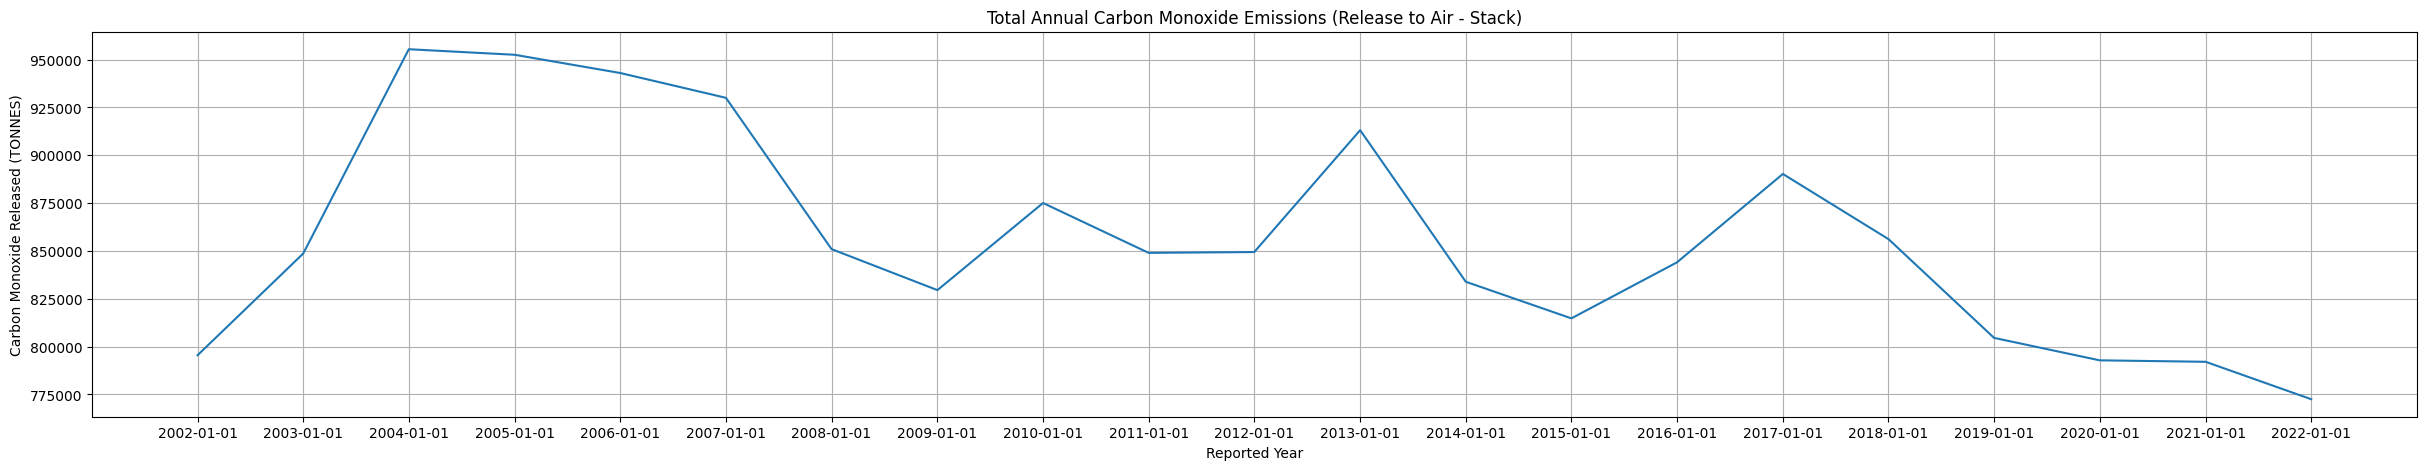

In [ ]:
# @title
# Creating Line Graph for Total Annual Carbon Monoxide Release (Stack - Air)

plt.figure(figsize=(30, 5))
plt.plot(yearly_total_carbon['year'], yearly_total_carbon['release_to_air_stack_point'])
plt.xticks(yearly_total_carbon['year']) # To remove the Integer half steps on graph (Year 2000.5 etc)
plt.title("Total Annual Carbon Monoxide Emissions (Release to Air - Stack)")
plt.xlabel('Reported Year')
plt.ylabel('Carbon Monoxide Released (TONNES)')
plt.grid(True)
plt.show()

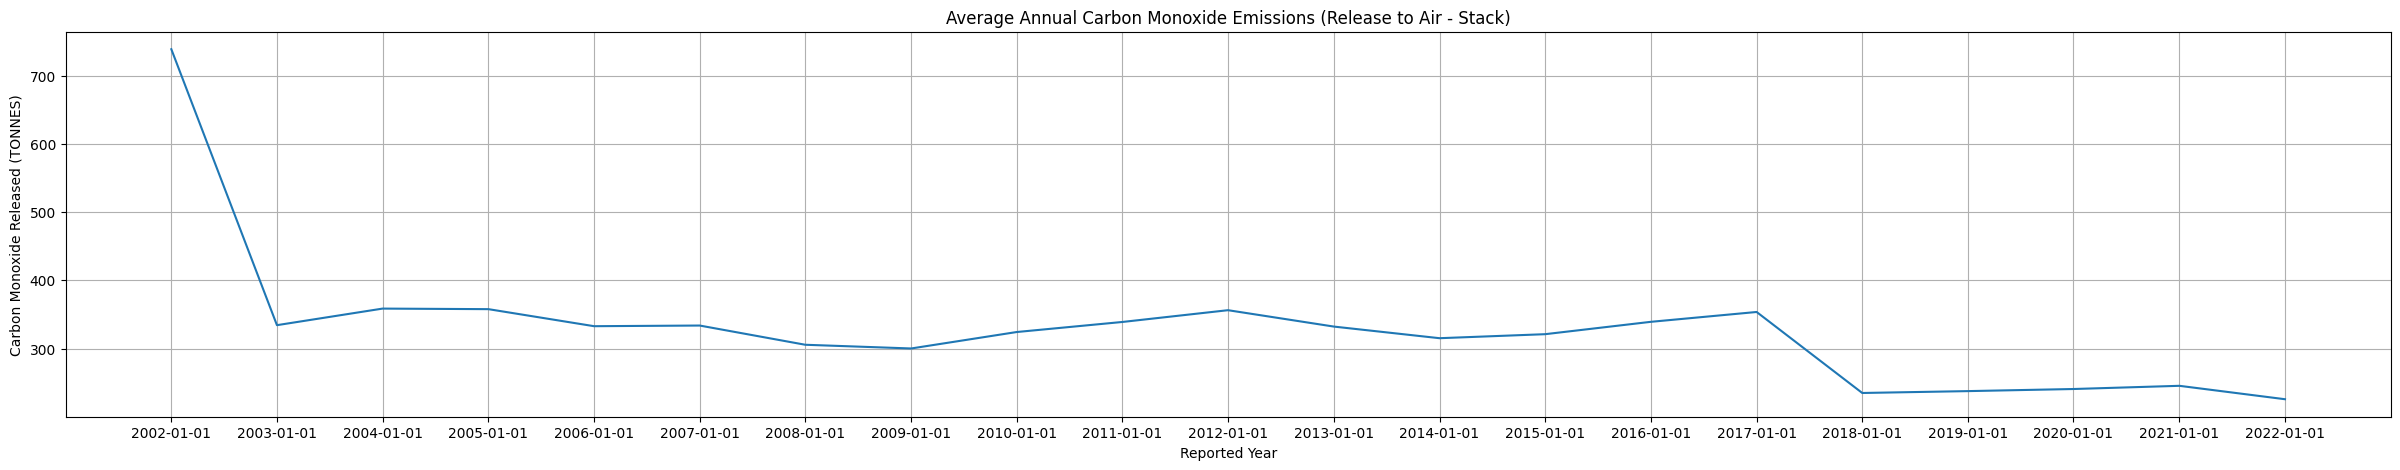

In [ ]:
# @title
# Creating Line Graph for Average Annual Carbon Monoxide Release (Stack - Air)

plt.figure(figsize=(30, 5))
plt.plot(yearly_avg_carbon['year'], yearly_avg_carbon['release_to_air_stack_point'])
plt.xticks(yearly_avg_carbon['year']) # To remove the Integer half steps on graph (Year 2000.5 etc)
plt.title("Average Annual Carbon Monoxide Emissions (Release to Air - Stack)")
plt.xlabel('Reported Year')
plt.ylabel('Carbon Monoxide Released (TONNES)')
plt.grid(True)
plt.show()

Total Sum & Average Annual Emissions for Nitrogen Oxides (NPRI DATASET)

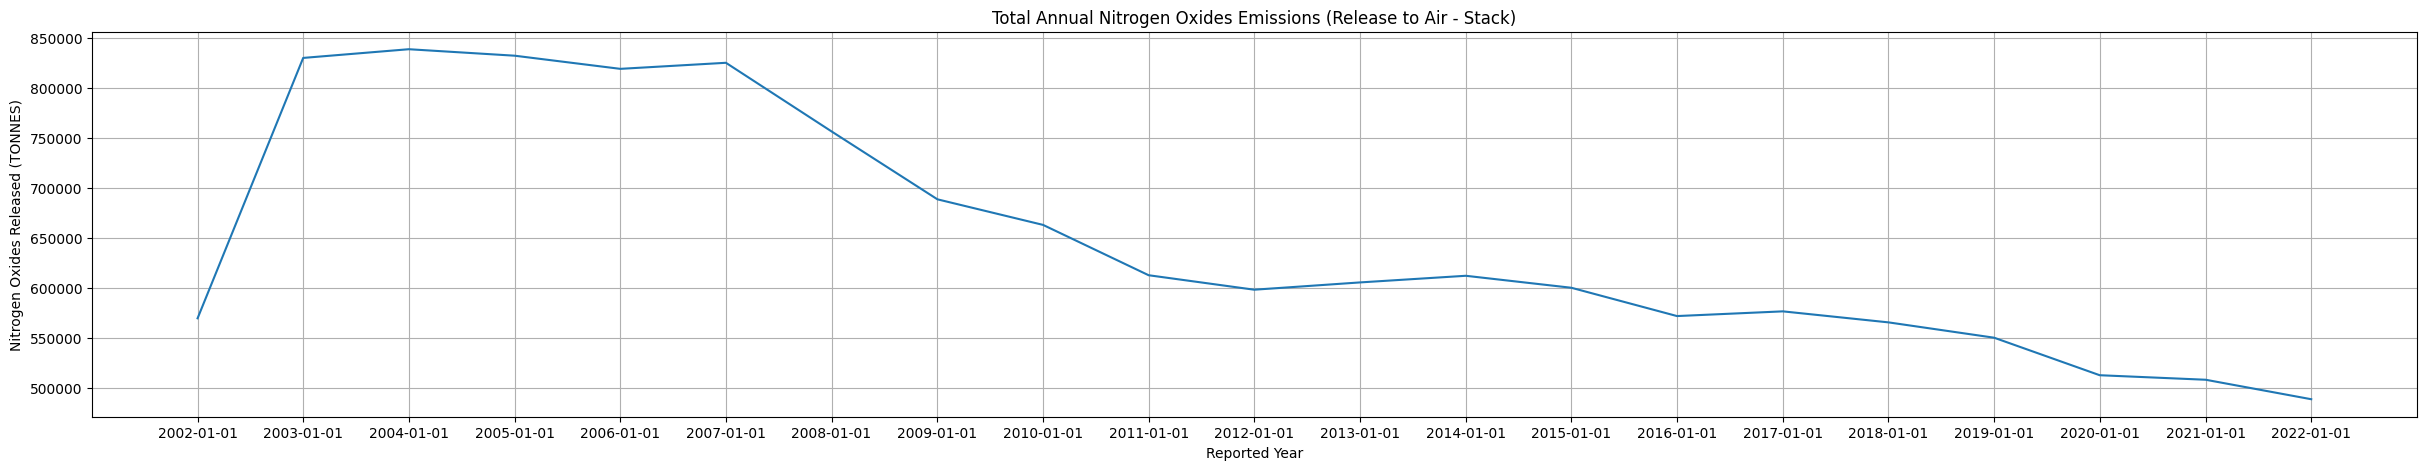

In [ ]:
# @title
# Creating Line Graph for Total Annual Nitrogen Oxides Release (Stack - Air)

plt.figure(figsize=(30, 5))
plt.plot(yearly_total_nitro['year'], yearly_total_nitro['release_to_air_stack_point'])
plt.xticks(yearly_total_nitro['year']) # To remove the Integer half steps on graph (Year 2000.5 etc)
plt.title("Total Annual Nitrogen Oxides Emissions (Release to Air - Stack)")
plt.xlabel('Reported Year')
plt.ylabel('Nitrogen Oxides Released (TONNES)')
plt.grid(True)
plt.show()

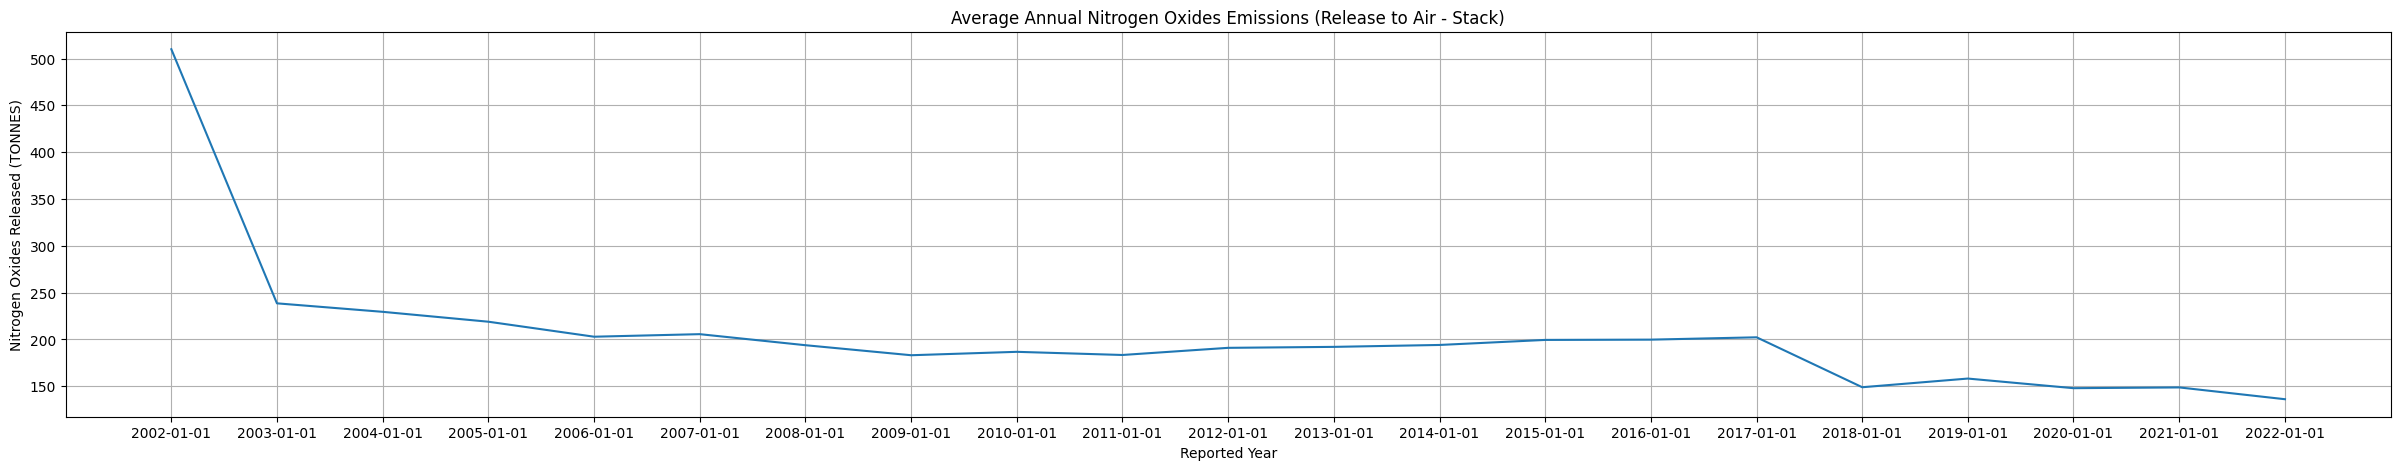

In [ ]:
# @title
# Creating Line Graph for Average Annual Nitrogen Oxides Release (Stack - Air)

plt.figure(figsize=(30, 5))
plt.plot(yearly_avg_nitro['year'], yearly_avg_nitro['release_to_air_stack_point'])
plt.xticks(yearly_avg_nitro['year']) # To remove the Integer half steps on graph (Year 2000.5 etc)
plt.title("Average Annual Nitrogen Oxides Emissions (Release to Air - Stack)")
plt.xlabel('Reported Year')
plt.ylabel('Nitrogen Oxides Released (TONNES)')
plt.grid(True)
plt.show()

#### 1.2.5.1 Outlier detection

NO +CO Dataset

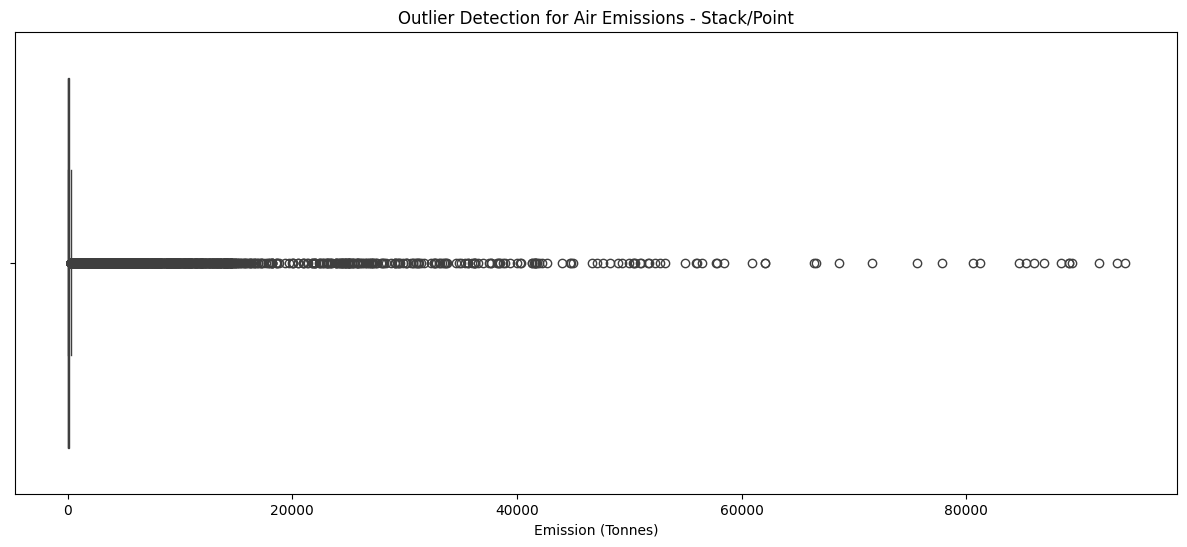

In [ ]:
# @title
# Creating Box Plots for Outlier Visualization (Air Release - Other Non-Point) - NO +CO Dataset

plt.figure(figsize=(15, 6))                                             # Initializing Size of the Canvas
sns.boxplot(x=releases_clean['release_to_air_stack_point'])             # Instantiating Box Plot with Stack/Point Emissions as X-Axis
plt.title("Outlier Detection for Air Emissions - Stack/Point")          # Setting Title for Box Plot Canvas
plt.xlabel("Emission (Tonnes)")                                         # Setting Label for X-Axis
plt.show()                                                              # Rendering Visualization

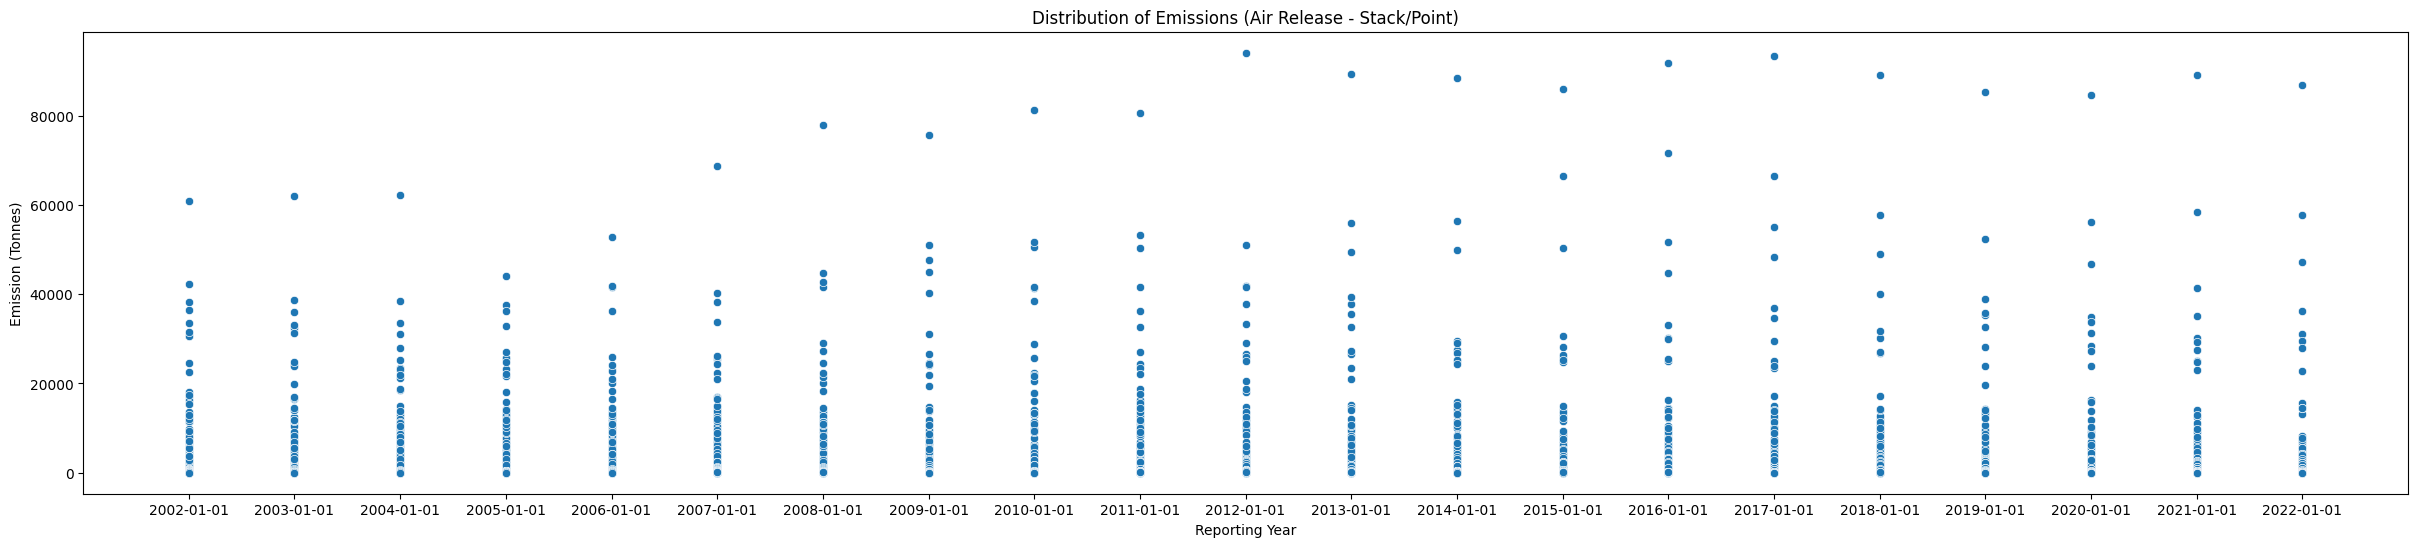

In [ ]:
# @title
# Creating Scatterplot to Visualize Distribution of Emission (Stack/Point) NO +CO Dataset

plt.figure(figsize=(30, 6))                                                                         # Initializing Canvas Size for Scatter Plot
sns.scatterplot(x='year', y='release_to_air_stack_point', data=releases_clean)                      # Instantiating Scatter Plot with X & Y Values (Year & Emission Tonnage)
plt.xticks(sorted(df['year'].unique()))                                                             # Including Every Year Instead of Only 3-Year Increments (Sorted by Year)
plt.title("Distribution of Emissions (Air Release - Stack/Point)")                                  # Setting the Canvas Title
plt.xlabel("Reporting Year")                                                                        # Setting the X-Axis Label
plt.ylabel("Emission (Tonnes)")                                                                     # Setting the Y-Axis Label
plt.show()                                                                                          # Rendering the Canvas (Scatter Plot)

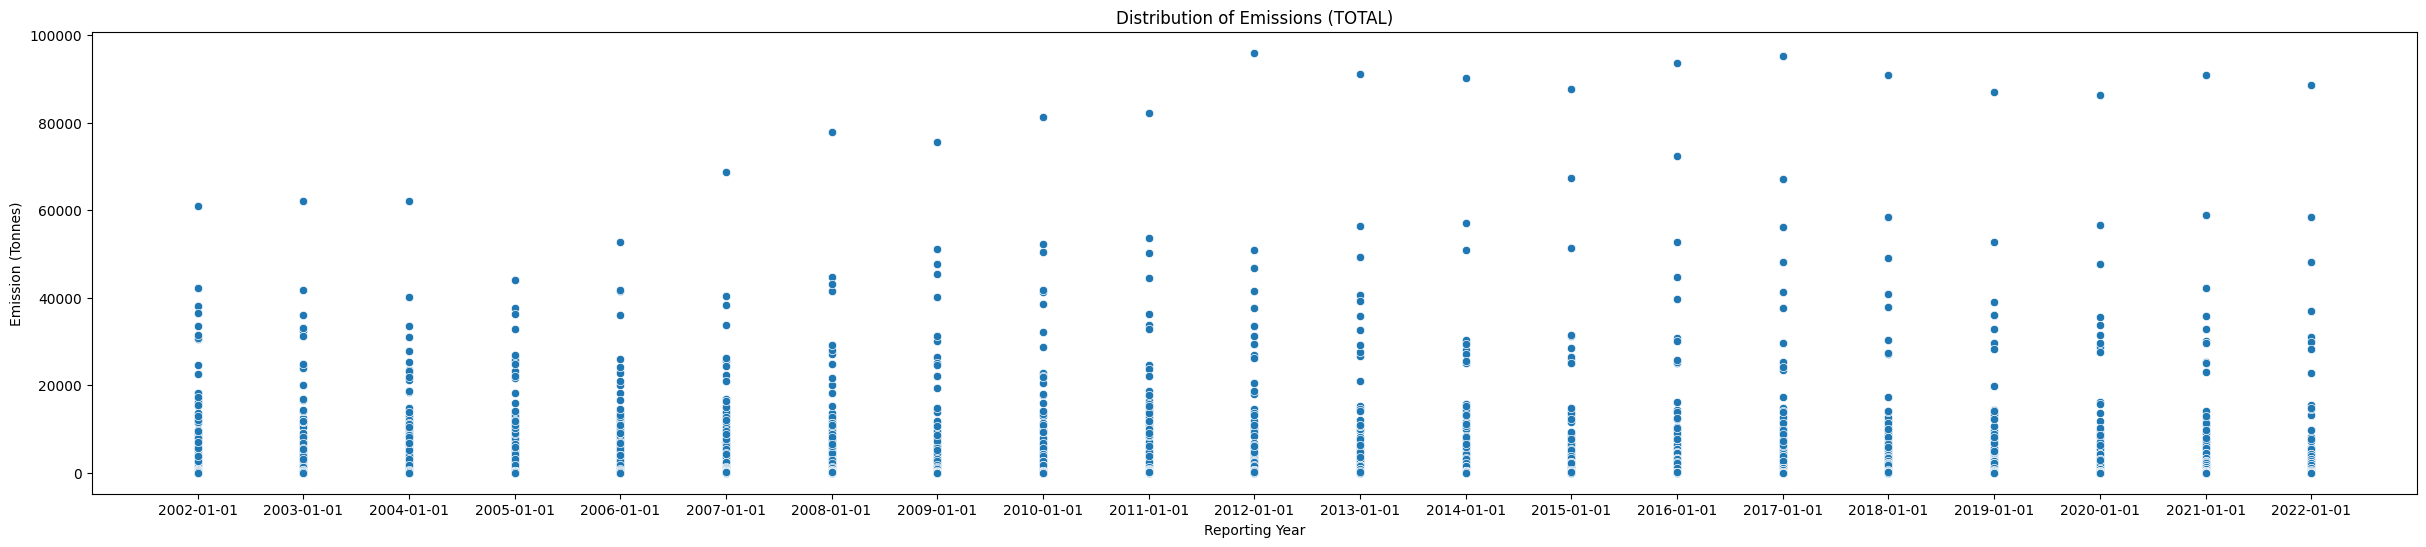

In [ ]:
# @title
# Creating Scatterplot to Visualize Distribution of Emission (Fugitive)NO +CO Dataset

plt.figure(figsize=(30, 6))                                                                      # Initializing Canvas Size for Scatter Plot
sns.scatterplot(x='year', y='total_air_emissions', data=releases_clean)  # Instantiating Scatter Plot with X & Y Values (Year & Emission Tonnage)
plt.xticks(sorted(df['year'].unique()))                                          # Including Every Year Instead of Only 3-Year Increments (Sorted by Year)
plt.title("Distribution of Emissions (TOTAL)")                                  # Setting the Canvas Title
plt.xlabel("Reporting Year")                                                                     # Setting the X-Axis Label
plt.ylabel("Emission (Tonnes)")                                                                  # Setting the Y-Axis Label
plt.show()                                                                                       # Rendering the Canvas (Scatter Plot)

## Section 2 - (External Sources) Data Understanding,Preprocessing and Visualizations

External data sources:

- Energy Consumption Data from StatsCan

    - https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510002901&cubeTimeFrame.startYear=1995&cubeTimeFrame.endYear=2023&referencePeriods=19950101%2C20230101
- Carbon tax prices per province
    
    - not an external data source but rather a set increase of $10/year ($15/year starting  in 2023)

- GDP data

    - https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610040201

- Population data

    - https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000501



###Section 2.1 - Energy Consumption Data from StatsCan


Years: 1995-2023

Energy measured in Terajoules

'...' means data is not available for specific period

'x' means dats is protected privacy laws




In [ ]:
# @title
# energy_use = pd.read_excel('energy consumption by industry adjusted.xlsx', sheet_name = '1995-2023')
energy_use = pd.read_csv('energy_consumption_v3.csv')

In [ ]:
# @title
energy_use.shape

(8589, 4)

In [ ]:
# @title
energy_use.head()

,Year,Province,Sector,Energy Usage
0,1995,Newfoundland and Labrador,Transformed to electricity by utilities,NaN
1,1996,Newfoundland and Labrador,Transformed to electricity by utilities,NaN
2,1997,Newfoundland and Labrador,Transformed to electricity by utilities,NaN
3,1998,Newfoundland and Labrador,Transformed to electricity by utilities,NaN
4,1999,Newfoundland and Labrador,Transformed to electricity by utilities,NaN


Clean the original energy_use

In [ ]:
# @title
energy_cleaned = energy_use.copy()

# Convert "..." to nulls
energy_cleaned = energy_cleaned.replace(['...','x'], np.nan)

# energy_cleaned = energy_cleaned.rename(columns={'Supply and demand characteristics':'Sector'})

In [ ]:
# @title
# Create a new column named year and energy usage to change the shape of the data so it's easy to work with
# energy_cleaned = pd.melt(energy_cleaned, id_vars=['Sector'], var_name='Year', value_name='Energy Usage')


In [ ]:
# @title
energy_cleaned

,Year,Province,Sector,Energy Usage
0,1995,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1
1,1996,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1
2,1997,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1
3,1998,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1
4,1999,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1
...,...,...,...,...
8584,2019,Nunavut,Public administration,360.0
8585,2020,Nunavut,Public administration,245.0
8586,2021,Nunavut,Public administration,275.0
8587,2022,Nunavut,Public administration,287.0


In [ ]:
# @title
# Explore nulls
energy_cleaned.isnull().sum()

,0
Year,0
Province,0
Sector,0
Energy Usage,28


Convert the nulls in the energy usage to the mean values over the years for that sector

In [ ]:
# @title
# Convert 'Energy Usage' to numeric, coercing errors to NaN
energy_cleaned['Energy Usage'] = pd.to_numeric(energy_cleaned['Energy Usage'], errors='coerce')

# Fill nulls with the mean of that 'Sector' across all years
energy_cleaned['Energy Usage'] = energy_cleaned.groupby(['Sector','Province'])['Energy Usage'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
energy_cleaned = energy_cleaned.dropna(subset=['Energy Usage'])

Explore the sectors and select those that are relevant to NPRI. The data was selected using the footnotes and descriptions along with the available sectors (ie. naics sector ids, and titles) from the npri data.

In [ ]:
# @title
relevant_sectors = [
    "Transformed to electricity by utilities",
    "Transformed to electricity by industry",
    "Transformed to steam generation",
    "Total mining and oil and gas extraction 13",
    "Pulp and paper manufacturing 14",
    "Iron and steel manufacturing 15",
    "Aluminum and non-ferrous metal manufacturing 16",
    "Cement manufacturing 17",
    "Refined petroleum products manufacturing 18",
    "Chemicals manufacturing 19",
    "All other manufacturing 20",
    "Construction 22",
    # "Total transportation 23",  # remove
    "Railways",
    # "Total airlines",   # remove
    # "Total marine",    #remove
    "Pipelines 26",
    "Road transport and urban transit 27",
    "Agriculture, fishing, hunting and trapping 28",
    "Transformed to coke and manufactured gases",
    "Transformed to refined petroleum products",
    "Producer consumption 9",
    'Forestry, logging and support activities 21',   #new
    'Public administration 30',      #new
    'Canadian airlines 24'           #new

    # "Total manufacturing",  # remove
    # "Total industrial 12" # remove
]


energy_cleaned = energy_cleaned[energy_cleaned['Sector'].isin(relevant_sectors)].copy() # Add .copy() to avoid SettingWithCopyWarning
energy_cleaned.reset_index(drop=True, inplace=True)




In [ ]:
# @title
# Create groups for the sectors

groups = {'Manufacturing and Industrial':["Pulp and paper manufacturing",#
                                         "Iron and steel manufacturing", #
                                         "Aluminum and non-ferrous metal manufacturing",  #
                                         "Cement manufacturing",  #
                                         "Refined petroleum products manufacturing",#
                                         "Chemicals manufacturing",  #
                                         "All other manufacturing",   #
                                         "Transformed to coke and manufactured gases",#
                                         "Producer consumption"],#

          'Transportation':["Road transport and urban transit",#
                            "Railways",#
                            'Canadian airlines'],  #

          'Mining, Oil and Gas, Energy':["Total mining and oil and gas extraction",#
                                         "Pipelines",#
                                         "Transformed to refined petroleum products",#
                                         "Transformed to electricity by utilities",#
                                         "Transformed to electricity by industry",#
                                         "Transformed to steam generation"],#

          'Agriculture, Forestry, Fishing, Hunting':["Agriculture, fishing, hunting and trapping",  #
                                                     'Forestry, logging and support activities'],  #

          'Public Admin':'Public administration',#

          'Construction':'Construction'#
                        }

# Create a new column based upon the dictionary above

# Create a dictionary to map individual sectors to their groups
sector_to_group = {}

# where group is the key in groups and sectors is the list of sectors
for group, sectors in groups.items():
    if isinstance(sectors, list):
      # Iterate through the list and use each sector as a key assinging it the group value
        for sector in sectors:
            sector_to_group[sector] = group
    # if there is no list and it's a direct path
    else:
        sector_to_group[sectors] = group

# Create the new 'Sector Category' column in energy_use_cleaned
energy_cleaned['Sector Category'] = energy_cleaned['Sector'].map(sector_to_group)
# Drop sectors we dont need
energy_cleaned = energy_cleaned.dropna(subset=['Sector Category'])

# Display the first few rows to check the new column
print(len(energy_cleaned))
display(energy_cleaned.head())

7816


,Year,Province,Sector,Energy Usage,Sector Category
0,1995,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1,"Mining, Oil and Gas, Energy"
1,1996,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1,"Mining, Oil and Gas, Energy"
2,1997,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1,"Mining, Oil and Gas, Energy"
3,1998,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1,"Mining, Oil and Gas, Energy"
4,1999,Newfoundland and Labrador,Transformed to electricity by utilities,14541.1,"Mining, Oil and Gas, Energy"


In [ ]:
# @title
# Create a net energy usage column per sector category and year
energy_cleaned['Net Energy Per Sector'] = energy_cleaned.groupby(['Year', 'Sector Category','Province'])['Energy Usage'].transform('sum')

In [ ]:
# @title
energy_cleaned.dtypes

,0
Year,int64
Province,object
Sector,object
Energy Usage,float64
Sector Category,object
Net Energy Per Sector,float64


In [ ]:
# @title
# Change data types
# keep yeaer as int for ease of manipulation in analysis
energy_cleaned[['Year','Energy Usage', 'Net Energy Per Sector']] = energy_cleaned[['Year','Energy Usage', 'Net Energy Per Sector']].astype(int)
# Change to category
energy_cleaned[['Sector','Sector Category','Province']] = energy_cleaned[['Sector','Sector Category','Province']].astype('category')


In [ ]:
energy_cleaned.dtypes

,0
Year,int64
Province,category
Sector,category
Energy Usage,int64
Sector Category,category
Net Energy Per Sector,int64


In [ ]:
# @title
energy_cleaned

,Year,Province,Sector,Energy Usage,Sector Category,Net Energy Per Sector
0,1995,Newfoundland and Labrador,Transformed to electricity by utilities,14541,"Mining, Oil and Gas, Energy",181097
1,1996,Newfoundland and Labrador,Transformed to electricity by utilities,14541,"Mining, Oil and Gas, Energy",180848
2,1997,Newfoundland and Labrador,Transformed to electricity by utilities,14541,"Mining, Oil and Gas, Energy",182367
3,1998,Newfoundland and Labrador,Transformed to electricity by utilities,14541,"Mining, Oil and Gas, Energy",179289
4,1999,Newfoundland and Labrador,Transformed to electricity by utilities,14541,"Mining, Oil and Gas, Energy",176028
...,...,...,...,...,...,...
8584,2019,Nunavut,Public administration,360,Public Admin,360
8585,2020,Nunavut,Public administration,245,Public Admin,245
8586,2021,Nunavut,Public administration,275,Public Admin,275
8587,2022,Nunavut,Public administration,287,Public Admin,287


In [ ]:
# @title
# Export to csv
energy_cleaned.to_csv('energy_usage_cleaned_v3.csv')

In [ ]:
# @title
# Calculate net energy consumption by year from the reshaped data
net_usage_yearly = energy_cleaned.groupby('Year')['Energy Usage'].sum().reset_index()

# Graph net_usage using Plotly Express
fig = px.line(net_usage_yearly, x='Year', y='Energy Usage', labels={'Year': 'Year', 'Energy Usage': 'Net Energy Usage (Terajoules)'})
fig.update_layout(title='Net Energy Usage Over Time')
fig.show()

Interesting to note the severe decrease during 2020 here - was this a lack of reporting or generally due to the global covid shutdown?

Overall, a general increase in energy consumption

In [ ]:
# @title
# Top 10 sectors per year

top_sectors_per_year = {}

# Get the unique years from the reshaped DataFrame
years = energy_cleaned['Year'].unique()

for year in years:
    # Filter the DataFrame for the current year
    energy_year = energy_cleaned[energy_cleaned['Year'] == year].copy()

    # Sort by Energy Usage in descending order and select the top 10
    top_10_sectors = energy_year.sort_values(by='Energy Usage', ascending=False).head(10)

    # Store the top 10 sectors for the current year
    top_sectors_per_year[year] = top_10_sectors[['Sector', 'Energy Usage']]

# Display the top sectors for each year
for year, top_sectors in top_sectors_per_year.items():
    print(f"Top 10 sectors in {year}:")
    display(top_sectors)
    print("\n")

Top 10 sectors in 1995:


,Sector,Energy Usage
3,Transformed to refined petroleum products,3905693
0,Transformed to electricity by utilities,1138597
5,Producer consumption 9,1056394
13,All other manufacturing 20,511469
7,Pulp and paper manufacturing 14,414926
6,Total mining and oil and gas extraction 13,285171
19,Road transport and urban transit 27,283261
12,Chemicals manufacturing 19,250894
8,Iron and steel manufacturing 15,246996
18,Pipelines 26,245233




Top 10 sectors in 1996:


,Sector,Energy Usage
25,Transformed to refined petroleum products,4087358
22,Transformed to electricity by utilities,1107749
27,Producer consumption 9,1056006
35,All other manufacturing 20,504047
29,Pulp and paper manufacturing 14,420122
28,Total mining and oil and gas extraction 13,308851
41,Road transport and urban transit 27,289098
34,Chemicals manufacturing 19,255050
30,Iron and steel manufacturing 15,251490
40,Pipelines 26,248397




Top 10 sectors in 1997:


,Sector,Energy Usage
47,Transformed to refined petroleum products,4182792
44,Transformed to electricity by utilities,1240169
49,Producer consumption 9,1021025
57,All other manufacturing 20,515068
51,Pulp and paper manufacturing 14,430020
50,Total mining and oil and gas extraction 13,322900
63,Road transport and urban transit 27,303347
56,Chemicals manufacturing 19,262852
62,Pipelines 26,257936
52,Iron and steel manufacturing 15,252703




Top 10 sectors in 1998:


,Sector,Energy Usage
69,Transformed to refined petroleum products,4181566
66,Transformed to electricity by utilities,1420919
71,Producer consumption 9,1101218
79,All other manufacturing 20,480537
73,Pulp and paper manufacturing 14,414653
85,Road transport and urban transit 27,302657
72,Total mining and oil and gas extraction 13,301364
78,Chemicals manufacturing 19,262498
84,Pipelines 26,259953
74,Iron and steel manufacturing 15,256252




Top 10 sectors in 1999:


,Sector,Energy Usage
91,Transformed to refined petroleum products,4244213
88,Transformed to electricity by utilities,1335786
93,Producer consumption 9,1241444
101,All other manufacturing 20,486522
95,Pulp and paper manufacturing 14,436764
107,Road transport and urban transit 27,302547
94,Total mining and oil and gas extraction 13,291145
100,Chemicals manufacturing 19,265533
96,Iron and steel manufacturing 15,260826
106,Pipelines 26,260813




Top 10 sectors in 2000:


,Sector,Energy Usage
113,Transformed to refined petroleum products,4320900
110,Transformed to electricity by utilities,1468547
115,Producer consumption 9,1282089
123,All other manufacturing 20,512299
117,Pulp and paper manufacturing 14,442143
116,Total mining and oil and gas extraction 13,349680
129,Road transport and urban transit 27,290467
122,Chemicals manufacturing 19,260450
118,Iron and steel manufacturing 15,260208
130,"Agriculture, fishing, hunting and trapping 28",234549




Top 10 sectors in 2001:


,Sector,Energy Usage
135,Transformed to refined petroleum products,4438736
132,Transformed to electricity by utilities,1545750
137,Producer consumption 9,1290213
145,All other manufacturing 20,478856
139,Pulp and paper manufacturing 14,404153
138,Total mining and oil and gas extraction 13,346234
151,Road transport and urban transit 27,276398
141,Aluminum and non-ferrous metal manufacturing 16,246074
144,Chemicals manufacturing 19,230624
140,Iron and steel manufacturing 15,229374




Top 10 sectors in 2002:


,Sector,Energy Usage
157,Transformed to refined petroleum products,4554032
154,Transformed to electricity by utilities,1528085
159,Producer consumption 9,1367764
167,All other manufacturing 20,476892
161,Pulp and paper manufacturing 14,405707
160,Total mining and oil and gas extraction 13,367970
173,Road transport and urban transit 27,276441
163,Aluminum and non-ferrous metal manufacturing 16,251005
162,Iron and steel manufacturing 15,246779
166,Chemicals manufacturing 19,230843




Top 10 sectors in 2003:


,Sector,Energy Usage
179,Transformed to refined petroleum products,4717168
176,Transformed to electricity by utilities,1589655
181,Producer consumption 9,1364357
189,All other manufacturing 20,471450
182,Total mining and oil and gas extraction 13,449391
183,Pulp and paper manufacturing 14,397143
195,Road transport and urban transit 27,295962
185,Aluminum and non-ferrous metal manufacturing 16,256064
184,Iron and steel manufacturing 15,241439
196,"Agriculture, fishing, hunting and trapping 28",222461




Top 10 sectors in 2004:


,Sector,Energy Usage
201,Transformed to refined petroleum products,4840821
198,Transformed to electricity by utilities,1521733
203,Producer consumption 9,1419240
211,All other manufacturing 20,476155
204,Total mining and oil and gas extraction 13,440995
205,Pulp and paper manufacturing 14,397764
217,Road transport and urban transit 27,307630
206,Iron and steel manufacturing 15,249763
207,Aluminum and non-ferrous metal manufacturing 16,248307
210,Chemicals manufacturing 19,244575




Top 10 sectors in 2005:


,Sector,Energy Usage
223,Transformed to refined petroleum products,4576638
220,Transformed to electricity by utilities,1473970
225,Producer consumption 9,1249608
233,All other manufacturing 20,489692
226,Total mining and oil and gas extraction 13,456896
227,Pulp and paper manufacturing 14,361542
239,Road transport and urban transit 27,333845
229,Aluminum and non-ferrous metal manufacturing 16,260786
228,Iron and steel manufacturing 15,239811
232,Chemicals manufacturing 19,236129




Top 10 sectors in 2006:


,Sector,Energy Usage
245,Transformed to refined petroleum products,4497837
242,Transformed to electricity by utilities,1435326
247,Producer consumption 9,1286652
248,Total mining and oil and gas extraction 13,487739
255,All other manufacturing 20,458957
261,Road transport and urban transit 27,331561
249,Pulp and paper manufacturing 14,324990
251,Aluminum and non-ferrous metal manufacturing 16,262523
250,Iron and steel manufacturing 15,252083
254,Chemicals manufacturing 19,247701




Top 10 sectors in 2007:


,Sector,Energy Usage
267,Transformed to refined petroleum products,4608065
264,Transformed to electricity by utilities,1498708
269,Producer consumption 9,1314842
270,Total mining and oil and gas extraction 13,619629
277,All other manufacturing 20,473124
283,Road transport and urban transit 27,351504
271,Pulp and paper manufacturing 14,316887
273,Aluminum and non-ferrous metal manufacturing 16,255678
272,Iron and steel manufacturing 15,253972
276,Chemicals manufacturing 19,242816




Top 10 sectors in 2008:


,Sector,Energy Usage
289,Transformed to refined petroleum products,4502944
286,Transformed to electricity by utilities,1409062
291,Producer consumption 9,1287272
292,Total mining and oil and gas extraction 13,635530
299,All other manufacturing 20,452278
305,Road transport and urban transit 27,351502
293,Pulp and paper manufacturing 14,275659
295,Aluminum and non-ferrous metal manufacturing 16,260982
294,Iron and steel manufacturing 15,247006
298,Chemicals manufacturing 19,241383




Top 10 sectors in 2009:


,Sector,Energy Usage
311,Transformed to refined petroleum products,4392714
313,Producer consumption 9,1303120
308,Transformed to electricity by utilities,1231953
314,Total mining and oil and gas extraction 13,656520
321,All other manufacturing 20,417373
327,Road transport and urban transit 27,372504
315,Pulp and paper manufacturing 14,247524
320,Chemicals manufacturing 19,231267
317,Aluminum and non-ferrous metal manufacturing 16,227233
325,Canadian airlines 24,220863




Top 10 sectors in 2010:


,Sector,Energy Usage
333,Transformed to refined petroleum products,4495427
335,Producer consumption 9,1295224
330,Transformed to electricity by utilities,1285979
336,Total mining and oil and gas extraction 13,715139
343,All other manufacturing 20,421301
349,Road transport and urban transit 27,416432
342,Chemicals manufacturing 19,248306
350,"Agriculture, fishing, hunting and trapping 28",242210
339,Aluminum and non-ferrous metal manufacturing 16,237239
337,Pulp and paper manufacturing 14,230570




Top 10 sectors in 2011:


,Sector,Energy Usage
355,Transformed to refined petroleum products,4274927
357,Producer consumption 9,1275912
352,Transformed to electricity by utilities,1211057
358,Total mining and oil and gas extraction 13,869681
365,All other manufacturing 20,443952
371,Road transport and urban transit 27,420849
359,Pulp and paper manufacturing 14,312282
364,Chemicals manufacturing 19,271251
372,"Agriculture, fishing, hunting and trapping 28",266428
361,Aluminum and non-ferrous metal manufacturing 16,248321




Top 10 sectors in 2012:


,Sector,Energy Usage
377,Transformed to refined petroleum products,4409926
379,Producer consumption 9,1270723
374,Transformed to electricity by utilities,1134345
380,Total mining and oil and gas extraction 13,947355
387,All other manufacturing 20,458408
393,Road transport and urban transit 27,442658
386,Chemicals manufacturing 19,272318
394,"Agriculture, fishing, hunting and trapping 28",261852
382,Iron and steel manufacturing 15,231162
383,Aluminum and non-ferrous metal manufacturing 16,229533




Top 10 sectors in 2013:


,Sector,Energy Usage
399,Transformed to refined petroleum products,4272222
401,Producer consumption 9,1323982
396,Transformed to electricity by utilities,1122259
402,Total mining and oil and gas extraction 13,978472
409,All other manufacturing 20,466255
415,Road transport and urban transit 27,427119
408,Chemicals manufacturing 19,284516
416,"Agriculture, fishing, hunting and trapping 28",273461
397,Transformed to electricity by industry,240851
403,Pulp and paper manufacturing 14,226200




Top 10 sectors in 2014:


,Sector,Energy Usage
421,Transformed to refined petroleum products,4203864
423,Producer consumption 9,1324394
418,Transformed to electricity by utilities,1090616
424,Total mining and oil and gas extraction 13,1015583
431,All other manufacturing 20,436336
437,Road transport and urban transit 27,434735
430,Chemicals manufacturing 19,292406
419,Transformed to electricity by industry,285056
438,"Agriculture, fishing, hunting and trapping 28",281839
426,Iron and steel manufacturing 15,231000




Top 10 sectors in 2015:


,Sector,Energy Usage
443,Transformed to refined petroleum products,4322324
445,Producer consumption 9,1319271
440,Transformed to electricity by utilities,1079876
446,Total mining and oil and gas extraction 13,1073688
459,Road transport and urban transit 27,414078
453,All other manufacturing 20,404004
441,Transformed to electricity by industry,306062
460,"Agriculture, fishing, hunting and trapping 28",289633
452,Chemicals manufacturing 19,280909
449,Aluminum and non-ferrous metal manufacturing 16,235341




Top 10 sectors in 2016:


,Sector,Energy Usage
465,Transformed to refined petroleum products,4376356
467,Producer consumption 9,1225975
462,Transformed to electricity by utilities,1052702
468,Total mining and oil and gas extraction 13,1009785
475,All other manufacturing 20,451499
481,Road transport and urban transit 27,375659
463,Transformed to electricity by industry,299753
482,"Agriculture, fishing, hunting and trapping 28",293195
474,Chemicals manufacturing 19,267115
471,Aluminum and non-ferrous metal manufacturing 16,263285




Top 10 sectors in 2017:


,Sector,Energy Usage
487,Transformed to refined petroleum products,4533793
489,Producer consumption 9,1225253
490,Total mining and oil and gas extraction 13,1144846
484,Transformed to electricity by utilities,1004939
497,All other manufacturing 20,404597
503,Road transport and urban transit 27,375880
485,Transformed to electricity by industry,327692
491,Pulp and paper manufacturing 14,312282
504,"Agriculture, fishing, hunting and trapping 28",299188
493,Aluminum and non-ferrous metal manufacturing 16,269379




Top 10 sectors in 2018:


,Sector,Energy Usage
509,Transformed to refined petroleum products,4418808
512,Total mining and oil and gas extraction 13,1289622
511,Producer consumption 9,1228261
506,Transformed to electricity by utilities,953596
519,All other manufacturing 20,397887
525,Road transport and urban transit 27,393115
507,Transformed to electricity by industry,311171
526,"Agriculture, fishing, hunting and trapping 28",310701
523,Canadian airlines 24,278526
515,Aluminum and non-ferrous metal manufacturing 16,263034




Top 10 sectors in 2019:


,Sector,Energy Usage
531,Transformed to refined petroleum products,4311970
534,Total mining and oil and gas extraction 13,1318876
533,Producer consumption 9,1243508
528,Transformed to electricity by utilities,953287
541,All other manufacturing 20,403670
547,Road transport and urban transit 27,370204
548,"Agriculture, fishing, hunting and trapping 28",301673
529,Transformed to electricity by industry,295462
545,Canadian airlines 24,281392
537,Aluminum and non-ferrous metal manufacturing 16,280185




Top 10 sectors in 2020:


,Sector,Energy Usage
553,Transformed to refined petroleum products,3954276
556,Total mining and oil and gas extraction 13,1242800
555,Producer consumption 9,1183499
550,Transformed to electricity by utilities,901313
563,All other manufacturing 20,385922
569,Road transport and urban transit 27,317188
551,Transformed to electricity by industry,300112
570,"Agriculture, fishing, hunting and trapping 28",288686
559,Aluminum and non-ferrous metal manufacturing 16,268154
562,Chemicals manufacturing 19,239812




Top 10 sectors in 2021:


,Sector,Energy Usage
575,Transformed to refined petroleum products,4092522
578,Total mining and oil and gas extraction 13,1344446
577,Producer consumption 9,1205092
572,Transformed to electricity by utilities,916554
585,All other manufacturing 20,394088
591,Road transport and urban transit 27,339012
592,"Agriculture, fishing, hunting and trapping 28",296972
573,Transformed to electricity by industry,290148
581,Aluminum and non-ferrous metal manufacturing 16,278835
584,Chemicals manufacturing 19,248808




Top 10 sectors in 2022:


,Sector,Energy Usage
597,Transformed to refined petroleum products,4305740
600,Total mining and oil and gas extraction 13,1374704
599,Producer consumption 9,1207987
594,Transformed to electricity by utilities,906750
607,All other manufacturing 20,410175
613,Road transport and urban transit 27,355507
595,Transformed to electricity by industry,298656
614,"Agriculture, fishing, hunting and trapping 28",296726
603,Aluminum and non-ferrous metal manufacturing 16,296534
606,Chemicals manufacturing 19,243213




Top 10 sectors in 2023:


,Sector,Energy Usage
619,Transformed to refined petroleum products,4367434
622,Total mining and oil and gas extraction 13,1352807
621,Producer consumption 9,1216497
616,Transformed to electricity by utilities,938633
629,All other manufacturing 20,410663
635,Road transport and urban transit 27,346782
617,Transformed to electricity by industry,333377
636,"Agriculture, fishing, hunting and trapping 28",299421
625,Aluminum and non-ferrous metal manufacturing 16,299066
633,Canadian airlines 24,264626


Interesting to note above that in the last couple of years the tables look fairly the same. Creating our sector categories was a good choice as a lot of these sectors are poping up every year.

/tmp/ipython-input-1011734085.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  energy_grouped_category = energy_cleaned.groupby(['Year', 'Sector Category'])['Net Energy Per Sector'].sum().reset_index()
/tmp/ipython-input-1011734085.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  energy_use_heatmap = energy_grouped_category.pivot_table(index='Sector Category', columns='Year', values='Net Energy Per Sector')


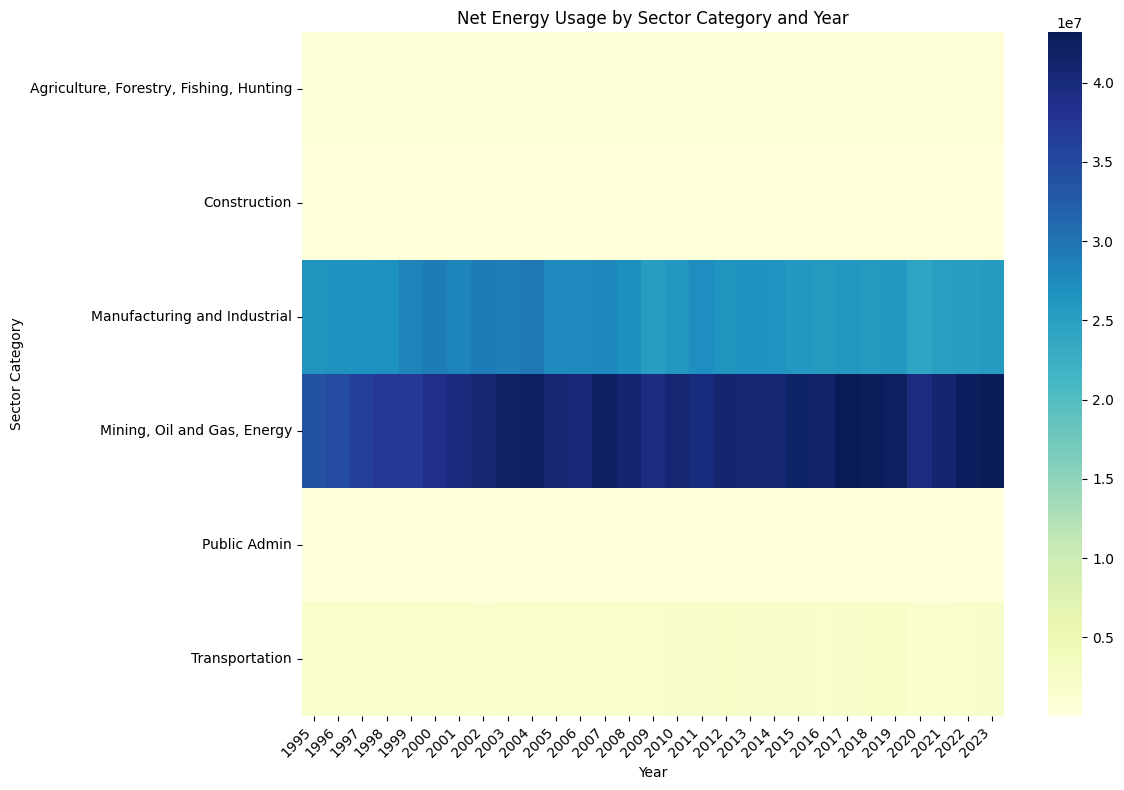

In [ ]:
# @title
# Prepare data for heatmap: Group by 'Year' and 'Sector Category' and sum 'Energy Usage'
energy_grouped_category = energy_cleaned.groupby(['Year', 'Sector Category'])['Net Energy Per Sector'].sum().reset_index()

# Pivot the data for the heatmap: 'Year' as columns, 'Sector Category' as index, 'Energy Usage' as values
energy_use_heatmap = energy_grouped_category.pivot_table(index='Sector Category', columns='Year', values='Net Energy Per Sector')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(energy_use_heatmap, fmt=".0f", cmap="YlGnBu", annot=False) # annot = False as there are too many numbers
plt.title('Net Energy Usage by Sector Category and Year')
plt.xlabel('Year')
plt.ylabel('Sector Category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Manufacturing, transportation, and mining are are top contenders here. With mining, oil and gas increasing throughout the years.

Note: we need to look into these individually in terms of the sector groupings - next steps

In [ ]:
# @title
# Filter energy_cleaned for the years 2015-2023
df_filtered = energy_cleaned[(energy_cleaned['Year'] >= 2015) & (energy_cleaned['Year'] <= 2023)].copy()

# Aggregate by group and year: Group the filtered data by year and Sector Category, and sum the energy usage
df_grouped = df_filtered.groupby(['Year', 'Sector Category'])['Net Energy Per Sector'].sum().reset_index()

# Create a bar chart: Generate a bar chart using Plotly Express
fig = px.bar(df_grouped, x='Year', y='Net Energy Per Sector', color='Sector Category',
             title='Energy Usage by Sector Group (2015-2023)',
             labels={'Year': 'Year', 'Energy Usage': 'Total Energy Usage (Terra Joules)'})

# Update x-axis to show all years as categories
fig.update_xaxes(type='category')

fig.show()

/tmp/ipython-input-1374221798.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_filtered.groupby(['Year', 'Sector Category'])['Net Energy Per Sector'].sum().reset_index()


###Section 2.2 -Population Data


In [ ]:
# @title
#Pull in the Population
df_pop = pd.read_csv("1710000501_databaseLoadingData.csv")

In [ ]:
# @title
df_pop

,REF_DATE,GEO,DGUID,Gender,Age group,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2000,Canada,2021A000011124,Total - gender,All ages,Persons,249,units,0,v466668,1.1.1,30685730,NaN,NaN,NaN,0
1,2001,Canada,2021A000011124,Total - gender,All ages,Persons,249,units,0,v466668,1.1.1,31020855,NaN,NaN,NaN,0
2,2002,Canada,2021A000011124,Total - gender,All ages,Persons,249,units,0,v466668,1.1.1,31359199,NaN,NaN,NaN,0
3,2003,Canada,2021A000011124,Total - gender,All ages,Persons,249,units,0,v466668,1.1.1,31642461,NaN,NaN,NaN,0
4,2004,Canada,2021A000011124,Total - gender,All ages,Persons,249,units,0,v466668,1.1.1,31938807,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2021,Nunavut,2021A000262,Total - gender,All ages,Persons,249,units,0,v480252,15.1.1,40086,NaN,NaN,NaN,0
360,2022,Nunavut,2021A000262,Total - gender,All ages,Persons,249,units,0,v480252,15.1.1,40603,NaN,NaN,NaN,0
361,2023,Nunavut,2021A000262,Total - gender,All ages,Persons,249,units,0,v480252,15.1.1,40916,NaN,NaN,NaN,0
362,2024,Nunavut,2021A000262,Total - gender,All ages,Persons,249,units,0,v480252,15.1.1,41410,NaN,NaN,NaN,0


In [ ]:
# @title
#Pivot the pop table so each column is a province
df_wide = df_pop.pivot(index='REF_DATE', columns='GEO', values='VALUE')
#Calculate each value's YOY change, percentage-wise.
df_pop_yoy = df_wide.pct_change() * 100
#Change all the column values with an extra _YOY after.
df_pop_yoy = df_pop_yoy.add_suffix('_YOY')

In [ ]:
# @title
df_wide

GEO,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
REF_DATE,,,,,,,,,,,,,,
2000,3004198,4039230,30685730,1147313,750517,527966,40480,933821,27498,11683290,136470,7356951,1007565,30431
2001,3058554,4076896,31020855,1151451,749823,522043,40850,932483,28134,11897473,136667,7396014,1000307,30160
2002,3128757,4100504,31359199,1156673,749375,519411,41698,935172,28817,12093412,136882,7441305,996854,30339
2003,3183291,4124447,31642461,1163585,749444,518389,42598,937681,29301,12243641,137231,7485488,996422,30943
2004,3238817,4155630,31938807,1173228,749424,517375,43306,939625,29836,12389641,137682,7535483,997305,31455
2005,3321839,4196076,32242732,1178262,748061,514310,43399,937931,30328,12527581,138067,7581467,993510,31901
2006,3421435,4241793,32571193,1183560,745621,510593,43185,937880,30818,12661953,137869,7631901,992313,32272
2007,3514151,4290987,32888886,1189446,745430,509047,43396,935164,31394,12765133,137709,7692400,1002074,32555
2008,3595875,4349338,33247298,1197767,746875,511569,43385,935965,31898,12883824,138736,7761614,1017368,33084


In [ ]:
# @title
# df_wide = pivoted raw values
# df_pop_yoy = pivoted YOY %

df_interleaved = pd.DataFrame(index=df_wide.index)

for raw_col, yoy_col in zip(df_wide.columns, df_pop_yoy.columns):
    df_interleaved[raw_col] = df_wide[raw_col]
    df_interleaved[f"{raw_col}_YOY"] = df_pop_yoy[yoy_col]

df_interleaved.reset_index(inplace=True)  # make REF_DATE a column

In [ ]:
# @title
df_interleaved

,REF_DATE,Alberta,Alberta_YOY,British Columbia,British Columbia_YOY,Canada,Canada_YOY,Manitoba,Manitoba_YOY,New Brunswick,...,Ontario,Ontario_YOY,Prince Edward Island,Prince Edward Island_YOY,Quebec,Quebec_YOY,Saskatchewan,Saskatchewan_YOY,Yukon,Yukon_YOY
0,2000,3004198,NaN,4039230,NaN,30685730,NaN,1147313,NaN,750517,...,11683290,NaN,136470,NaN,7356951,NaN,1007565,NaN,30431,NaN
1,2001,3058554,1.809335,4076896,0.932504,31020855,1.092120,1151451,0.360669,749823,...,11897473,1.833242,136667,0.144354,7396014,0.530967,1000307,-0.720351,30160,-0.890539
2,2002,3128757,2.295300,4100504,0.579068,31359199,1.090698,1156673,0.453515,749375,...,12093412,1.646896,136882,0.157317,7441305,0.612370,996854,-0.345194,30339,0.593501
3,2003,3183291,1.742993,4124447,0.583904,31642461,0.903282,1163585,0.597576,749444,...,12243641,1.242238,137231,0.254964,7485488,0.593753,996422,-0.043336,30943,1.990837
4,2004,3238817,1.744295,4155630,0.756053,31938807,0.936545,1173228,0.828732,749424,...,12389641,1.192456,137682,0.328643,7535483,0.667892,997305,0.088617,31455,1.654655
5,2005,3321839,2.563343,4196076,0.973282,32242732,0.951585,1178262,0.429073,748061,...,12527581,1.113349,138067,0.279630,7581467,0.610233,993510,-0.380526,31901,1.417899
6,2006,3421435,2.998219,4241793,1.089518,32571193,1.018713,1183560,0.449645,745621,...,12661953,1.072609,137869,-0.143409,7631901,0.665227,992313,-0.120482,32272,1.162973
7,2007,3514151,2.709857,4290987,1.159745,32888886,0.975380,1189446,0.497313,745430,...,12765133,0.814882,137709,-0.116052,7692400,0.792712,1002074,0.983661,32555,0.876921
8,2008,3595875,2.325569,4349338,1.359850,33247298,1.089766,1197767,0.699569,746875,...,12883824,0.929806,138736,0.745776,7761614,0.899771,1017368,1.526235,33084,1.624942
9,2009,3679010,2.311955,4410513,1.406536,33630069,1.151285,1208555,0.900676,749956,...,12998941,0.893500,139873,0.819542,7843915,1.060359,1034791,1.712556,33733,1.961673


###Section 2.3 - GDP data





In [ ]:
# @title

#V1
# df_gdp = pd.read_csv("3610040201_databaseLoadingData.csv")

df_gdp = pd.read_csv("3610040201_databaseLoadingData.csv")


In [ ]:
# @title
df_gdp

,REF_DATE,GEO,DGUID,Prices,North American Industry Classification System (NAICS),UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2000,Newfoundland and Labrador,2016A000210,Chained (2017) dollars,Industrial production [T010],Dollars,81,millions,6,v62464522,1.2.4,5358.8,NaN,NaN,NaN,1
1,2001,Newfoundland and Labrador,2016A000210,Chained (2017) dollars,Industrial production [T010],Dollars,81,millions,6,v62464522,1.2.4,5430.7,NaN,NaN,NaN,1
2,2002,Newfoundland and Labrador,2016A000210,Chained (2017) dollars,Industrial production [T010],Dollars,81,millions,6,v62464522,1.2.4,8471.7,NaN,NaN,NaN,1
3,2003,Newfoundland and Labrador,2016A000210,Chained (2017) dollars,Industrial production [T010],Dollars,81,millions,6,v62464522,1.2.4,9840.6,NaN,NaN,NaN,1
4,2004,Newfoundland and Labrador,2016A000210,Chained (2017) dollars,Industrial production [T010],Dollars,81,millions,6,v62464522,1.2.4,9326.2,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,2020,Nunavut,2016A000262,Chained (2017) dollars,Defence services [9111],Dollars,81,millions,6,v62468478,13.2.300,9.2,NaN,NaN,NaN,1
3571,2021,Nunavut,2016A000262,Chained (2017) dollars,Defence services [9111],Dollars,81,millions,6,v62468478,13.2.300,7.3,NaN,NaN,NaN,1
3572,2022,Nunavut,2016A000262,Chained (2017) dollars,Defence services [9111],Dollars,81,millions,6,v62468478,13.2.300,7.3,NaN,NaN,NaN,1
3573,2023,Nunavut,2016A000262,Chained (2017) dollars,Defence services [9111],Dollars,81,millions,6,v62468478,13.2.300,8.3,NaN,NaN,NaN,1


In [ ]:
# @title
# Pivot the GDP table on the values of province and amount

df_gdp_wide = df_gdp.pivot_table(index=['REF_DATE', 'North American Industry Classification System (NAICS)'], columns='GEO', values='VALUE')

In [ ]:
# @title
df_gdp_yoy = df_gdp_wide.groupby(level='North American Industry Classification System (NAICS)').pct_change() * 100
df_gdp_yoy = df_gdp_yoy.add_suffix('_YOY')

In [ ]:
# @title
df_gdp_interleaved = pd.DataFrame(index=df_gdp_wide.index)

for raw_col, yoy_col in zip(df_gdp_wide.columns, df_gdp_yoy.columns):
    df_gdp_interleaved[raw_col] = df_gdp_wide[raw_col]
    df_gdp_interleaved[f"{raw_col}_YOY"] = df_gdp_yoy[yoy_col]

df_gdp_interleaved.reset_index(inplace=True)  # put REF_DATE and NAICS back as columns

In [ ]:
# @title
df_gdp_interleaved

,REF_DATE,North American Industry Classification System (NAICS),Alberta,Alberta_YOY,British Columbia,British Columbia_YOY,Manitoba,Manitoba_YOY,New Brunswick,New Brunswick_YOY,...,Ontario,Ontario_YOY,Prince Edward Island,Prince Edward Island_YOY,Quebec,Quebec_YOY,Saskatchewan,Saskatchewan_YOY,Yukon,Yukon_YOY
0,2000,"Agriculture, forestry, fishing and hunting [11]",3958.3,NaN,5155.0,NaN,1730.7,NaN,905.7,NaN,...,4553.6,NaN,329.5,NaN,5534.5,NaN,6260.5,NaN,12.3,NaN
1,2000,Construction [23],16984.4,NaN,9347.9,NaN,2316.4,NaN,2176.5,NaN,...,34822.7,NaN,300.3,NaN,16533.8,NaN,3444.9,NaN,164.2,NaN
2,2000,Defence services [9111],1233.4,NaN,1146.3,NaN,544.6,NaN,568.1,NaN,...,4610.3,NaN,13.9,NaN,1661.1,NaN,131.0,NaN,1.3,NaN
3,2000,Durable manufacturing industries [T012],8317.8,NaN,9649.7,NaN,3511.5,NaN,1030.9,NaN,...,66860.0,NaN,207.9,NaN,34904.2,NaN,1206.3,NaN,4.4,NaN
4,2000,Energy sector [T016],48998.3,NaN,11265.3,NaN,2232.2,NaN,1348.7,NaN,...,17920.8,NaN,35.6,NaN,10030.9,NaN,10516.9,NaN,106.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,2024,Manufacturing [31-33],25039.5,-1.095711,15692.9,-6.178294,6860.7,1.054632,3332.4,2.772552,...,92436.4,-4.692166,829.9,2.850415,54671.6,-2.637109,4749.4,-4.630522,19.8,-13.537118
271,2024,"Mining, quarrying, and oil and gas extraction ...",66904.7,3.878478,11759.8,3.939332,1375.5,2.496274,167.3,-1.472320,...,7393.7,3.925841,3.5,2.941176,6159.2,4.639744,13499.6,5.613319,248.7,-31.694589
272,2024,Non-durable manufacturing industries [T011],16131.6,-0.665653,6868.4,-3.385801,3177.4,-0.153977,2173.6,4.570384,...,38639.8,-0.473423,542.4,4.448296,22298.7,-2.873458,2949.3,-1.532452,10.1,-22.900763
273,2024,Transportation and warehousing [48-49],19505.2,3.890321,17068.8,4.074876,4571.9,2.430882,1439.0,4.776467,...,33851.4,3.123115,174.5,4.491018,18398.8,2.550554,3879.3,1.664133,117.7,1.553063


In [ ]:
# @title
#Sum the columns, every other one, from column 3 to the end.

# Select every other column starting from index 2 (which is the 3rd column)
df_gdp_interleaved["Canada"] = df_gdp_interleaved[df_gdp_interleaved.columns[2::2]].sum(axis=1)

In [ ]:
# @title
df_gdp_interleaved

,REF_DATE,North American Industry Classification System (NAICS),Alberta,Alberta_YOY,British Columbia,British Columbia_YOY,Manitoba,Manitoba_YOY,New Brunswick,New Brunswick_YOY,...,Ontario_YOY,Prince Edward Island,Prince Edward Island_YOY,Quebec,Quebec_YOY,Saskatchewan,Saskatchewan_YOY,Yukon,Yukon_YOY,Canada
0,2000,"Agriculture, forestry, fishing and hunting [11]",3958.3,NaN,5155.0,NaN,1730.7,NaN,905.7,NaN,...,NaN,329.5,NaN,5534.5,NaN,6260.5,NaN,12.3,NaN,30444.5
1,2000,Construction [23],16984.4,NaN,9347.9,NaN,2316.4,NaN,2176.5,NaN,...,NaN,300.3,NaN,16533.8,NaN,3444.9,NaN,164.2,NaN,89945.6
2,2000,Defence services [9111],1233.4,NaN,1146.3,NaN,544.6,NaN,568.1,NaN,...,NaN,13.9,NaN,1661.1,NaN,131.0,NaN,1.3,NaN,11872.7
3,2000,Durable manufacturing industries [T012],8317.8,NaN,9649.7,NaN,3511.5,NaN,1030.9,NaN,...,NaN,207.9,NaN,34904.2,NaN,1206.3,NaN,4.4,NaN,126959.9
4,2000,Energy sector [T016],48998.3,NaN,11265.3,NaN,2232.2,NaN,1348.7,NaN,...,NaN,35.6,NaN,10030.9,NaN,10516.9,NaN,106.0,NaN,108533.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,2024,Manufacturing [31-33],25039.5,-1.095711,15692.9,-6.178294,6860.7,1.054632,3332.4,2.772552,...,-4.692166,829.9,2.850415,54671.6,-2.637109,4749.4,-4.630522,19.8,-13.537118,208256.8
271,2024,"Mining, quarrying, and oil and gas extraction ...",66904.7,3.878478,11759.8,3.939332,1375.5,2.496274,167.3,-1.472320,...,3.925841,3.5,2.941176,6159.2,4.639744,13499.6,5.613319,248.7,-31.694589,116584.5
272,2024,Non-durable manufacturing industries [T011],16131.6,-0.665653,6868.4,-3.385801,3177.4,-0.153977,2173.6,4.570384,...,-0.473423,542.4,4.448296,22298.7,-2.873458,2949.3,-1.532452,10.1,-22.900763,95444.5
273,2024,Transportation and warehousing [48-49],19505.2,3.890321,17068.8,4.074876,4571.9,2.430882,1439.0,4.776467,...,3.123115,174.5,4.491018,18398.8,2.550554,3879.3,1.664133,117.7,1.553063,101762.6


In [ ]:
# @title
df_gdp_interleaved["Canada_YOY"] = df_gdp_interleaved.groupby("North American Industry Classification System (NAICS)")["Canada"].pct_change() * 100


In [ ]:
# @title
df_gdp_interleaved

,REF_DATE,North American Industry Classification System (NAICS),Alberta,Alberta_YOY,British Columbia,British Columbia_YOY,Manitoba,Manitoba_YOY,New Brunswick,New Brunswick_YOY,...,Prince Edward Island,Prince Edward Island_YOY,Quebec,Quebec_YOY,Saskatchewan,Saskatchewan_YOY,Yukon,Yukon_YOY,Canada,Canada_YOY
0,2000,"Agriculture, forestry, fishing and hunting [11]",3958.3,NaN,5155.0,NaN,1730.7,NaN,905.7,NaN,...,329.5,NaN,5534.5,NaN,6260.5,NaN,12.3,NaN,30444.5,NaN
1,2000,Construction [23],16984.4,NaN,9347.9,NaN,2316.4,NaN,2176.5,NaN,...,300.3,NaN,16533.8,NaN,3444.9,NaN,164.2,NaN,89945.6,NaN
2,2000,Defence services [9111],1233.4,NaN,1146.3,NaN,544.6,NaN,568.1,NaN,...,13.9,NaN,1661.1,NaN,131.0,NaN,1.3,NaN,11872.7,NaN
3,2000,Durable manufacturing industries [T012],8317.8,NaN,9649.7,NaN,3511.5,NaN,1030.9,NaN,...,207.9,NaN,34904.2,NaN,1206.3,NaN,4.4,NaN,126959.9,NaN
4,2000,Energy sector [T016],48998.3,NaN,11265.3,NaN,2232.2,NaN,1348.7,NaN,...,35.6,NaN,10030.9,NaN,10516.9,NaN,106.0,NaN,108533.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,2024,Manufacturing [31-33],25039.5,-1.095711,15692.9,-6.178294,6860.7,1.054632,3332.4,2.772552,...,829.9,2.850415,54671.6,-2.637109,4749.4,-4.630522,19.8,-13.537118,208256.8,-3.292903
271,2024,"Mining, quarrying, and oil and gas extraction ...",66904.7,3.878478,11759.8,3.939332,1375.5,2.496274,167.3,-1.472320,...,3.5,2.941176,6159.2,4.639744,13499.6,5.613319,248.7,-31.694589,116584.5,3.924982
272,2024,Non-durable manufacturing industries [T011],16131.6,-0.665653,6868.4,-3.385801,3177.4,-0.153977,2173.6,4.570384,...,542.4,4.448296,22298.7,-2.873458,2949.3,-1.532452,10.1,-22.900763,95444.5,-0.961286
273,2024,Transportation and warehousing [48-49],19505.2,3.890321,17068.8,4.074876,4571.9,2.430882,1439.0,4.776467,...,174.5,4.491018,18398.8,2.550554,3879.3,1.664133,117.7,1.553063,101762.6,3.311550


In [ ]:
# @title
#Export the numbers
df_interleaved.to_csv('pop_stats.csv', index=False)
df_gdp_interleaved.to_csv('gdp_stats_v2.csv', index=False)

###Section 2.4 - Merging external data with itself

In [ ]:
# @title
# Read all external files
pop = pd.read_csv('pop_stats.csv')
gdp = pd.read_csv('gdp_stats_v2.csv')
energy = pd.read_csv('energy_usage_cleaned_v3.csv')


First we will merge the gdp and energy data as they both contain sectors. We will create sector categories for gdp data as we have done for the energy data.

In [ ]:
# @title
#Obtain unique sector values for gdp
# Unique values for sector categories
unique_cat_gdp = gdp['North American Industry Classification System (NAICS)'].unique()
print("Here are the unique sectors for the GDP data:\n",unique_cat_gdp)

# Determine range of year for gdp data
unique_year_gdp = gdp['REF_DATE'].unique()
print("\n\nYear ranges for gdp data:\n",unique_year_gdp)

Here are the unique sectors for the GDP data:
 ['Agriculture, forestry, fishing and hunting [11]' 'Construction [23]'
 'Defence services [9111]' 'Durable manufacturing industries [T012]'
 'Energy sector [T016]' 'Industrial production [T010]'
 'Manufacturing [31-33]'
 'Mining, quarrying, and oil and gas extraction [21]'
 'Non-durable manufacturing industries [T011]'
 'Transportation and warehousing [48-49]' 'Utilities [22]']


Year ranges for gdp data:
 [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [ ]:
# @title
# Create a new df for gdp that has filtered years to match energy usage
gdp_cleaned = gdp[gdp['REF_DATE'] < 2024]

gdp_cleaned = gdp_cleaned.rename(columns={'REF_DATE':'Year'})   # Adjust for the column name too

In [ ]:
# @title
# Adjust the names in gdp to match energy usage categories
gdp_dict = {'Agriculture, forestry, fishing and hunting [11]':'Agriculture, Forestry, Fishing, Hunting',

            'Energy sector [T016]': 'Mining, Oil and Gas, Energy',

            'Utilities [22]':'Mining, Oil and Gas, Energy',

            'Industrial production [T010]':'Manufacturing and Industrial',

            'Manufacturing [31-33]':'Manufacturing and Industrial',

            'Durable manufacturing industries [T012]':'Manufacturing and Industrial',

            'Non-durable manufacturing industries [T011]':'Manufacturing and Industrial',

            'Mining, quarrying, and oil and gas extraction [21]':'Mining, Oil and Gas, Energy',

            'Transportation and warehousing [48-49]':'Transportation',

            'Natural gas distribution, water, sewage and other systems [221A]':'Mining, Oil and Gas, Energy',

            'Construction [23]':'Construction',

            'Defence services [9111]':'Public Admin'
            }

# Create a col in gdp data to show dictionary values created above
gdp_cleaned['Sector Category'] = gdp_cleaned['North American Industry Classification System (NAICS)'].map(gdp_dict)

# Sum the rows that have year and sector category the same (ie. the rows with industry as we mapped two different sector cateogories to this)
gdp_cleaned = gdp_cleaned.groupby(['Year', 'Sector Category']).sum().reset_index()

In [ ]:
# @title
gdp_cleaned.head()

,Year,Sector Category,North American Industry Classification System (NAICS),Alberta,Alberta_YOY,British Columbia,British Columbia_YOY,Manitoba,Manitoba_YOY,New Brunswick,...,Prince Edward Island,Prince Edward Island_YOY,Quebec,Quebec_YOY,Saskatchewan,Saskatchewan_YOY,Yukon,Yukon_YOY,Canada,Canada_YOY
0,2000,"Agriculture, Forestry, Fishing, Hunting","Agriculture, forestry, fishing and hunting [11]",3958.3,0.0,5155.0,0.0,1730.7,0.0,905.7,...,329.5,0.0,5534.5,0.0,6260.5,0.0,12.3,0.0,30444.5,0.0
1,2000,Construction,Construction [23],16984.4,0.0,9347.9,0.0,2316.4,0.0,2176.5,...,300.3,0.0,16533.8,0.0,3444.9,0.0,164.2,0.0,89945.6,0.0
2,2000,Manufacturing and Industrial,Durable manufacturing industries [T012]Industr...,109078.0,0.0,61149.8,0.0,20883.2,0.0,11250.4,...,1649.5,0.0,193405.3,0.0,21898.5,0.0,138.9,0.0,792765.1,0.0
3,2000,"Mining, Oil and Gas, Energy","Energy sector [T016]Mining, quarrying, and oil...",91887.6,0.0,24316.4,0.0,5319.3,0.0,3180.4,...,97.2,0.0,23058.1,0.0,23137.2,0.0,224.4,0.0,222912.8,0.0
4,2000,Public Admin,Defence services [9111],1233.4,0.0,1146.3,0.0,544.6,0.0,568.1,...,13.9,0.0,1661.1,0.0,131.0,0.0,1.3,0.0,11872.7,0.0


Lets attempt to merge the gdp and energy usage data. In order to do so we need to adjust for the year columns to match the range within the energy data, we have already created the Sector Category column in both data frames to perform the merge on.

In [ ]:
# Make all columns lower case and snake case
energy.columns = energy.columns.str.lower().str.replace(' ','_')
gdp_cleaned.columns = gdp_cleaned.columns.str.lower().str.replace(' ','_')
pop.columns = pop.columns.str.lower().str.replace(' ','_')


Let's remove the sector columns so we can focus on the aggregate sector categories

In [ ]:
print(len(gdp_cleaned))
gdp_cleaned.head()

2016


,year,sector_category,province,gdp,yoy_gdp
0,2000,"Agriculture, Forestry, Fishing, Hunting",alberta,3958.3,0.0
1,2000,"Agriculture, Forestry, Fishing, Hunting",british_columbia,5155.0,0.0
2,2000,"Agriculture, Forestry, Fishing, Hunting",canada,30444.5,0.0
3,2000,"Agriculture, Forestry, Fishing, Hunting",manitoba,1730.7,0.0
4,2000,"Agriculture, Forestry, Fishing, Hunting",new_brunswick,905.7,0.0


In [ ]:
# change gdp_cleaned to unpivot provinces
gdp_cleaned = gdp_cleaned.drop(columns=['north_american_industry_classification_system_(naics)'])

id_vars_gdp = ['year','sector_category']
value_vars_gdp = [col for col in gdp_cleaned.columns if col not in id_vars_gdp]
gdp_melted = gdp_cleaned.melt(
    id_vars=id_vars_gdp,
    value_vars=value_vars_gdp,
    var_name='province_metric',
    value_name='value'
)

gdp_melted['metric_type'] = gdp_melted['province_metric'].apply(lambda x: 'yoy_gdp' if 'yoy' in x else 'gdp')
gdp_melted['province'] = gdp_melted['province_metric'].str.replace('_yoy','',regex=False)
gdp_cleaned = gdp_melted.pivot_table(
    index=['year','sector_category','province'],
    columns='metric_type',
    values='value'
).reset_index()

gdp_cleaned.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in gdp_cleaned.columns]
gdp_cleaned = gdp_cleaned.drop_duplicates()
gdp_cleaned = gdp_cleaned.reset_index(drop=True)

In [ ]:
energy = energy.drop(columns=['sector', 'energy_usage','unnamed:_0'])
# drop duplicate rows due to transformatino above
energy = energy.drop_duplicates()
energy = energy.reset_index(drop=True)
# adjust years to match gdp
energy = energy[energy['year'] > 1999 ]



In [ ]:
print(len(energy))
energy.head()

1872


,year,province,sector_category,net_energy_per_sector
5,2000,Newfoundland and Labrador,"Mining, Oil and Gas, Energy",179154
6,2001,Newfoundland and Labrador,"Mining, Oil and Gas, Energy",178620
7,2002,Newfoundland and Labrador,"Mining, Oil and Gas, Energy",178460
8,2003,Newfoundland and Labrador,"Mining, Oil and Gas, Energy",181862
9,2004,Newfoundland and Labrador,"Mining, Oil and Gas, Energy",179842


In [ ]:
energy['province'].unique()

array(['Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia',
       'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan',
       'Alberta', 'British Columbia', 'Yukon', 'Northwest Territories',
       'Nunavut'], dtype=object)

In [ ]:
gdp_cleaned['province'].unique()

array(['alberta', 'british_columbia', 'canada', 'manitoba',
       'new_brunswick', 'newfoundland_and_labrador',
       'northwest_territories', 'nova_scotia', 'nunavut', 'ontario',
       'prince_edward_island', 'quebec', 'saskatchewan', 'yukon'],
      dtype=object)

In [ ]:
prov_energy = {
    "Newfoundland and Labrador": "newfoundland_and_labrador",
    "Prince Edward Island": "prince_edward_island",
    "Nova Scotia": "nova_scotia",
    "New Brunswick": "new_brunswick",
    "Quebec": "quebec",
    "Ontario": "ontario",
    "Manitoba": "manitoba",
    "Saskatchewan": "saskatchewan",
    "Alberta": "alberta",
    "British Columbia": "british_columbia",
    "Yukon": "yukon",
    "Northwest Territories": "northwest_territories",
    "Nunavut": "nunavut"
}

energy['province'] = energy['province'].map(prov_energy)

In [ ]:
energy

,year,province,sector_category,net_energy_per_sector
5,2000,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",179154
6,2001,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",178620
7,2002,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",178460
8,2003,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",181862
9,2004,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",179842
...,...,...,...,...
2257,2019,nunavut,Public Admin,360
2258,2020,nunavut,Public Admin,245
2259,2021,nunavut,Public Admin,275
2260,2022,nunavut,Public Admin,287


In [ ]:
print(energy['sector_category'].unique())
print(gdp_cleaned['sector_category'].unique())


['Mining, Oil and Gas, Energy' 'Transportation'
 'Manufacturing and Industrial']
['Agriculture, Forestry, Fishing, Hunting' 'Construction'
 'Manufacturing and Industrial' 'Mining, Oil and Gas, Energy'
 'Public Admin' 'Transportation']


In [ ]:
# @title
# Create a new energy_use that has merged the gdp and energy usage data

# Manually rename columns in gdp_cleaned to add '_GDP' suffix, excluding 'Year' and 'Sector Category'
gdp_cleaned.columns = [col + '_gdp' if col not in ['year', 'sector_category','province'] else col for col in gdp_cleaned.columns]

# Left merge as there are categories in energy that don't exist in the gdp usage data set
gdp_energy = energy.merge(gdp_cleaned, how ='left', on=['sector_category','year','province'])

# Drop the sector column from the energy df, as we've created sector categories to reduce dimensionality within that column
print(len(gdp_energy))
gdp_energy.head()

1872


,year,province,sector_category,net_energy_per_sector,gdp_gdp,yoy_gdp_gdp
0,2000,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",179154,6949.6,0.000000
1,2001,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",178620,7620.5,18.795828
2,2002,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",178460,13464.5,168.474201
3,2003,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",181862,15634.2,34.695723
4,2004,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",179842,14771.8,-8.878101


Create new features for the gdp_energy data

In [ ]:
# Calculate sector-level energy intensity (Energy / GDP)
gdp_energy['sector_net_energy_per_canadian_gdp'] = gdp_energy['net_energy_per_sector'] / gdp_energy['canada_gdp']




KeyError: 'canada_gdp'

Visualize the merged energy and gdp data

In [ ]:
# @title
import plotly.graph_objects as go

# Group by year and calculate the sums of the national gdp and energy usage per sector
canada_trend = gdp_energy.groupby('year')[['canada_gdp', 'net_energy_per_sector']].sum().reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(x=canada_trend['year'], y=canada_trend['canada_gdp'],
                         mode='lines+markers',
                         name='GDP (Canada)',
                         yaxis='y1'))

fig.add_trace(go.Scatter(x=canada_trend['year'], y=canada_trend['net_energy_per_sector'],
                         mode='lines+markers',
                         name='Energy Usage',
                         yaxis='y2'))

fig.update_layout(
    title='Canadian GDP vs Energy Consumption (2000–2023)',
    xaxis=dict(title='Year'),
    yaxis1=dict(
        title='GDP (billions CAD)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Energy Consumption (TJ)',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    hovermode='x unified'
)

fig.show()

GDP and energy has similar peaks and drops

In [ ]:
# @title

# For latest year
latest_year = gdp_energy['year'].max()
subset = gdp_energy[gdp_energy['year'] == latest_year].copy()

# Drop rows where 'sector_net_energy_per_canadian_gdp' is NaN or infinite
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset.dropna(subset=['sector_net_energy_per_canadian_gdp'], inplace=True)

# Aggregate sector_net_energy_per_canadian_gdp by Sector Category for the latest year
subset_grouped = subset.groupby('sector_category')['sector_net_energy_per_canadian_gdp'].sum().reset_index()

# Create the interactive bar chart using Plotly Express
fig = px.bar(subset_grouped, x='sector_category', y='sector_net_energy_per_canadian_gdp',
             title=f'Net Sector Energy by GDP ({latest_year})',
             labels={'sector_category': 'Sector', 'sector_net_energy_per_canadian_gdp': 'Energy / GDP (TJ per billion CAD)'})

# Update x-axis to show all sector categories
fig.update_xaxes(type='category')

# Remove y-axis grid lines (although grouping should remove the need for these lines within bars)
fig.update_layout(yaxis=dict(showgrid=False))


fig.show()

In [ ]:
# @title
# Graph energy intensity over time per sector
fig = px.line(gdp_energy, x='year', y='sector_net_energy_per_canadian_gdp', color='sector_category',
              title='Net Energy per GDP Over Time by Sector (2000–2023)',
              labels={'year': 'Year', 'sector_net_energy_per_canadian_gdp': 'Energy / GDP (TJ per billion CAD)', 'sector_category': 'Sector'})

fig.update_layout(hovermode='x unified')

fig.show()

In [ ]:
# @title
# Correlation between the canadian gdp and energy usage
corr = gdp_energy[['canada_gdp', 'net_energy_per_sector']].corr().iloc[0,1]
print(f"Correlation between sectoral GDP and energy use: {corr:.2f}")

Correlation between sectoral GDP and energy use: 0.47


Now let's merge the gdp and energy data frame with the population data

In [ ]:
# @title
# Filter the year colummn to match the other data
pop['ref_date'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025])

In [ ]:
# @title
# Clean pop data

# Adjust for date
pop_cleaned = pop[pop['ref_date'] < 2024]

# Rename colummsn
pop_cleaned = pop_cleaned.rename(columns={'ref_date':'year'})

In [ ]:
# @title
pop_cleaned.columns

Index(['year', 'alberta', 'alberta_yoy', 'british_columbia',
       'british_columbia_yoy', 'canada', 'canada_yoy', 'manitoba',
       'manitoba_yoy', 'new_brunswick', 'new_brunswick_yoy',
       'newfoundland_and_labrador', 'newfoundland_and_labrador_yoy',
       'northwest_territories', 'northwest_territories_yoy', 'nova_scotia',
       'nova_scotia_yoy', 'nunavut', 'nunavut_yoy', 'ontario', 'ontario_yoy',
       'prince_edward_island', 'prince_edward_island_yoy', 'quebec',
       'quebec_yoy', 'saskatchewan', 'saskatchewan_yoy', 'yukon', 'yukon_yoy'],
      dtype='object')

In [ ]:
# change gdp_cleaned to unpivot provinces
id_vars_gdp = ['year']
value_vars_gdp = [col for col in pop_cleaned.columns if col not in id_vars_gdp]
pop_melted = pop_cleaned.melt(
    id_vars=id_vars_gdp,
    value_vars=value_vars_gdp,
    var_name='province_metric',
    value_name='value'
)

pop_melted['metric_type'] = pop_melted['province_metric'].apply(lambda x: 'yoy_pop' if 'yoy' in x else 'pop')
pop_melted['province'] = pop_melted['province_metric'].str.replace('_yoy','',regex=False)
pop_cleaned = pop_melted.pivot_table(
    index=['year','province'],
    columns='metric_type',
    values='value'
).reset_index()

pop_cleaned.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in pop_cleaned.columns]
pop_cleaned = pop_cleaned.drop_duplicates()
pop_cleaned = pop_cleaned.reset_index(drop=True)

In [ ]:
pop_cleaned.head()

,year,province,pop,yoy_pop
0,2000,alberta,3004198.0,NaN
1,2000,british_columbia,4039230.0,NaN
2,2000,canada,30685730.0,NaN
3,2000,manitoba,1147313.0,NaN
4,2000,new_brunswick,750517.0,NaN


In [ ]:
# @title
# Merge gdp_energy with pop_Cleaned

# Manually rename columns in pop_cleaned to add '_POP' suffix, excluding 'Year'
pop_cleaned.columns = [col + '_pop' if col not in ['year','province'] else col for col in pop_cleaned.columns]

gdp_pop_energy = gdp_energy.merge(pop_cleaned, how = 'left', on = ['year','province'])

gdp_pop_energy.head()

,year,province,sector_category,net_energy_per_sector,gdp_gdp,yoy_gdp_gdp,pop_pop,yoy_pop_pop
0,2000,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",179154,6949.6,0.000000,527966.0,NaN
1,2001,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",178620,7620.5,18.795828,522043.0,-1.121853
2,2002,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",178460,13464.5,168.474201,519411.0,-0.504173
3,2003,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",181862,15634.2,34.695723,518389.0,-0.196761
4,2004,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",179842,14771.8,-8.878101,517375.0,-0.195606


Create new features for the gdp_pop_energy data

In [ ]:
# Calculate Energy Usage Per Capita for Canada (ie. per person)
gdp_pop_energy['canada_energy_per_capita'] = gdp_pop_energy['net_energy_per_sector'] / gdp_pop_energy['canada_pop']



In [ ]:
# @title

# Group by Year and sum the per capita energy usage across sectors to get a national per capita figure
canada_energy_per_capita_yearly = gdp_pop_energy.groupby('year')['canada_energy_per_capita'].sum().reset_index()

# Plot Energy Usage Per Capita Over Time for Canada
fig = px.line(canada_energy_per_capita_yearly, x='year', y='canada_energy_per_capita',
              title='Canadian Energy Usage Per Capita Over Time (2000–2023)',
              labels={'year': 'Year', 'canada_energy_per_capita': 'Energy Usage Per Capita (TJ per person)'})

fig.update_layout(hovermode='x unified')
fig.show()

In [ ]:
# @title
# Calculate Energy Usage Per Capita for each Sector Category in Canada

# Plot Energy Usage Per Capita Over Time by Sector Category for Canada
fig = px.line(gdp_pop_energy, x='year', y='canada_energy_per_capita', color='sector_category',
              title='Canadian Energy Usage Per Capita Over Time by Sector Category (2000–2023)',
              labels={'year': 'Year', 'canada_energy_per_capita': 'Energy Usage Per Capita (TJ per person)', 'sector_category': 'Sector'})

fig.update_layout(hovermode='x unified')
fig.show()

The above EDA demonstrates relations between the GDP, population, and energy consumption data. The primary objective is to interpret these external indicators within the broaded context of the NPRI data, which will be merged within the next phase of analysis. .

By incorporating these external sources, we gin a more holistic understanding of the economic and energy landscape in which facilities reporting to the NPRI operate. Variables such as GDP growth, population size, and sectoral energy intensity can directly influence levels of nitrogen oxides, and carbon monoxies released into the atmosphere.

In [ ]:
# Export merged external data file
gdp_pop_energy.to_csv('merged_external_v3.csv')

### Section P2 : 2.5 - Merging NPRI with External data

In [ ]:
npri = pd.read_csv('npri_processed_naics_v2.csv')
ext = pd.read_csv('merged_external_v3.csv')

In [ ]:
npri.head()

,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_stack_point,total_air_emissions,naics_sector_code,naics_subsector_code,sector_category
0,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,nitrogen oxides,1376.830,1376.830,32,2,Manufacturing and Industrial
1,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,carbon monoxide,1763.150,1763.150,32,2,Manufacturing and Industrial
2,2002,322122,Newsprint mills,MB,50.568600,-96.226700,nitrogen oxides,260.803,260.803,32,2,Manufacturing and Industrial
3,2002,322122,Newsprint mills,MB,50.568600,-96.226700,carbon monoxide,2850.854,2850.854,32,2,Manufacturing and Industrial
4,2002,212231,Lead-zinc ore mining,NB,47.471700,-65.889700,nitrogen oxides,453.570,453.570,21,2,"Mining, Oil and Gas, Energy"


In [ ]:
ext.head()

,Unnamed: 0,year,province,sector_category,net_energy_per_sector,gdp_gdp,yoy_gdp_gdp,pop_pop,yoy_pop_pop
0,0,2000,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",179154,6949.6,0.000000,527966.0,NaN
1,1,2001,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",178620,7620.5,18.795828,522043.0,-1.121853
2,2,2002,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",178460,13464.5,168.474201,519411.0,-0.504173
3,3,2003,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",181862,15634.2,34.695723,518389.0,-0.196761
4,4,2004,newfoundland_and_labrador,"Mining, Oil and Gas, Energy",179842,14771.8,-8.878101,517375.0,-0.195606


In [ ]:
ext_cleaned = ext.drop(columns=['Unnamed: 0'])

In [ ]:
# Minor cleaning
ext = ext.drop(columns=['Unnamed: 0'])
# Drop the aggregated canada columns so we have a better looking table; we will revist these aggregations once npri is merged

# Major cleaning

# Before merging we must adjust the external data so that province is not a column.

# Melt the DataFrame to have one row per province and year and sector
ext_melted = ext.melt(
    id_vars=['year', 'sector_category','net_energy_per_sector','canada_gdp','canada_yoy_gdp','sector_net_energy_per_canadian_gdp','canada_energy_per_capita','canada_pop','canada_yoy_pop'],
    var_name='Variable',  # set name for the new column containing names of unpivoted cols (eg. Alberta_GDP, etc)
    value_name='Value'    # set name for new col that contains values from unpivoted  cols
)

# Separate the 'Variable' column into 'province' and 'metric' (ie. gdp or pop); splits string based on '_' to obtain province names
# n=1 perform 1 split; expland = True to split parts as seperate columns rather than lists
ext_melted[['province', 'metric']] = ext_melted['Variable'].str.rsplit('_', n=1, expand=True)

# Create a separate YOY column and clean the province name
ext_melted['yoy_metric'] = ext_melted['province'].str.contains('_yoy')
ext_melted['province'] = ext_melted['province'].str.replace('_yoy', '')

# Pivot the DataFrame to have 'province', 'gdp', and 'population' columns, including the YOY metrics
ext_cleaned = ext_melted.pivot_table(
    index=['year', 'sector_category', 'net_energy_per_sector','canada_gdp',
          'canada_yoy_gdp','sector_net_energy_per_canadian_gdp','canada_energy_per_capita',
           'canada_pop','canada_yoy_pop','province'],
    columns=['metric', 'yoy_metric'],  # new cols
    values='Value'
).reset_index()

# Flatten the multi-level columns as they appear as for ex. ('GDP',False) from steps above
ext_cleaned.columns = ['_'.join(map(str, col)).strip('_') for col in ext_cleaned.columns.values]

ext_cleaned = ext_cleaned.rename(columns={
    'gdp_False': 'gdp',
    'gdp_True': 'yoy_gdp',
    'pop_False': 'pop',
    'pop_True': 'yoy_pop'
})

ext_cleaned = ext_cleaned.reset_index(drop=True)
ext_cleaned.tail()

,year,sector_category,net_energy_per_sector,canada_gdp,canada_yoy_gdp,sector_net_energy_per_canadian_gdp,canada_energy_per_capita,canada_pop,canada_yoy_pop,province,gdp,yoy_gdp,pop,yoy_pop
1789,2023,Transportation,699671,98500.7,7.15543,7.103208,0.01747,40049088,2.821444,ontario,32826.2,8.878813,15632481.0,3.144960
1790,2023,Transportation,699671,98500.7,7.15543,7.103208,0.01747,40049088,2.821444,prince_edward_island,167.0,0.000000,173734.0,3.907895
1791,2023,Transportation,699671,98500.7,7.15543,7.103208,0.01747,40049088,2.821444,quebec,17941.2,6.009147,8821696.0,1.750100
1792,2023,Transportation,699671,98500.7,7.15543,7.103208,0.01747,40049088,2.821444,saskatchewan,3815.8,7.717931,1210257.0,2.668910
1793,2023,Transportation,699671,98500.7,7.15543,7.103208,0.01747,40049088,2.821444,yukon,115.9,13.294233,45419.0,3.533247


Some more cleaning before we merge:
- create a dictionary of provinces for external sources so they can match with npri

In [ ]:
print("Unique provinces for npri:",npri['province'].unique())
print("\nUnique provinces for external sources:\n\n",ext_cleaned['province'].unique())

Unique provinces for npri: ['AB' 'MB' 'NB' 'ON' 'QC' 'BC' 'SK' 'NT' 'NS' 'NU' 'PE' 'NL' 'YT']

Unique provinces for external sources:

 ['newfoundland_and_labrador' 'prince_edward_island' 'nova_scotia'
 'new_brunswick' 'quebec' 'ontario' 'manitoba' 'saskatchewan' 'alberta'
 'british_columbia' 'yukon' 'northwest_territories' 'nunavut']


In [ ]:
prov_dict = {
    'alberta': 'AB',
    'manitoba': 'MB',
    'new_brunswick': 'NB',
    'ontario': 'ON',
    'quebec': 'QC',
    'british_columbia': 'BC',
    'saskatchewan': 'SK',
    'northwest_territories': 'NT',
    'nova_scotia': 'NS',
    'nunavut': 'NU',
    'prince_edward_island': 'PE',
    'newfoundland_and_labrador': 'NL',
    'yukon': 'YT'
}

ext_cleaned['province'] = ext_cleaned['province'].astype(str)
# Apply the dict
ext_cleaned['province'] = ext_cleaned['province'].map(prov_dict)


ext_cleaned = ext_cleaned.reset_index(drop=True)

In [ ]:
npri.dtypes

,0
year,int64
naics_code,int64
naics_title,object
province,object
latitude,float64
longitude,float64
substance_name,object
release_to_air_stack_point,float64
total_air_emissions,float64
naics_sector_code,int64


In [ ]:
ext_cleaned.dtypes

,0
year,int64
province,object
sector_category,object
net_energy_per_sector,int64
gdp_gdp,float64
yoy_gdp_gdp,float64
pop_pop,float64
yoy_pop_pop,float64


In [ ]:
#Convert year data type - keep as int not cactegory
npri['year'] = npri['year'].astype(int)
ext_cleaned['year'] = ext_cleaned['year'].astype(int)

#categories
cat_cols_npri = ['sector_category','province','naics_code','naics_title','substance_name','naics_sector_code','naics_subsector_code']
npri[cat_cols_npri] = npri[cat_cols_npri].astype('category')

cat_cols_ext = ['sector_category','province']
ext_cleaned[cat_cols_ext] = ext_cleaned[cat_cols_ext].astype('category')



Now we can merge the npri with external sources

In [ ]:
npri_ext = npri.merge(ext_cleaned, on = ['year','sector_category','province'], how='left')

npri_ext.head()

,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_stack_point,total_air_emissions,naics_sector_code,naics_subsector_code,sector_category,net_energy_per_sector,gdp_gdp,yoy_gdp_gdp,pop_pop,yoy_pop_pop
0,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,nitrogen oxides,1376.830,1376.830,32,2,Manufacturing and Industrial,987501.0,103963.4,-6.283807,3128757.0,2.295300
1,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,carbon monoxide,1763.150,1763.150,32,2,Manufacturing and Industrial,987501.0,103963.4,-6.283807,3128757.0,2.295300
2,2002,322122,Newsprint mills,MB,50.568600,-96.226700,nitrogen oxides,260.803,260.803,32,2,Manufacturing and Industrial,40225.0,20454.4,10.661823,1156673.0,0.453515
3,2002,322122,Newsprint mills,MB,50.568600,-96.226700,carbon monoxide,2850.854,2850.854,32,2,Manufacturing and Industrial,40225.0,20454.4,10.661823,1156673.0,0.453515
4,2002,212231,Lead-zinc ore mining,NB,47.471700,-65.889700,nitrogen oxides,453.570,453.570,21,2,"Mining, Oil and Gas, Energy",1300893.0,3064.6,-28.910692,749375.0,-0.059747


In [ ]:
len(npri_ext)

132427

In [ ]:
len(npri_ext[npri_ext['sector_category'] == 'Other'])

2437

In [ ]:
npri_ext.isnull().sum()

,0
year,0
naics_code,0
naics_title,0
province,0
latitude,0
longitude,0
substance_name,0
release_to_air_stack_point,4297
total_air_emissions,0
naics_sector_code,0


As we can see through the length of the null values for columns such as gdp, pop etc these pertain to our 'Other' sector category which exist in npri but not our external sources.

In [ ]:
npri_ext.to_csv('npri_ext_v3.csv')

##Section P2 3 - Feature Engineering

In [ ]:
# start off by reading the file so we can start from here and not have to reload everything
npri_ext = pd.read_csv('npri_ext_v3.csv')
npri_ext.head()

,Unnamed: 0,year,naics_code,naics_title,province,latitude,longitude,substance_name,release_to_air_stack_point,total_air_emissions,naics_sector_code,naics_subsector_code,sector_category,net_energy_per_sector,gdp_gdp,yoy_gdp_gdp,pop_pop,yoy_pop_pop
0,0,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,nitrogen oxides,1376.830,1376.830,32,2,Manufacturing and Industrial,987501.0,103963.4,-6.283807,3128757.0,2.295300
1,1,2002,322112,Chemical pulp mills,AB,54.923116,-112.861867,carbon monoxide,1763.150,1763.150,32,2,Manufacturing and Industrial,987501.0,103963.4,-6.283807,3128757.0,2.295300
2,2,2002,322122,Newsprint mills,MB,50.568600,-96.226700,nitrogen oxides,260.803,260.803,32,2,Manufacturing and Industrial,40225.0,20454.4,10.661823,1156673.0,0.453515
3,3,2002,322122,Newsprint mills,MB,50.568600,-96.226700,carbon monoxide,2850.854,2850.854,32,2,Manufacturing and Industrial,40225.0,20454.4,10.661823,1156673.0,0.453515
4,4,2002,212231,Lead-zinc ore mining,NB,47.471700,-65.889700,nitrogen oxides,453.570,453.570,21,2,"Mining, Oil and Gas, Energy",1300893.0,3064.6,-28.910692,749375.0,-0.059747


In [ ]:
npri_ext = npri_ext.drop(columns=['Unnamed: 0', 'release_to_air_stack_point'])
npri_ext = npri_ext.rename(columns={'gdp_gdp':'gdp','yoy_gdp_gdp':'yoy_gdp','pop_pop':'pop','yoy_pop_pop':'yoy_pop'})

Lets try to adjust our data so the rows are more meaningful. Currently each row represents a single companie's npri report for that year along with its assigned sector and corresponding GDP and population information. However, this level of granularity is not ideal for a rolling-window regression model designed to evaluate the effect of the federal carbon pricing system. Since the carbon price is applied at the provincial level and its impacts are felt at the sectoral level, it makes more sense for our dataset to reflect these broader structural units. By aggregating emissions across all facilities within eac province-sector-year, we shift the grain of our data from individual copmany reporting to the level where policy and economic/social factors operate. This allows us to model changes in total emissions more accurately, reduces noise caused by facility level changes, and ensures that each row represents a policy relevenat unit for analyzing how carbon pricing has influences emissions over time.

As we can see here there are 117899 rows of data that are duplicated based off the year-province-naics code-substance grain

In [ ]:
len(npri_ext)

132427

In [ ]:
dups = npri_ext[["year","sector_category","province","substance_name"]].duplicated()
len(npri_ext[dups])

130518

Aggregate rows so that we adjust our grain to have rows that represent total emissions per year per sector per province.

Note: since nitrogen and carbon emissions behave differently we are keeping these emissions seperate

In [ ]:
npri_ext.columns

Index(['year', 'naics_code', 'naics_title', 'province', 'latitude',
       'longitude', 'substance_name', 'total_air_emissions',
       'naics_sector_code', 'naics_subsector_code', 'sector_category',
       'net_energy_per_sector', 'gdp', 'yoy_gdp', 'pop', 'yoy_pop'],
      dtype='object')

In [ ]:
grouped_cols = ['year','province','sector_category','substance_name','naics_code','naics_title','naics_sector_code','naics_subsector_code']

agg_npri = npri_ext.groupby(grouped_cols, as_index=False).agg({
                                                                'total_air_emissions':'sum',
                                                                'gdp':'first',
                                                                'yoy_gdp':'first',
                                                                'pop':'first',
                                                                'yoy_pop':'first',
                                                                'net_energy_per_sector':'first',
})

print("Length of new aggregated dataset:",len(agg_npri))
agg_npri.head()

Length of new aggregated dataset: 14528


,year,province,sector_category,substance_name,naics_code,naics_title,naics_sector_code,naics_subsector_code,total_air_emissions,gdp,yoy_gdp,pop,yoy_pop,net_energy_per_sector
0,2002,AB,Manufacturing and Industrial,carbon monoxide,311214,Rice milling and malt manufacturing,31,1,32.200,103963.4,-6.283807,3128757.0,2.2953,987501.0
1,2002,AB,Manufacturing and Industrial,carbon monoxide,311224,Oilseed processing,31,1,20.754,103963.4,-6.283807,3128757.0,2.2953,987501.0
2,2002,AB,Manufacturing and Industrial,carbon monoxide,311310,Sugar manufacturing,31,1,184.300,103963.4,-6.283807,3128757.0,2.2953,987501.0
3,2002,AB,Manufacturing and Industrial,carbon monoxide,311511,Fluid milk manufacturing,31,1,1.397,103963.4,-6.283807,3128757.0,2.2953,987501.0
4,2002,AB,Manufacturing and Industrial,carbon monoxide,311515,"Butter, Cheese, and Dry and Condensed Dairy Pr...",31,1,0.658,103963.4,-6.283807,3128757.0,2.2953,987501.0


Now we need to adjust our grain so that each row is represents the full emissions profile (ie. both carbon and nitrogen as columns)-so now we'll have one row representing one row per time period per group not per pollutant.

In [ ]:
# Pivot df

ind_cols = ['year','province','sector_category','naics_code','naics_title','naics_sector_code','naics_subsector_code','gdp','yoy_gdp','pop','yoy_pop','net_energy_per_sector']
pivot_npri = (
    agg_npri.pivot_table(
        index= ind_cols,
        columns='substance_name',
        values = 'total_air_emissions',
        aggfunc='sum'
    )
    .reset_index()
)


In [ ]:
pivot_npri.head()

substance_name,year,province,sector_category,naics_code,naics_title,naics_sector_code,naics_subsector_code,gdp,yoy_gdp,pop,yoy_pop,net_energy_per_sector,carbon monoxide,nitrogen oxides
0,2002,AB,Manufacturing and Industrial,311119,Other animal food manufacturing,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,NaN,10.060
1,2002,AB,Manufacturing and Industrial,311211,Flour milling,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,NaN,32.760
2,2002,AB,Manufacturing and Industrial,311214,Rice milling and malt manufacturing,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,32.200,36.700
3,2002,AB,Manufacturing and Industrial,311224,Oilseed processing,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,20.754,24.707
4,2002,AB,Manufacturing and Industrial,311310,Sugar manufacturing,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,184.300,35.700


In [ ]:
# drop index name
pivot_npri.columns.name = None
pivot_npri.head()

,year,province,sector_category,naics_code,naics_title,naics_sector_code,naics_subsector_code,gdp,yoy_gdp,pop,yoy_pop,net_energy_per_sector,carbon monoxide,nitrogen oxides
0,2002,AB,Manufacturing and Industrial,311119,Other animal food manufacturing,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,NaN,10.060
1,2002,AB,Manufacturing and Industrial,311211,Flour milling,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,NaN,32.760
2,2002,AB,Manufacturing and Industrial,311214,Rice milling and malt manufacturing,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,32.200,36.700
3,2002,AB,Manufacturing and Industrial,311224,Oilseed processing,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,20.754,24.707
4,2002,AB,Manufacturing and Industrial,311310,Sugar manufacturing,31,1,103963.4,-6.283807,3128757.0,2.2953,987501.0,184.300,35.700


In [ ]:
pivot_npri.columns

Index(['year', 'province', 'sector_category', 'naics_code', 'naics_title',
       'naics_sector_code', 'naics_subsector_code', 'gdp', 'yoy_gdp', 'pop',
       'yoy_pop', 'net_energy_per_sector', 'carbon monoxide',
       'nitrogen oxides'],
      dtype='object')

In [ ]:
### NEW : TOTAL EMISSIONS
pivot_npri['total_emissions'] = (
    pivot_npri['carbon monoxide'].fillna(0) +
    pivot_npri['nitrogen oxides'].fillna(0)
)


In [ ]:
pivot_npri.iloc[0]

,0
year,2002
province,AB
sector_category,Manufacturing and Industrial
naics_code,311119
naics_title,Other animal food manufacturing
naics_sector_code,31
naics_subsector_code,1
gdp,103963.4
yoy_gdp,-6.283807
pop,3128757.0


In [ ]:
len(pivot_npri)

7557

In [ ]:
# # Merge back with og cols
# cols = ['year','province','sector_category','gdp','yoy_gdp','pop','yoy_pop','net_energy_per_sector'
#         ]


# # Create new df representing the unique values for cols
# df = agg_npri[cols].drop_duplicates()

# # Merge df with pivot df
# pivot_npri = pivot_npri.merge(df,on=['year','province','sector_category'],how='left')
# pivot_npri.head()

Initial Normalization:
- add columns for emissions intensities (ie. per-unit normalization for emissions and gdp/pop)

In [ ]:
# Gdp
pivot_npri['no_per_gdp'] = pivot_npri['nitrogen oxides']/pivot_npri['gdp']
pivot_npri['co_per_gdp'] = pivot_npri['carbon monoxide']/pivot_npri['gdp']
pivot_npri['total_emissions_per_gdp'] = pivot_npri['total_emissions']/pivot_npri['gdp']


# Pop
pivot_npri['no_per_capita'] = pivot_npri['nitrogen oxides']/pivot_npri['pop']
pivot_npri['co_per_capita'] = pivot_npri['carbon monoxide']/pivot_npri['pop']
pivot_npri['total_emissions_per_gdp'] = pivot_npri['total_emissions']/pivot_npri['pop']



Now let's bring in the carbon pricing policy. We will be encoding:
- when the federal system starts
- how strong the price signal is

In [ ]:
# Policy indicator - boolean values
pivot_npri['carbon_policy'] = (pivot_npri['year'] >=2019).astype(int)

In [ ]:
# Create a map of carbon pricing for each year
# Add future values to use later during modeling - note: these will not have an impact on current data
carbon_price_map = {
    2019:20,
    2020:30,
    2021:40,
    2022:50,
    2023:65,
    2024:80,
    2025:95,
    2026:110,
    2027:125,
    2028:140,
    2029:155,
    2030:170
}

pivot_npri['carbon_price'] = pivot_npri['year'].map(carbon_price_map).fillna(0)
pivot_npri.head()

,year,province,sector_category,naics_code,naics_title,naics_sector_code,naics_subsector_code,gdp,yoy_gdp,pop,...,carbon monoxide,nitrogen oxides,total_emissions,no_per_gdp,co_per_gdp,total_emissions_per_gdp,no_per_capita,co_per_capita,carbon_policy,carbon_price
0,2002,AB,Manufacturing and Industrial,311119,Other animal food manufacturing,31,1,103963.4,-6.283807,3128757.0,...,NaN,10.060,10.060,0.000097,NaN,0.000003,0.000003,NaN,0,0.0
1,2002,AB,Manufacturing and Industrial,311211,Flour milling,31,1,103963.4,-6.283807,3128757.0,...,NaN,32.760,32.760,0.000315,NaN,0.000010,0.000010,NaN,0,0.0
2,2002,AB,Manufacturing and Industrial,311214,Rice milling and malt manufacturing,31,1,103963.4,-6.283807,3128757.0,...,32.200,36.700,68.900,0.000353,0.000310,0.000022,0.000012,0.000010,0,0.0
3,2002,AB,Manufacturing and Industrial,311224,Oilseed processing,31,1,103963.4,-6.283807,3128757.0,...,20.754,24.707,45.461,0.000238,0.000200,0.000015,0.000008,0.000007,0,0.0
4,2002,AB,Manufacturing and Industrial,311310,Sugar manufacturing,31,1,103963.4,-6.283807,3128757.0,...,184.300,35.700,220.000,0.000343,0.001773,0.000070,0.000011,0.000059,0,0.0


Now let's further encode the sectors that are high emitters

In [ ]:
# Lets visualize which sectors are top emitters

import plotly.express as px

# Group by sector_category and sum the emissions across all years
emissions_by_sector_overall = pivot_npri.groupby(['sector_category'])[    ['carbon monoxide', 'nitrogen oxides']].sum().reset_index()

# Melt the DataFrame to prepare for plotting side-by-side bars
emissions_melted_overall = emissions_by_sector_overall.melt(
    id_vars=['sector_category'],
    value_vars=['carbon monoxide', 'nitrogen oxides'],
    var_name='substance_name',
    value_name='total_emissions'
)

# Create the interactive bar chart
fig = px.bar(
    emissions_melted_overall,
    x='sector_category',
    y='total_emissions',
    color='substance_name',
    barmode='group',
    title='Total NO and CO Emissions by Sector (All Years)',
    labels={
        'sector_category': 'Sector Category',
        'total_emissions': 'Total Emissions (Tonnes)',
        'substance_name': 'Substance'
    },
    color_discrete_map={'carbon monoxide': 'skyblue', 'nitrogen oxides': 'orange'}
)

fig.update_layout(xaxis_title='Sector Category', yaxis_title='Total Emissions (Tonnes)')
fig.show()

In [ ]:
# Encode 'high-emitters'

high_sectors = ['Mining, Oil and Gas, Energy','Manufacturing and Industrial']

pivot_npri['high_emitters'] = (pivot_npri['sector_category'].isin(high_sectors).astype(int))

# Create feature that describes the response to high emitters
pivot_npri['price_x_high_emitters'] = (pivot_npri['carbon_price'] * pivot_npri['high_emitters'])

The purpose of creating a feature such as 'price_x_high_emitters':
- different sectors repond differently to carbon pricing as shown in the visual
  - if we don't include the response feature then our model can assume that carbon pricing affects all sectors equally - this is false and can produce incorrect regression coefficients
- if high emitters show big emission drops after 2019 while low emitters don't then the model can assume that there is a huge impact on one but not the other - this would be false as our low emitters are considerable smaller when compared to their counterpart
- the regression coeffiecient can now have b1 (effect of carbon price on low emitters), b2 (extra effect on high emitters), b3  (b1+b2)

Now let's go back to normalization.

We will start off using YOY changes for emissions of both types. The reason for this being YOY values can help us to focus on relative changes and impact over time

In [ ]:
# Add YOY emissions (ie. percentage changes)
pivot_npri['yoy_co'] = pivot_npri['carbon monoxide'].pct_change()
pivot_npri['yoy_no'] = pivot_npri['nitrogen oxides'].pct_change()
pivot_npri['yoy_emissions'] = pivot_npri['total_emissions'].pct_change()



/tmp/ipython-input-3824197057.py:2: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/tmp/ipython-input-3824197057.py:3: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Let's also add all of our log transformed data (ie. YOY log transformed values, and regular emissions log transformed). The reason being we want to see which features will  produce the best model. Currently we are unsure if YOY or log will be best

In [ ]:
# Columns we are log transforming

# Want these values ultimitely between 0-1
log_cols = ['nitrogen oxides','carbon monoxide','no_per_gdp','co_per_gdp','total_emissions', 'total_emissions_per_gdp']

# Use log1 as we have some emissions close to 0
for col in log_cols:
  pivot_npri[f'log_{col}'] = np.log1p(pivot_npri[col])

Next we will add some more encoding.

Note: we will be dropping 'Other' sector category as this has no matching gdp or energy consumption values - it will not make sense for our model

In [ ]:
# Rows where carbon and nitrogen emissions are present
len(pivot_npri[(pivot_npri['nitrogen oxides'].notna()) & (pivot_npri['carbon monoxide'].notna())])

5918

In [ ]:
len(pivot_npri)

7557

In [ ]:
#Encode anomolous event years such as covid and the recession
crazy_years = [2007, 2020]
pivot_npri['distrupting_event_yr'] = pivot_npri['year'].isin(crazy_years).astype(int)


# Encode emissions
pivot_npri['carbon'] = pivot_npri['carbon monoxide'].notna().astype(int)
pivot_npri['nitrogen'] = pivot_npri['nitrogen oxides'].notna().astype(int)

# Drop other sector cat
# pivot_npri = pivot_npri[pivot_npri['sector_category'] != 'Other']

# encoding of provinces and sectors
# Note: i removed drop_first = true as we are modelling per sector
# pivot_npri = pd.get_dummies(pivot_npri, columns=['province'],prefix='',drop_first=False)  #sector_category


In [ ]:
len(pivot_npri[pivot_npri['sector_category'] ==' Other'])

0

In [ ]:
pivot_npri.columns

Index(['year', 'province', 'sector_category', 'naics_code', 'naics_title',
       'naics_sector_code', 'naics_subsector_code', 'gdp', 'yoy_gdp', 'pop',
       'yoy_pop', 'net_energy_per_sector', 'carbon monoxide',
       'nitrogen oxides', 'total_emissions', 'no_per_gdp', 'co_per_gdp',
       'total_emissions_per_gdp', 'no_per_capita', 'co_per_capita',
       'carbon_policy', 'carbon_price', 'high_emitters',
       'price_x_high_emitters', 'yoy_co', 'yoy_no', 'yoy_emissions',
       'log_nitrogen oxides', 'log_carbon monoxide', 'log_no_per_gdp',
       'log_co_per_gdp', 'log_total_emissions', 'log_total_emissions_per_gdp',
       'distrupting_event_yr', 'carbon', 'nitrogen'],
      dtype='object')

In [ ]:
pivot_npri.head()

,year,province,sector_category,naics_code,naics_title,naics_sector_code,naics_subsector_code,gdp,yoy_gdp,pop,...,yoy_emissions,log_nitrogen oxides,log_carbon monoxide,log_no_per_gdp,log_co_per_gdp,log_total_emissions,log_total_emissions_per_gdp,distrupting_event_yr,carbon,nitrogen
0,2002,AB,Manufacturing and Industrial,311119,Other animal food manufacturing,31,1,103963.4,-6.283807,3128757.0,...,NaN,2.403335,NaN,0.000097,NaN,2.403335,0.000003,0,0,1
1,2002,AB,Manufacturing and Industrial,311211,Flour milling,31,1,103963.4,-6.283807,3128757.0,...,2.256461,3.519277,NaN,0.000315,NaN,3.519277,0.000010,0,0,1
2,2002,AB,Manufacturing and Industrial,311214,Rice milling and malt manufacturing,31,1,103963.4,-6.283807,3128757.0,...,1.103175,3.629660,3.502550,0.000353,0.000310,4.247066,0.000022,0,1,1
3,2002,AB,Manufacturing and Industrial,311224,Oilseed processing,31,1,103963.4,-6.283807,3128757.0,...,-0.340189,3.246763,3.079798,0.000238,0.000200,3.838613,0.000015,0,1,1
4,2002,AB,Manufacturing and Industrial,311310,Sugar manufacturing,31,1,103963.4,-6.283807,3128757.0,...,3.839313,3.602777,5.221976,0.000343,0.001771,5.398163,0.000070,0,1,1


Before we finalize the data lets do some minor cleaning of columns

In [ ]:
# Remove the leading _
pivot_npri.columns = pivot_npri.columns.str.lstrip("_")

# Lower and snake case
pivot_npri.columns = pivot_npri.columns.str.lower().str.replace(" ","_")

rename = {'carbon_monoxide':'co_emissions',
          'nitrogen_oxides':'no_emissions'}

pivot_npri = pivot_npri.rename(columns=rename)

pivot_npri = pivot_npri.reset_index(drop=True)


pivot_npri.head()


,year,province,sector_category,naics_code,naics_title,naics_sector_code,naics_subsector_code,gdp,yoy_gdp,pop,...,yoy_emissions,log_nitrogen_oxides,log_carbon_monoxide,log_no_per_gdp,log_co_per_gdp,log_total_emissions,log_total_emissions_per_gdp,distrupting_event_yr,carbon,nitrogen
0,2002,AB,Manufacturing and Industrial,311119,Other animal food manufacturing,31,1,103963.4,-6.283807,3128757.0,...,NaN,2.403335,NaN,0.000097,NaN,2.403335,0.000003,0,0,1
1,2002,AB,Manufacturing and Industrial,311211,Flour milling,31,1,103963.4,-6.283807,3128757.0,...,2.256461,3.519277,NaN,0.000315,NaN,3.519277,0.000010,0,0,1
2,2002,AB,Manufacturing and Industrial,311214,Rice milling and malt manufacturing,31,1,103963.4,-6.283807,3128757.0,...,1.103175,3.629660,3.502550,0.000353,0.000310,4.247066,0.000022,0,1,1
3,2002,AB,Manufacturing and Industrial,311224,Oilseed processing,31,1,103963.4,-6.283807,3128757.0,...,-0.340189,3.246763,3.079798,0.000238,0.000200,3.838613,0.000015,0,1,1
4,2002,AB,Manufacturing and Industrial,311310,Sugar manufacturing,31,1,103963.4,-6.283807,3128757.0,...,3.839313,3.602777,5.221976,0.000343,0.001771,5.398163,0.000070,0,1,1


In [ ]:
pivot_npri.columns

Index(['year', 'province', 'sector_category', 'naics_code', 'naics_title',
       'naics_sector_code', 'naics_subsector_code', 'gdp', 'yoy_gdp', 'pop',
       'yoy_pop', 'net_energy_per_sector', 'co_emissions', 'no_emissions',
       'total_emissions', 'no_per_gdp', 'co_per_gdp',
       'total_emissions_per_gdp', 'no_per_capita', 'co_per_capita',
       'carbon_policy', 'carbon_price', 'high_emitters',
       'price_x_high_emitters', 'yoy_co', 'yoy_no', 'yoy_emissions',
       'log_nitrogen_oxides', 'log_carbon_monoxide', 'log_no_per_gdp',
       'log_co_per_gdp', 'log_total_emissions', 'log_total_emissions_per_gdp',
       'distrupting_event_yr', 'carbon', 'nitrogen'],
      dtype='object')

In [ ]:
#### NEW BASED OFF NASIMEHS's COMMENTS

# his. PLOT OF NORMALIZED EMISSIONS

import plotly.express as px

cols = ['yoy_co', 'yoy_no', 'yoy_emissions', 'log_nitrogen_oxides', 'log_carbon_monoxide', 'log_total_emissions']

for col in cols:
    fig = px.histogram(pivot_npri, x=col, title=f'Distribution of {col}')
    fig.show()

Save file

In [ ]:
pivot_npri.to_csv("npri_ext_fe_v6.csv")

### P2 : 3.1 Note on Feature Selection

We have enginereered useful and relevant features from the nrpi and external data sources. Currently we have kept everything, as we model we will either keep or remove certain features depending on how the model responds. Specifically there are two different types of normalization for the emissions columns: YOY trends and log transformed data.

YOY emission trends
- used when we want to focus on relative changes rather than absolute values
- emphasizes impact over time
- isolates dynamic changes

Log transformed emissions
- used when we want to model growth rates, and handle skewed data like our highly rightly skewedd emissions data
- can help to make the data more normally distributed
- helps linear regression models perform better when data is highly dispersed